## BBM 409 - Assignment 4: Bird Species Classification


## Part 0: Data Loading, Preprocessing, and Visualization

### Part 0.1: Imports and Global Parameters

In [52]:

# %% Setup: Imports and Global Parameters
import os
import cv2 # OpenCV for image manipulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# tensorflow.keras.utils.to_categorical for one-hot encoding, can be added later if needed for NNs
import random
import pandas as pd
from sklearn.manifold import TSNE # For t-SNE visualization
from sklearn.preprocessing import StandardScaler # For t-SNE and feature scaling
import time # For retrying image reads
from PIL import Image # For robust image opening and format checks

# --- USER CONFIGURABLE PARAMETERS ---
# !!! IMPORTANT: SET THIS TO YOUR DATASET PATH !!!
DATASET_BASE_DIR = 'Birds_25'  # Path to your 'Birds_25' directory

# Image dimensions for resizing and storing in memory (BGR format)
IMG_WIDTH = 32 #
IMG_HEIGHT = 32 #
IMG_CHANNELS = 3 # Images will be stored as BGR

NUM_CLASSES = 25 # As per the assignment
# --- END USER CONFIGURABLE PARAMETERS ---

TRAIN_DIR = os.path.join(DATASET_BASE_DIR, 'train') #
VALID_DIR = os.path.join(DATASET_BASE_DIR, 'valid') #

print(f"Image dimensions for in-memory storage: {IMG_WIDTH}x{IMG_HEIGHT} (BGR)")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Training directory: {TRAIN_DIR}")
print(f"Validation directory (original): {VALID_DIR}")


Image dimensions for in-memory storage: 32x32 (BGR)
Number of classes: 25
Training directory: Birds_25/train
Validation directory (original): Birds_25/valid


### Part 0.2: Collecting Image Paths


In [53]:
species_list = []
if os.path.exists(TRAIN_DIR):
    species_list = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]) #
else:
    print(f"ERROR: Training directory not found at '{TRAIN_DIR}'. Please check DATASET_BASE_DIR.")
    raise FileNotFoundError(f"Training directory not found: {TRAIN_DIR}")

if not species_list:
    print("ERROR: Species list is empty. Ensure dataset is structured correctly.")
else:
    print(f"Found {len(species_list)} species. First 5: {species_list[:5]}...") #
    if len(species_list) != NUM_CLASSES:
        print(f"Warning: Discovered {len(species_list)} species, but NUM_CLASSES is set to {NUM_CLASSES}. Will use discovered count: {len(species_list)}")
        NUM_CLASSES = len(species_list)

all_original_train_paths = [] #
all_original_train_labels_str = [] #
all_original_valid_paths = [] #
all_original_valid_labels_str = [] #

for species_name in species_list:
    species_train_dir = os.path.join(TRAIN_DIR, species_name) #
    if os.path.isdir(species_train_dir):
        for img_file in os.listdir(species_train_dir): #
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')): # Added more common extensions
                all_original_train_paths.append(os.path.join(species_train_dir, img_file)) #
                all_original_train_labels_str.append(species_name) #

    species_valid_dir = os.path.join(VALID_DIR, species_name) #
    if os.path.isdir(species_valid_dir):
        for img_file in os.listdir(species_valid_dir): #
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')): #
                all_original_valid_paths.append(os.path.join(species_valid_dir, img_file)) #
                all_original_valid_labels_str.append(species_name) #

print(f"\nTotal original training image paths collected: {len(all_original_train_paths)}") #
print(f"Total original validation image paths collected: {len(all_original_valid_paths)}") #


Found 25 species. First 5: ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna']...

Total original training image paths collected: 30000
Total original validation image paths collected: 7500


### Part 0.3: Encode Labels and Preparing 80-10-10 Splits

In [54]:
# %% [markdown]
# This step prepares the lists of paths and numerically encoded labels for each dataset split.
# %% Step 2 Code
if not all_original_train_labels_str:
    print("ERROR: No training labels found from Step 1. Cannot proceed with label encoding.")
    # Handle error or ensure Step 1 ran correctly and found images.
    label_encoder = LabelEncoder() # Initialize to prevent later errors, but it won't be fit.
    label_mapping = {}
    all_original_train_labels_encoded = np.array([])
    all_original_valid_labels_encoded = np.array([])
else:
    label_encoder = LabelEncoder() #
    all_original_train_labels_encoded = label_encoder.fit_transform(all_original_train_labels_str) #
    if all_original_valid_labels_str: # Only transform if validation labels exist
         all_original_valid_labels_encoded = label_encoder.transform(all_original_valid_labels_str) #
    else:
        all_original_valid_labels_encoded = np.array([], dtype=int) # Ensure it's an empty array of appropriate type
        print("Warning: No original validation labels found to encode.")

    label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)} #
    print("\nLabel mapping (numerical_label: species_name):") #
    for i in range(min(5, len(label_mapping))): # Print first 5
        print(f"{i}: {label_mapping[i]}")
    if len(label_mapping) > 5: print("...") #

    # Update NUM_CLASSES if label_encoder found a different number of classes than initially set
    if len(label_encoder.classes_) != NUM_CLASSES and len(label_encoder.classes_) > 0:
        print(f"Warning: Number of classes from LabelEncoder ({len(label_encoder.classes_)}) differs from NUM_CLASSES ({NUM_CLASSES}). Updating NUM_CLASSES to {len(label_encoder.classes_)}.")
        NUM_CLASSES = len(label_encoder.classes_)
    elif len(label_encoder.classes_) == 0 :
        print("ERROR: LabelEncoder found 0 classes. Dataset might be empty or incorrectly structured.")
        NUM_CLASSES = 0

# --- DEĞİŞİKLİKLER BURADA BAŞLIYOR ---
# Define the number of samples per class for each set
SAMPLES_PER_CLASS_TRAIN = 1200
SAMPLES_PER_CLASS_TEST = 150
SAMPLES_PER_CLASS_VALID = 150

# Training set paths and labels
X_train_paths_temp = []
y_train_labels_encoded_list_temp = []
original_train_paths_np = np.array(all_original_train_paths)
original_train_labels_np = np.array(all_original_train_labels_encoded)

for class_idx in range(NUM_CLASSES): #
    class_paths = original_train_paths_np[original_train_labels_np == class_idx]
    if len(class_paths) == 0:
        print(f"Warning: No original training images found for class index {class_idx} ({label_mapping.get(class_idx, 'Unknown')}).")
        continue

    random.shuffle(class_paths) # Shuffle paths for this class

    selected_train_paths = class_paths[:SAMPLES_PER_CLASS_TRAIN]
    X_train_paths_temp.extend(selected_train_paths)
    y_train_labels_encoded_list_temp.extend([class_idx] * len(selected_train_paths))
    if len(selected_train_paths) < SAMPLES_PER_CLASS_TRAIN:
        print(f"Warning: For training class {label_mapping.get(class_idx, 'Unknown')}, only {len(selected_train_paths)} samples found (requested {SAMPLES_PER_CLASS_TRAIN}).")

X_train_paths = X_train_paths_temp
y_train_labels_encoded_np = np.array(y_train_labels_encoded_list_temp)


# Validation and Test set paths and labels
X_val_paths_temp = []
y_val_labels_encoded_list_temp = []
X_test_paths_temp = []
y_test_labels_encoded_list_temp = []

if all_original_valid_paths: # Proceed only if there are validation paths
    original_valid_paths_np = np.array(all_original_valid_paths) #
    original_valid_labels_np = np.array(all_original_valid_labels_encoded) #

    for class_idx in range(NUM_CLASSES): # Iterate up to the effective NUM_CLASSES
        class_paths = original_valid_paths_np[original_valid_labels_np == class_idx] #

        if len(class_paths) < SAMPLES_PER_CLASS_TEST + SAMPLES_PER_CLASS_VALID:
            print(f"Warning: Not enough original validation images for class {label_mapping.get(class_idx, 'Unknown')} to create test ({SAMPLES_PER_CLASS_TEST}) and validation ({SAMPLES_PER_CLASS_VALID}) sets. Found {len(class_paths)}.")
            # Adjust if needed, e.g., by taking fewer or splitting what's available
            # For simplicity here, we'll take what we can, prioritizing test then validation
            random.shuffle(class_paths) #
            current_class_test_paths = class_paths[:SAMPLES_PER_CLASS_TEST]
            current_class_val_paths = class_paths[SAMPLES_PER_CLASS_TEST : SAMPLES_PER_CLASS_TEST + SAMPLES_PER_CLASS_VALID]

            X_test_paths_temp.extend(current_class_test_paths)
            y_test_labels_encoded_list_temp.extend([class_idx] * len(current_class_test_paths))

            X_val_paths_temp.extend(current_class_val_paths)
            y_val_labels_encoded_list_temp.extend([class_idx] * len(current_class_val_paths))
            continue

        random.shuffle(class_paths) # Shuffle paths for this class

        # Assign SAMPLES_PER_CLASS_TEST for test set
        selected_test_paths = class_paths[:SAMPLES_PER_CLASS_TEST]
        X_test_paths_temp.extend(selected_test_paths)
        y_test_labels_encoded_list_temp.extend([class_idx] * len(selected_test_paths))

        # Assign SAMPLES_PER_CLASS_VALID for validation set from the remaining
        selected_val_paths = class_paths[SAMPLES_PER_CLASS_TEST : SAMPLES_PER_CLASS_TEST + SAMPLES_PER_CLASS_VALID]
        X_val_paths_temp.extend(selected_val_paths)
        y_val_labels_encoded_list_temp.extend([class_idx] * len(selected_val_paths))
else:
    print("Warning: 'all_original_valid_paths' is empty. Validation and Test sets will be empty.") #

X_val_paths = X_val_paths_temp
y_val_labels_encoded_np = np.array(y_val_labels_encoded_list_temp)
X_test_paths = X_test_paths_temp
y_test_labels_encoded_np = np.array(y_test_labels_encoded_list_temp)

# --- DEĞİŞİKLİKLER BURADA BİTİYOR ---

print(f"\n--- Dataset Split Path Counts (Targeting {SAMPLES_PER_CLASS_TRAIN} Train, {SAMPLES_PER_CLASS_TEST} Test, {SAMPLES_PER_CLASS_VALID} Val per class) ---") #
print(f"Actual training image paths collected: {len(X_train_paths)}") #
print(f"Actual test image paths collected: {len(X_test_paths)}") #
print(f"Actual validation image paths collected: {len(X_val_paths)}") #

# Convert label lists to NumPy arrays (ensure they are arrays even if empty)
y_train_labels_encoded_np = np.array(y_train_labels_encoded_np) #
y_val_labels_encoded_np = np.array(y_val_labels_encoded_list_temp) # Use temp list before this line
y_test_labels_encoded_np = np.array(y_test_labels_encoded_list_temp)# Use temp list before this line


Label mapping (numerical_label: species_name):
0: Asian-Green-Bee-Eater
1: Brown-Headed-Barbet
2: Cattle-Egret
3: Common-Kingfisher
4: Common-Myna
...

--- Dataset Split Path Counts (Targeting 1200 Train, 150 Test, 150 Val per class) ---
Actual training image paths collected: 30000
Actual test image paths collected: 3750
Actual validation image paths collected: 3750


### Part 0.4: Data Preprocessing (Image Loading, Resizing, and Storaging in Memory)

In [55]:

# %% Step 3 Code
print("--- Loading and Resizing All Images (BGR format) into Memory & Filtering Labels ---")

def load_resize_and_filter_bgr_efficiently(image_paths, original_labels_np, target_width, target_height, max_retries=3, retry_delay_seconds=1):
    """
    Loads images from paths, resizes to target_width x target_height, stores as BGR.
    Retries reading an image if it fails, up to max_retries using PIL for robustness.
    Filters out images that cannot be loaded/processed and their corresponding labels.
    Returns NumPy arrays of loaded BGR images, filtered labels, and successfully loaded paths.
    """
    loaded_images_bgr_list = []
    filtered_labels_list = []
    successfully_loaded_paths_list = []
    skipped_count = 0

    if not image_paths: # Handle empty image_paths list
        print("Warning: Input image_paths list is empty for efficient loading.")
        # Return empty arrays with appropriate shapes if possible, or just empty arrays
        return np.empty((0, target_height, target_width, IMG_CHANNELS), dtype=np.uint8), \
               np.array([], dtype=original_labels_np.dtype if original_labels_np.size > 0 else int), \
               []

    total_paths = len(image_paths)
    print(f"Attempting to load and resize {total_paths} images to ({target_width}x{target_height})...")

    for i, img_path in enumerate(image_paths):
        img_bgr = None
        for attempt in range(max_retries):
            try:
                pil_img = Image.open(img_path)
                pil_img_rgb = pil_img.convert('RGB')
                img_bgr = cv2.cvtColor(np.array(pil_img_rgb), cv2.COLOR_RGB2BGR)

                if img_bgr is not None:
                    break
            except FileNotFoundError:
                print(f"ERROR (Attempt {attempt+1}/{max_retries}): File not found {img_path}. Skipping this image.")
                img_bgr = None
                break
            except Exception as e_read:
                print(f"Warning (Attempt {attempt+1}/{max_retries}): Error reading/converting image {img_path}: {e_read}. Retrying in {retry_delay_seconds}s...")
                time.sleep(retry_delay_seconds)

        if img_bgr is None:
            print(f"ERROR: Failed to load/convert image {img_path} after {max_retries} attempts, skipping.")
            skipped_count += 1
            continue

        try:
            # Ensure image has 3 channels after conversion
            if len(img_bgr.shape) != 3 or img_bgr.shape[2] != 3:
                print(f"Warning: Image {img_path} does not have 3 channels after conversion (shape: {img_bgr.shape}), attempting to force BGR.")
                if len(img_bgr.shape) == 2:
                    img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_GRAY2BGR)
                elif img_bgr.shape[2] == 1:
                     img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_GRAY2BGR)
                elif img_bgr.shape[2] == 4:
                    img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_BGRA2BGR)
                else:
                    raise ValueError(f"Unsupported number of channels: {img_bgr.shape[2]}")

            img_bgr_resized = cv2.resize(img_bgr, (target_width, target_height), interpolation=cv2.INTER_AREA)
            loaded_images_bgr_list.append(img_bgr_resized)
            filtered_labels_list.append(original_labels_np[i])
            successfully_loaded_paths_list.append(img_path)
        except Exception as e_proc:
            print(f"Error resizing/processing image {img_path} (shape: {img_bgr.shape if img_bgr is not None else 'None'}, dtype: {img_bgr.dtype if img_bgr is not None else 'None'}): {e_proc}, skipping.")
            skipped_count += 1
            continue

        if (i + 1) % 250 == 0 or (i + 1) == total_paths:
            print(f"  Processed {i+1}/{total_paths} image paths for this set.")

    print(f"Finished loading for this set. Successfully loaded/resized {len(loaded_images_bgr_list)} images. Skipped {skipped_count} images.")

    # Convert lists to NumPy arrays, ensuring correct dtype and shape for empty lists
    final_images_array = np.array(loaded_images_bgr_list, dtype=np.uint8) if loaded_images_bgr_list else np.empty((0, target_height, target_width, IMG_CHANNELS), dtype=np.uint8)
    final_labels_array = np.array(filtered_labels_list, dtype=original_labels_np.dtype if original_labels_np.size > 0 else int) if filtered_labels_list else np.array([], dtype=original_labels_np.dtype if original_labels_np.size > 0 else int)

    return final_images_array, final_labels_array, successfully_loaded_paths_list

# --- Load all images into memory. These will be used by subsequent parts. ---
# The *_final variables will hold the actual BGR image data (0-255 range) and their filtered labels.
# X_train_paths etc. are from Step 2 Code cell

if 'X_train_paths' not in globals() or not X_train_paths:
    print("ERROR: X_train_paths is not defined or empty. Please run Step 1 and Step 2 first.")
    # Initialize to prevent errors if subsequent cells are run accidentally
    X_train_images_bgr, y_train_final, X_train_paths_final = np.array([]), np.array([]), []
    X_val_images_bgr, y_val_final, X_val_paths_final = np.array([]), np.array([]), []
    X_test_images_bgr, y_test_final, X_test_paths_final = np.array([]), np.array([]), []
else:
    X_train_images_bgr, y_train_final, X_train_paths_final = load_resize_and_filter_bgr_efficiently(X_train_paths, y_train_labels_encoded_np, IMG_WIDTH, IMG_HEIGHT)
    X_val_images_bgr, y_val_final, X_val_paths_final = load_resize_and_filter_bgr_efficiently(X_val_paths, y_val_labels_encoded_np, IMG_WIDTH, IMG_HEIGHT)
    X_test_images_bgr, y_test_final, X_test_paths_final = load_resize_and_filter_bgr_efficiently(X_test_paths, y_test_labels_encoded_np, IMG_WIDTH, IMG_HEIGHT)

print("\n--- Final Data Shapes After Loading Images into Memory ---")
print(f"X_train_images_bgr shape: {X_train_images_bgr.shape}, y_train_final shape: {y_train_final.shape}")
print(f"X_val_images_bgr shape: {X_val_images_bgr.shape}, y_val_final shape: {y_val_final.shape}")
print(f"X_test_images_bgr shape: {X_test_images_bgr.shape}, y_test_final shape: {y_test_final.shape}")

# Update NUM_CLASSES and target_names_part1 based on actual unique labels found AFTER filtering
# This is crucial if some classes were entirely skipped due to loading errors.
if y_train_final.size > 0:
    # Concatenate all filtered labels to find the true set of classes present in the loaded data
    all_loaded_labels_list = []
    if y_train_final.size > 0: all_loaded_labels_list.append(y_train_final)
    if y_val_final.size > 0: all_loaded_labels_list.append(y_val_final)
    if y_test_final.size > 0: all_loaded_labels_list.append(y_test_final)

    if all_loaded_labels_list: # If any labels exist after filtering
        all_loaded_labels = np.concatenate(all_loaded_labels_list, axis=0)
        unique_loaded_labels = np.unique(all_loaded_labels)
        actual_num_classes_loaded = len(unique_loaded_labels)
    else: # No labels loaded at all
        actual_num_classes_loaded = 0
        unique_loaded_labels = np.array([])
        print("CRITICAL WARNING: No labels loaded into y_train_final, y_val_final, or y_test_final. Dataset might be empty or all images failed to load.")

    if actual_num_classes_loaded != NUM_CLASSES:
        print(f"INFO: Number of unique labels in all loaded data ({actual_num_classes_loaded}) "
              f"differs from initial NUM_CLASSES ({NUM_CLASSES}). Updating NUM_CLASSES to {actual_num_classes_loaded}.")
        NUM_CLASSES = actual_num_classes_loaded

    if 'label_mapping' in globals():
        # Create target names based on labels that are actually present and in label_mapping
        target_names_part1 = [label_mapping.get(i, str(i)) for i in sorted(list(unique_loaded_labels))]
        if len(target_names_part1) != actual_num_classes_loaded and actual_num_classes_loaded > 0:
             print(f"Warning: Mismatch in target_names_part1 generation ({len(target_names_part1)}) and actual_num_classes_loaded ({actual_num_classes_loaded}). Some labels might not be in label_mapping. Using sorted unique labels as strings for missing ones.")
             # This line ensures target_names_part1 has the correct length, using string of label if not in mapping
             target_names_part1 = [label_mapping.get(i, str(i)) for i in sorted(list(unique_loaded_labels))]
    else: # Fallback if label_mapping is not defined
        target_names_part1 = [str(i) for i in sorted(list(unique_loaded_labels))]
        if actual_num_classes_loaded > 0 : print("Warning: label_mapping not found. Using sorted unique numerical labels for classification report target names.")
        else: print("Warning: label_mapping not found and no labels loaded to derive target_names.")

    print(f"Effective NUM_CLASSES for reports: {NUM_CLASSES}")
    print(f"Target names for reports (first 5 if available): {target_names_part1[:5] if target_names_part1 else 'N/A'}")

else: # Handle case where y_train_final itself is empty (meaning no training images loaded)
    print("ERROR: y_train_final is empty after loading. Cannot reliably set NUM_CLASSES or target_names_part1. This indicates a major issue with training data loading.")
    NUM_CLASSES = 0 # Set to 0 if no training data, to prevent errors in later cells expecting NUM_CLASSES
    target_names_part1 = []



--- Loading and Resizing All Images (BGR format) into Memory & Filtering Labels ---
Attempting to load and resize 30000 images to (32x32)...
  Processed 250/30000 image paths for this set.
  Processed 500/30000 image paths for this set.
  Processed 750/30000 image paths for this set.
  Processed 1000/30000 image paths for this set.
  Processed 1250/30000 image paths for this set.
  Processed 1500/30000 image paths for this set.
  Processed 1750/30000 image paths for this set.
  Processed 2000/30000 image paths for this set.
  Processed 2250/30000 image paths for this set.
  Processed 2500/30000 image paths for this set.
  Processed 2750/30000 image paths for this set.
  Processed 3000/30000 image paths for this set.
  Processed 3250/30000 image paths for this set.
  Processed 3500/30000 image paths for this set.
  Processed 3750/30000 image paths for this set.
  Processed 4000/30000 image paths for this set.
  Processed 4250/30000 image paths for this set.
  Processed 4500/30000 image 

### Part 0.5: Data Analization and Visualization


#### Part 0.5.1: Data Analization and Visualization Functions


In [56]:
# %% [markdown]
# ## Step 5: Data Analysis and Preprocessing Visualizations

# %% Step 5 Code
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import random

# 1. Dataset Overview Visualizations
def plot_dataset_overview(y_train, y_val, y_test, label_mapping):
    """Plot class distribution and dataset split"""
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Class Distribution Plot
    all_labels = np.concatenate([y_train, y_val, y_test])
    unique_labels, counts = np.unique(all_labels, return_counts=True)
    class_names = [label_mapping.get(label, f"Class {label}") for label in unique_labels]
    
    axes[0].bar(range(len(counts)), counts)
    axes[0].set_xlabel('Bird Species', fontsize=12)
    axes[0].set_ylabel('Number of Images', fontsize=12)
    axes[0].set_title('Distribution of Images per Bird Species', fontsize=14)
    axes[0].set_xticks(range(len(counts)))
    axes[0].set_xticklabels(class_names, rotation=90, ha='right')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Dataset Split Distribution
    split_sizes = [len(y_train), len(y_val), len(y_test)]
    labels = ['Train (80%)', 'Validation (10%)', 'Test (10%)']
    colors = ['#3498db', '#2ecc71', '#e74c3c']
    
    axes[1].pie(split_sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    axes[1].set_title('Dataset Split Distribution', fontsize=14)
    
    plt.tight_layout()
    plt.show()

# 4. Color Distribution Analysis
def analyze_color_distribution(X_images_bgr, y_labels, label_mapping, num_species=10):
    """Analyze color distribution per species"""
    unique_labels = np.unique(y_labels)
    selected_species = np.random.choice(unique_labels, min(num_species, len(unique_labels)), replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    axes = axes.flatten()
    
    for idx, species_label in enumerate(selected_species):
        species_indices = np.where(y_labels == species_label)[0]
        # Sample up to 50 images per species
        sample_indices = np.random.choice(species_indices, min(50, len(species_indices)), replace=False)
        
        # Calculate average colors
        avg_colors = []
        for img_idx in sample_indices:
            img = X_images_bgr[img_idx]
            avg_colors.append(img.mean(axis=(0, 1)))  # BGR order
        
        avg_colors = np.array(avg_colors)
        
        # Create boxplot
        ax = axes[idx]
        ax.boxplot([avg_colors[:, 0], avg_colors[:, 1], avg_colors[:, 2]], 
                   tick_labels=['B', 'G', 'R'], widths=0.6)
        
        species_name = label_mapping.get(species_label, f"Species {species_label}")
        if len(species_name) > 15:
            species_name = species_name[:12] + '...'
        ax.set_title(species_name, fontsize=9)
        ax.set_ylim(0, 255)
        ax.grid(axis='y', alpha=0.3)
    
    plt.suptitle('Average Color Distribution per Species (BGR)', fontsize=14)
    plt.tight_layout()
    plt.show()


    
# 6. Statistical Analysis
def analyze_pixel_statistics(X_images_bgr, sample_size=1000):
    """Analyze pixel intensity statistics"""
    # Sample images for efficiency
    sample_indices = np.random.choice(len(X_images_bgr), min(sample_size, len(X_images_bgr)), replace=False)
    
    # Calculate statistics
    b_means, g_means, r_means = [], [], []
    b_stds, g_stds, r_stds = [], [], []
    brightness_values = []
    contrast_values = []
    
    for idx in sample_indices:
        img = X_images_bgr[idx]
        # Channel means and stds
        b_means.append(img[:, :, 0].mean())
        g_means.append(img[:, :, 1].mean())
        r_means.append(img[:, :, 2].mean())
        
        b_stds.append(img[:, :, 0].std())
        g_stds.append(img[:, :, 1].std())
        r_stds.append(img[:, :, 2].std())
        
        # Brightness (average of all pixels)
        brightness_values.append(img.mean())
        
        # Contrast (standard deviation)
        contrast_values.append(img.std())
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    #
    # Mean pixel values per channel
    axes[0, 0].hist([b_means, g_means, r_means], bins=50, 
                    label=['Blue', 'Green', 'Red'], alpha=0.7, color=['blue', 'green', 'red'])
    axes[0, 0].set_xlabel('Mean Pixel Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Mean Pixel Values per Channel')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Standard deviation
    axes[0, 1].hist([b_stds, g_stds, r_stds], bins=50, 
                    label=['Blue', 'Green', 'Red'], alpha=0.7, color=['blue', 'green', 'red'])
    axes[0, 1].set_xlabel('Standard Deviation')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Pixel Value Std Dev per Channel')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Brightness distribution
    axes[1, 0].hist(brightness_values, bins=50, color='orange')
    axes[1, 0].set_xlabel('Average Brightness')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Image Brightness')
    axes[1, 0].grid(alpha=0.3)
    
    # Contrast distribution
    axes[1, 1].hist(contrast_values, bins=50, color='purple')
    axes[1, 1].set_xlabel('Contrast (Std Dev)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Image Contrast')
    axes[1, 1].grid(alpha=0.3)
    
    plt.suptitle('Pixel Intensity Statistics Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()

# 7. Class Balance Check
def check_class_balance(y_train, y_val, y_test, label_mapping):
    """Check class distribution across train/val/test splits"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    datasets = [(y_train, 'Training Set'), (y_val, 'Validation Set'), (y_test, 'Test Set')]
    
    for idx, (y_data, title) in enumerate(datasets):
        unique, counts = np.unique(y_data, return_counts=True)
        class_names = [label_mapping.get(label, f"Class {label}") for label in unique]
        
        axes[idx].bar(range(len(counts)), counts, color='skyblue')
        axes[idx].set_xlabel('Bird Species Class')
        axes[idx].set_ylabel('Number of Samples')
        axes[idx].set_title(f'Class Distribution in {title}')
        axes[idx].set_xticks(range(len(counts)))
        axes[idx].set_xticklabels(class_names, rotation=90, ha='right')
        axes[idx].grid(axis='y', alpha=0.3)
        
        # Add mean line
        mean_count = np.mean(counts)
        axes[idx].axhline(y=mean_count, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_count:.1f}')
        axes[idx].legend()
    
    plt.suptitle('Class Balance Check Across Dataset Splits', fontsize=16)
    plt.tight_layout()
    plt.show()

# 8. Data Quality Assessment
def assess_data_quality(X_images_bgr, y_labels, label_mapping, sample_size=500):
    """Assess image quality metrics"""
    sample_indices = np.random.choice(len(X_images_bgr), min(sample_size, len(X_images_bgr)), replace=False)
    
    blur_scores = []
    brightness_values = []
    image_sizes = []
    labels_sampled = []
    
    for idx in sample_indices:
        img = X_images_bgr[idx]
        
        # Blur detection using Laplacian variance
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blur_score = cv2.Laplacian(gray, cv2.CV_64F).var()
        blur_scores.append(blur_score)
        
        # Brightness
        brightness_values.append(img.mean())
        
        # Image size in KB (approximate)
        image_sizes.append(img.nbytes / 1024)
        
        labels_sampled.append(y_labels[idx])
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Blur detection
    axes[0, 0].hist(blur_scores, bins=50, color='teal')
    axes[0, 0].set_xlabel('Blur Score (lower = more blurry)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Image Blur Scores')
    blur_threshold = np.percentile(blur_scores, 10)
    axes[0, 0].axvline(blur_threshold, color='r', linestyle='--', label=f'10th percentile: {blur_threshold:.1f}')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Dark/bright images
    axes[0, 1].hist(brightness_values, bins=50, color='gold')
    axes[0, 1].set_xlabel('Average Brightness')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Identifying Over/Under-exposed Images')
    axes[0, 1].axvline(20, color='r', linestyle='--', label='Too Dark')
    axes[0, 1].axvline(235, color='r', linestyle='--', label='Too Bright')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Outlier detection
    axes[1, 0].scatter(image_sizes, blur_scores, alpha=0.5, c=brightness_values, cmap='viridis')
    axes[1, 0].set_xlabel('Image Size (KB)')
    axes[1, 0].set_ylabel('Blur Score')
    axes[1, 0].set_title('Image Size vs Quality (color = brightness)')
    axes[1, 0].grid(alpha=0.3)
    cbar = plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0])
    cbar.set_label('Brightness')
    
    # Species-wise quality
    # Calculate average blur score per species
    unique_labels = np.unique(labels_sampled)
    species_blur_means = []
    species_names = []
    
    for label in unique_labels:
        label_indices = [i for i, l in enumerate(labels_sampled) if l == label]
        if label_indices:
            mean_blur = np.mean([blur_scores[i] for i in label_indices])
            species_blur_means.append(mean_blur)
            species_name = label_mapping.get(label, f"Species {label}")
            if len(species_name) > 15:
                species_name = species_name[:12] + '...'
            species_names.append(species_name)
    
    # Sort by blur score
    sorted_indices = np.argsort(species_blur_means)[:10]  # Show bottom 10
    
    axes[1, 1].barh(range(len(sorted_indices)), [species_blur_means[i] for i in sorted_indices])
    axes[1, 1].set_yticks(range(len(sorted_indices)))
    axes[1, 1].set_yticklabels([species_names[i] for i in sorted_indices])
    axes[1, 1].set_xlabel('Average Blur Score')
    axes[1, 1].set_title('Bottom 10 Species by Image Quality (Blur Score)')
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    plt.suptitle('Data Quality Assessment', fontsize=16)
    plt.tight_layout()
    plt.show()
# 9. Memory and Computational Analysis (Optional but useful)
def analyze_memory_and_computation(X_train_shape, X_val_shape, X_test_shape):
    """Analyze memory usage and computational requirements"""
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Current memory usage
    current_sizes = {
        'Training': np.prod(X_train_shape) * 1 / (1024**3),  # Convert to GB (assuming uint8)
        'Validation': np.prod(X_val_shape) * 1 / (1024**3),
        'Test': np.prod(X_test_shape) * 1 / (1024**3)
    }
    
    axes[0].bar(current_sizes.keys(), current_sizes.values(), color=['#3498db', '#2ecc71', '#e74c3c'])
    axes[0].set_ylabel('Memory Usage (GB)')
    axes[0].set_title('Current Dataset Memory Requirements')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add total
    total_memory = sum(current_sizes.values())
    axes[0].text(1, max(current_sizes.values()) * 0.9, f'Total: {total_memory:.2f} GB', 
                ha='center', fontsize=12, weight='bold')
    
    # Memory usage comparison for different resolutions
    resolutions = [(112, 112), (224, 224), (299, 299), (384, 384)]
    total_images = X_train_shape[0] + X_val_shape[0] + X_test_shape[0]
    
    memory_usage = []
    for res in resolutions:
        # Memory in GB for RGB images (3 channels, uint8)
        mem_gb = (total_images * res[0] * res[1] * 3) / (1024**3)
        memory_usage.append(mem_gb)
    
    axes[1].bar(range(len(resolutions)), memory_usage, color='orange')
    axes[1].set_xticks(range(len(resolutions)))
    axes[1].set_xticklabels([f'{r[0]}x{r[1]}' for r in resolutions])
    axes[1].set_xlabel('Image Resolution')
    axes[1].set_ylabel('Memory Usage (GB)')
    axes[1].set_title('Dataset Memory Requirements by Resolution')
    axes[1].grid(axis='y', alpha=0.3)
    
    # Add current resolution marker
    current_res_text = f"{X_train_shape[2]}x{X_train_shape[1]}"
    for i, res in enumerate(resolutions):
        if res == (X_train_shape[2], X_train_shape[1]):
            axes[1].bar(i, memory_usage[i], color='green', label='Current')
            axes[1].legend()
            break
    
    plt.suptitle('Memory and Computational Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ## Summary Statistics Report

# %%
# Generate a summary report of the dataset
def generate_dataset_summary(X_train, y_train, X_val, y_val, X_test, y_test, label_mapping):
    """Generate and display a comprehensive dataset summary"""
    
    print("\n" + "="*60)
    print("DATASET SUMMARY REPORT")
    print("="*60)
    
    # Basic statistics
    print("\n1. Dataset Sizes:")
    print(f"   - Training set: {len(y_train):,} images")
    print(f"   - Validation set: {len(y_val):,} images")
    print(f"   - Test set: {len(y_test):,} images")
    print(f"   - Total images: {len(y_train) + len(y_val) + len(y_test):,}")
    
    # Class statistics
    print("\n2. Class Statistics:")
    all_labels = np.concatenate([y_train, y_val, y_test])
    unique_classes = len(np.unique(all_labels))
    print(f"   - Number of classes: {unique_classes}")
    print(f"   - Average images per class: {len(all_labels) / unique_classes:.1f}")
    
    # Image properties
    print("\n3. Image Properties:")
    print(f"   - Image dimensions: {X_train.shape[1]} x {X_train.shape[2]} pixels")
    print(f"   - Color channels: {X_train.shape[3]}")
    print(f"   - Data type: {X_train.dtype}")
    
    # Memory usage
    total_memory_mb = (X_train.nbytes + X_val.nbytes + X_test.nbytes) / (1024**2)
    total_memory_gb = total_memory_mb / 1024
    print(f"\n4. Memory Usage:")
    print(f"   - Total dataset size: {total_memory_mb:,.1f} MB ({total_memory_gb:.2f} GB)")
    print(f"   - Average image size: {total_memory_mb / (len(y_train) + len(y_val) + len(y_test)):.2f} MB")
    
    # Class balance
    print("\n5. Class Balance Analysis:")
    train_unique, train_counts = np.unique(y_train, return_counts=True)
    min_class_train = train_counts.min()
    max_class_train = train_counts.max()
    print(f"   - Training set: min={min_class_train}, max={max_class_train}, "
          f"ratio={max_class_train/min_class_train:.2f}")
    
    # Data quality indicators (based on sample)
    sample_size = min(100, len(X_train))
    sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
    
    brightness_sample = [X_train[i].mean() for i in sample_indices]
    contrast_sample = [X_train[i].std() for i in sample_indices]
    
    print(f"\n6. Data Quality Indicators (sample of {sample_size} images):")
    print(f"   - Mean brightness: {np.mean(brightness_sample):.1f} ± {np.std(brightness_sample):.1f}")
    print(f"   - Mean contrast: {np.mean(contrast_sample):.1f} ± {np.std(contrast_sample):.1f}")
    
    print("\n" + "="*60)
    print("END OF DATASET SUMMARY REPORT")
    print("="*60)

# Generate summary report
if all(var in globals() for var in ['X_train_images_bgr', 'y_train_final', 
                                     'X_val_images_bgr', 'y_val_final',
                                     'X_test_images_bgr', 'y_test_final', 
                                     'label_mapping']):
    generate_dataset_summary(
        X_train_images_bgr, y_train_final,
        X_val_images_bgr, y_val_final,
        X_test_images_bgr, y_test_final,
        label_mapping
    )
# %%
print("\n✓ Data analysis and preprocessing visualizations completed successfully!")
print("✓ All variables remain available for subsequent parts of the assignment.")


DATASET SUMMARY REPORT

1. Dataset Sizes:
   - Training set: 30,000 images
   - Validation set: 3,750 images
   - Test set: 3,750 images
   - Total images: 37,500

2. Class Statistics:
   - Number of classes: 25
   - Average images per class: 1500.0

3. Image Properties:
   - Image dimensions: 32 x 32 pixels
   - Color channels: 3
   - Data type: uint8

4. Memory Usage:
   - Total dataset size: 109.9 MB (0.11 GB)
   - Average image size: 0.00 MB

5. Class Balance Analysis:
   - Training set: min=1200, max=1200, ratio=1.00

6. Data Quality Indicators (sample of 100 images):
   - Mean brightness: 108.1 ± 33.8
   - Mean contrast: 47.6 ± 14.4

END OF DATASET SUMMARY REPORT

✓ Data analysis and preprocessing visualizations completed successfully!
✓ All variables remain available for subsequent parts of the assignment.


#### Part 0.5.2: Displaying Graphs and Making Comments


--- ENHANCED DATA ANALYSIS AND PREPROCESSING VISUALIZATIONS ---

1. Dataset Overview Visualizations


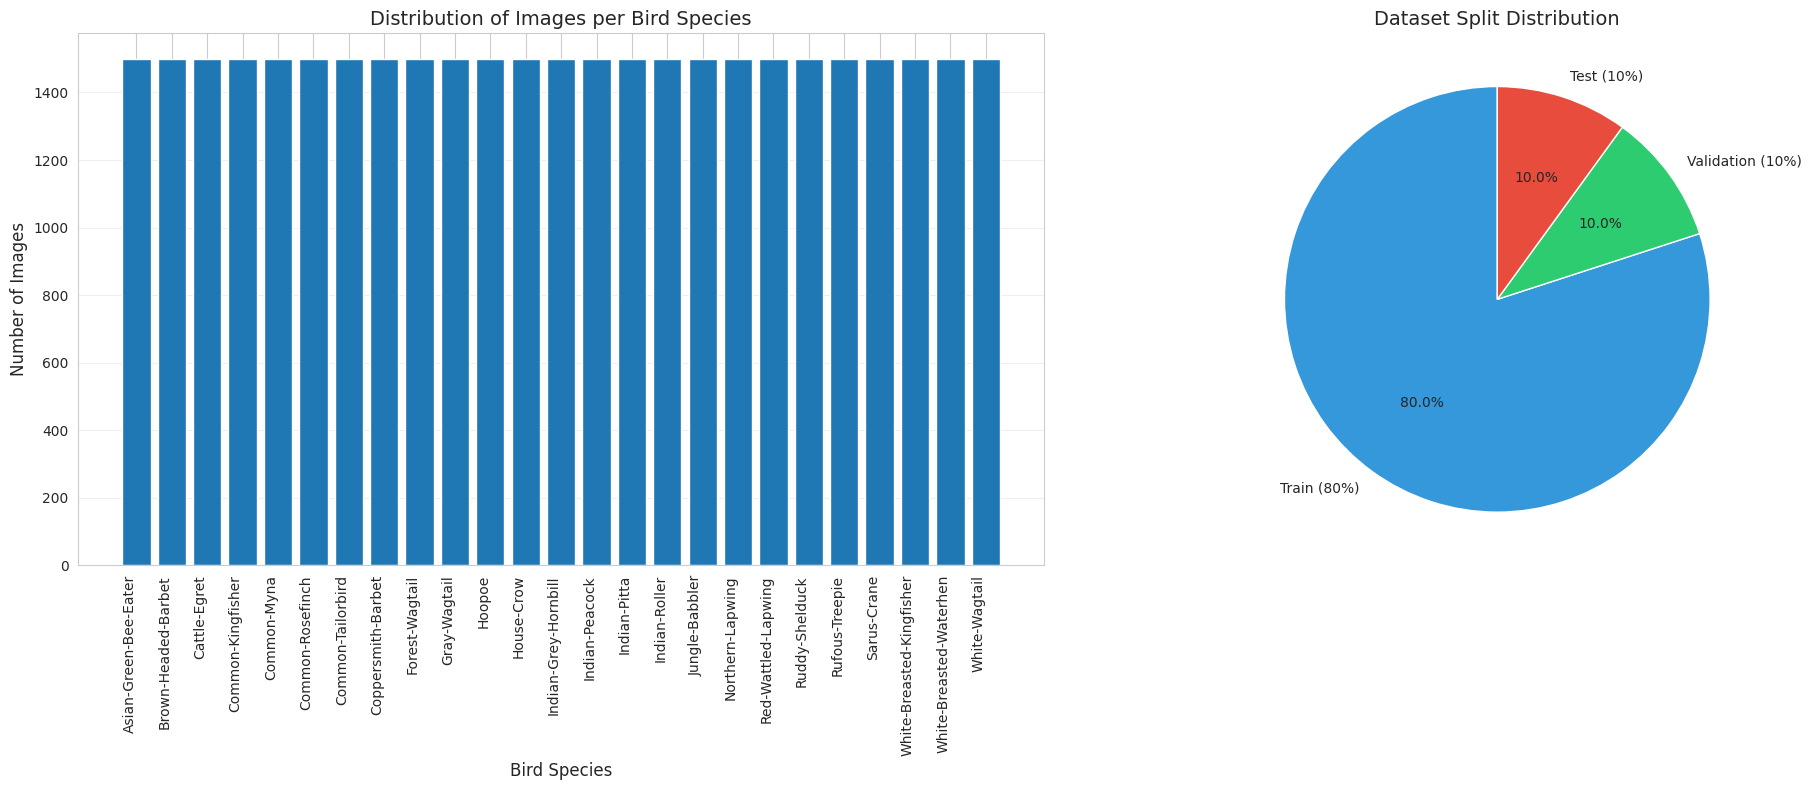

In [57]:

# Main execution of new visualizations
print("\n--- ENHANCED DATA ANALYSIS AND PREPROCESSING VISUALIZATIONS ---")

# 1. Dataset Overview
print("\n1. Dataset Overview Visualizations")
if all(var in globals() for var in ['y_train_final', 'y_val_final', 'y_test_final', 'label_mapping']):
    plot_dataset_overview(y_train_final, y_val_final, y_test_final, label_mapping)
else:
    print("Required variables not found for dataset overview.")




4. Color Distribution Analysis per Species


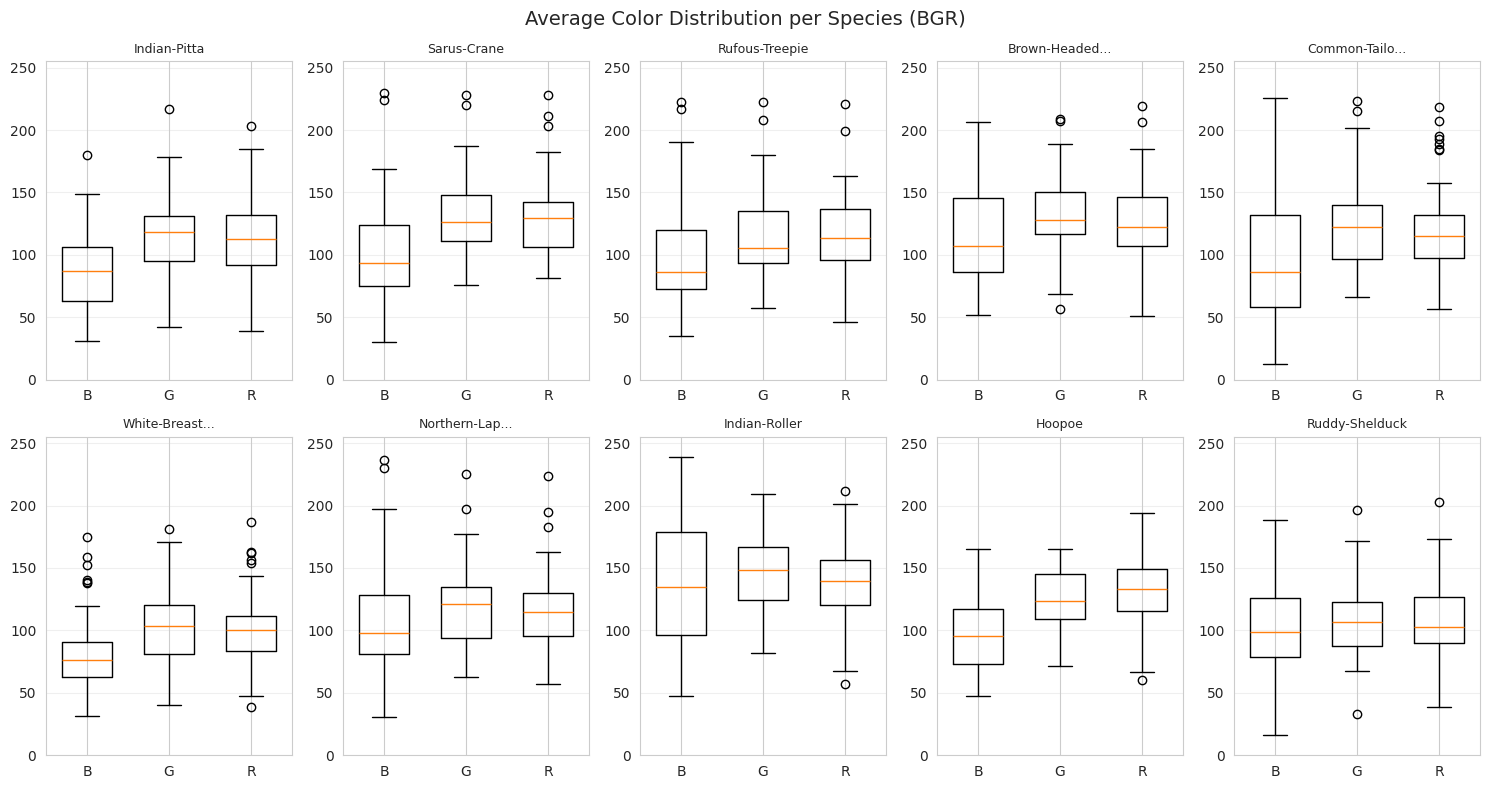

In [58]:

# 4. Color Distribution Analysis
print("\n4. Color Distribution Analysis per Species")
if 'X_train_images_bgr' in globals() and X_train_images_bgr.shape[0] > 0:
    analyze_color_distribution(X_train_images_bgr, y_train_final, label_mapping, num_species=10)
else:
    print("X_train_images_bgr not available for color distribution analysis.")




6. Pixel Intensity Statistical Analysis


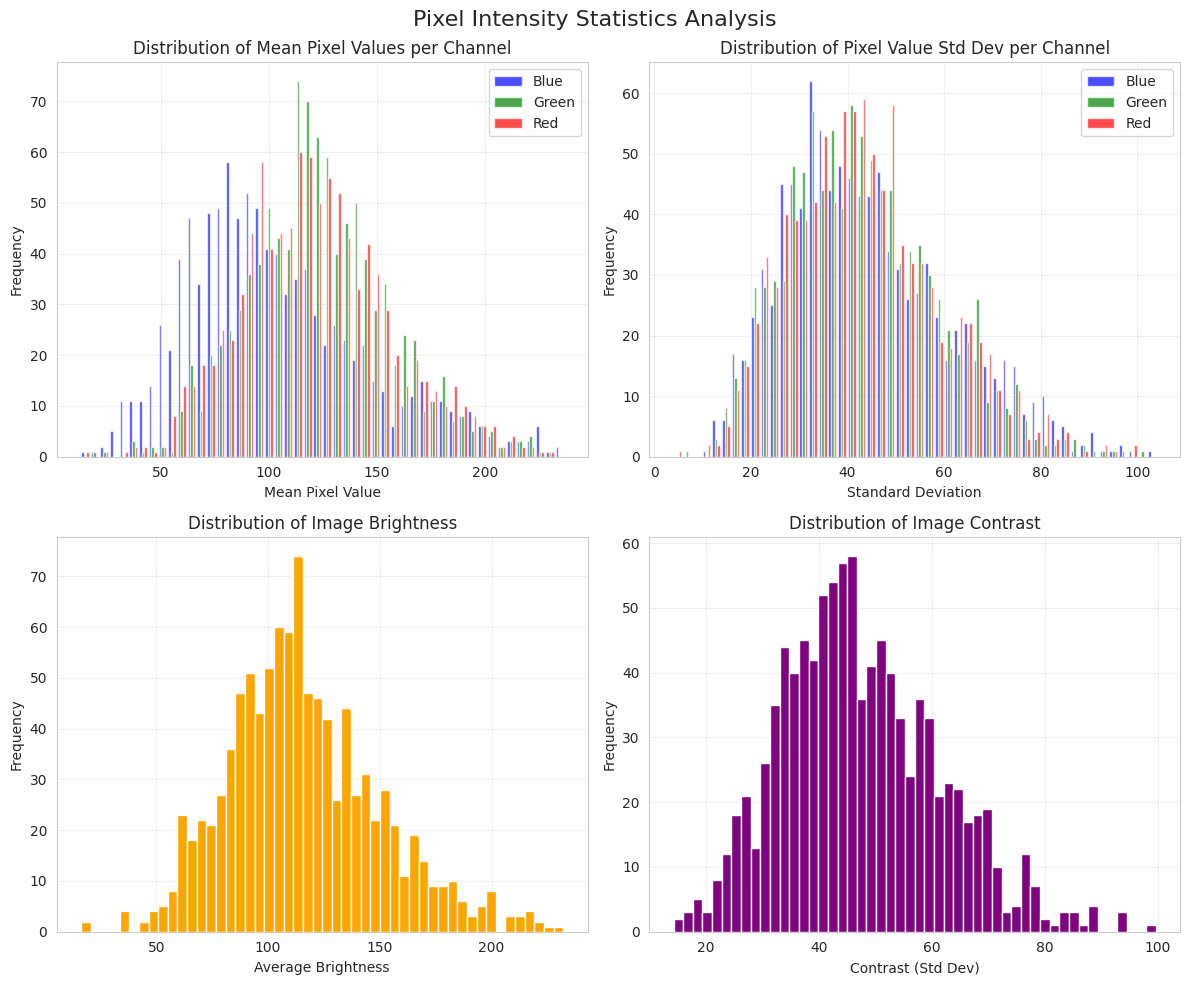

In [59]:

# 6. Statistical Analysis
print("\n6. Pixel Intensity Statistical Analysis")
if 'X_train_images_bgr' in globals() and X_train_images_bgr.shape[0] > 0:
    analyze_pixel_statistics(X_train_images_bgr, sample_size=1000)
else:
    print("X_train_images_bgr not available for statistical analysis.")



7. Class Balance Check Across Splits


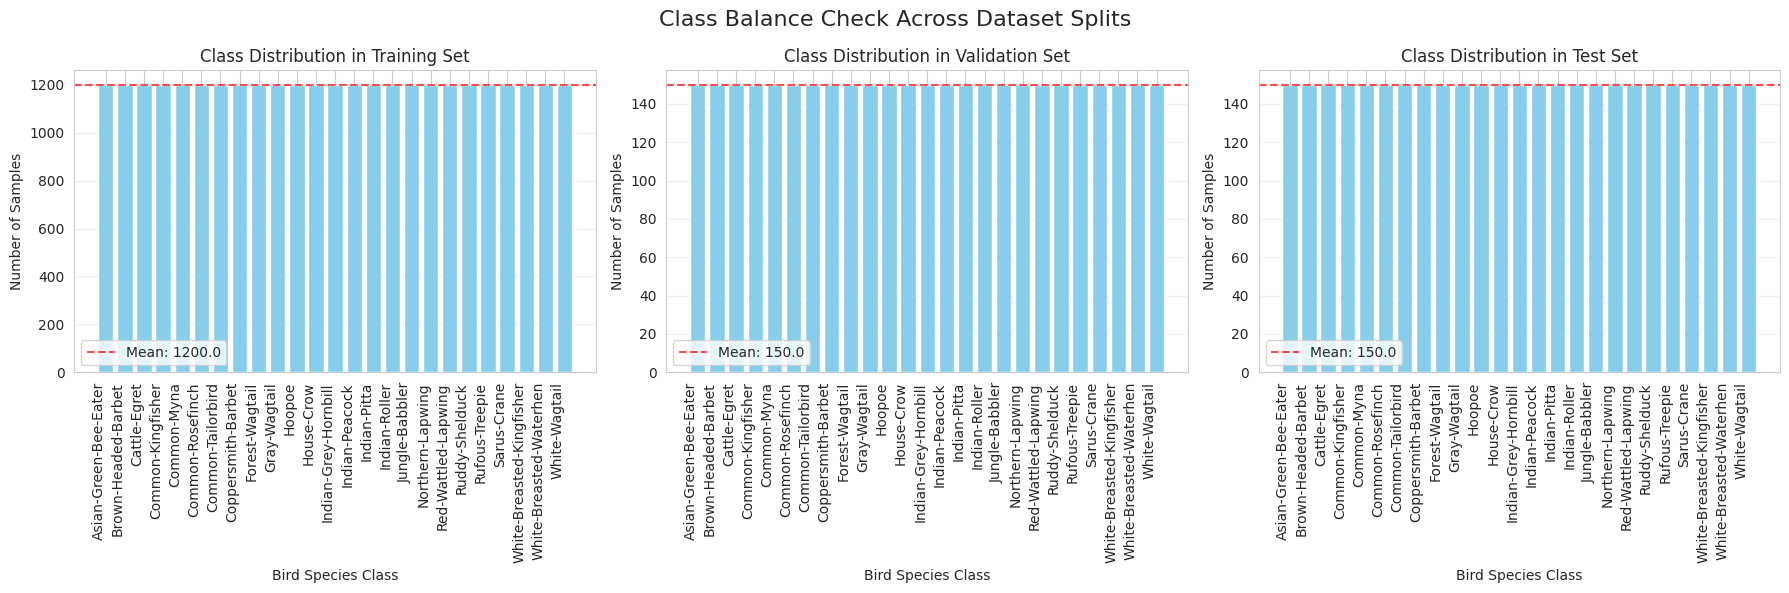

In [60]:

# 7. Class Balance Check
print("\n7. Class Balance Check Across Splits")
if all(var in globals() for var in ['y_train_final', 'y_val_final', 'y_test_final', 'label_mapping']):
    check_class_balance(y_train_final, y_val_final, y_test_final, label_mapping)
else:
    print("Required variables not found for class balance check.")



8. Data Quality Assessment


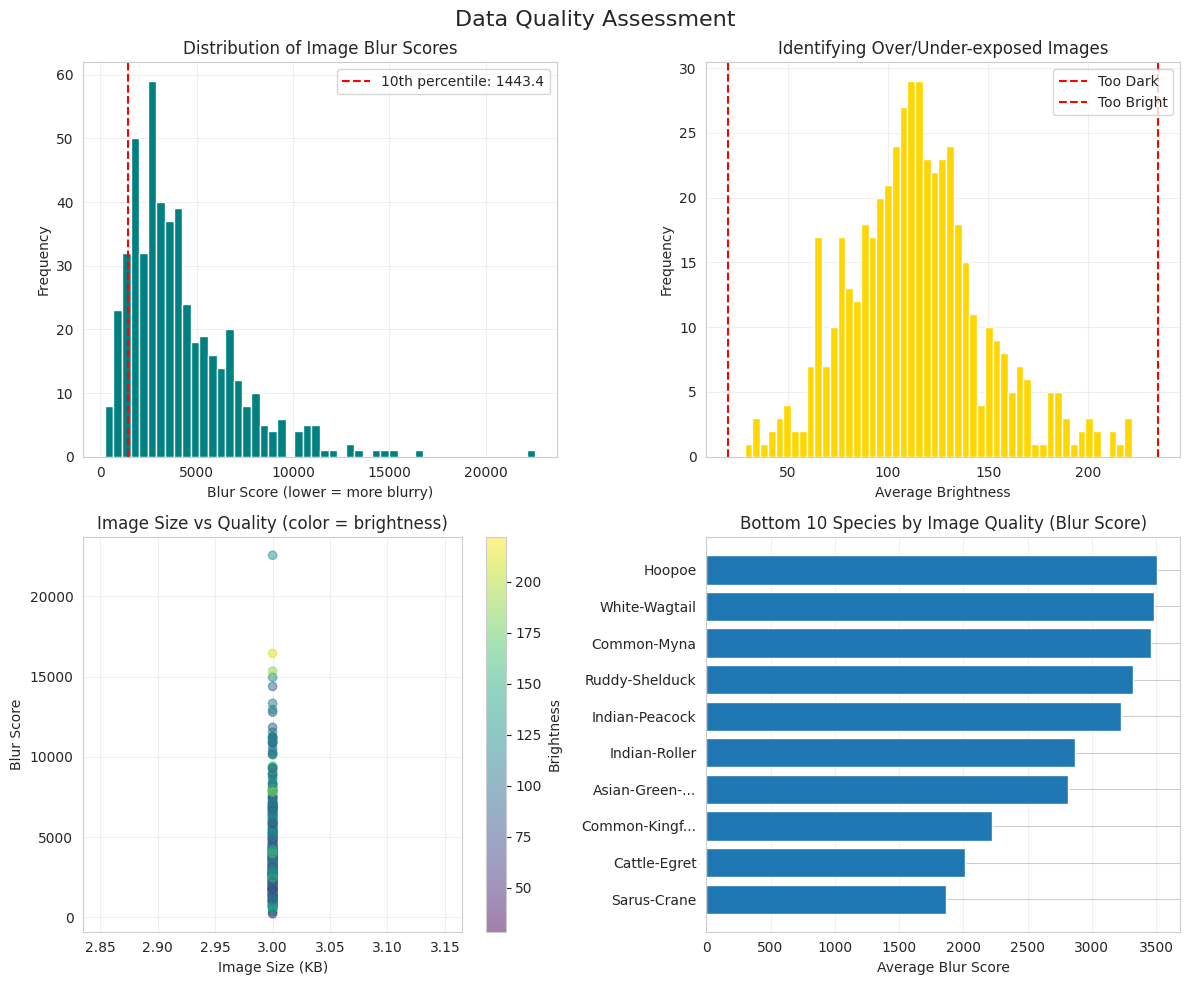


--- END OF ENHANCED DATA ANALYSIS ---


In [61]:

# 8. Data Quality Assessment
print("\n8. Data Quality Assessment")
if 'X_train_images_bgr' in globals() and X_train_images_bgr.shape[0] > 0:
    assess_data_quality(X_train_images_bgr, y_train_final, label_mapping, sample_size=500)
else:
    print("X_train_images_bgr not available for quality assessment.")


print("\n--- END OF ENHANCED DATA ANALYSIS ---")




10. Memory and Computational Analysis


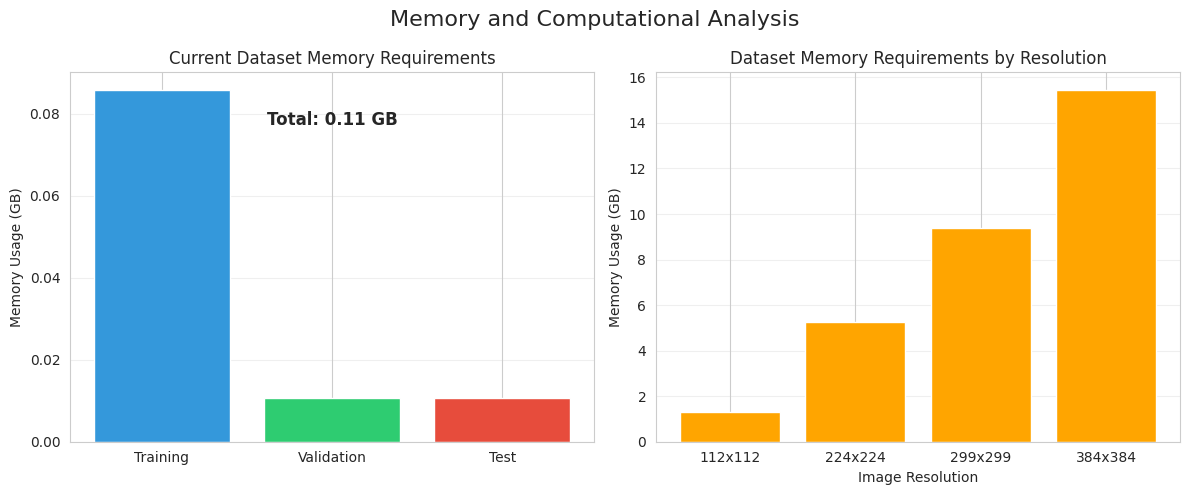

In [62]:


# Execute memory analysis if shapes are available
print("\n10. Memory and Computational Analysis")
if all(var in globals() for var in ['X_train_images_bgr', 'X_val_images_bgr', 'X_test_images_bgr']):
    analyze_memory_and_computation(
        X_train_images_bgr.shape,
        X_val_images_bgr.shape,
        X_test_images_bgr.shape
    )
else:
    print("Required image arrays not found for memory analysis.")


In [63]:


def display_sample_images_from_memory(image_array_bgr, numeric_labels_list, label_mapping_dict,
                                   num_samples_per_class=3, num_classes_to_display=5, title_prefix="Sample Loaded"):
    """Displays sample images from an in-memory BGR NumPy array."""
    if image_array_bgr.size == 0 or not numeric_labels_list.size:
        print(f"Image array or labels list is empty for '{title_prefix}' display.")
        return

    # Group images by class using their indices
    images_by_class_indices = {}
    for idx, label_numeric in enumerate(numeric_labels_list):
        if label_numeric not in images_by_class_indices:
            images_by_class_indices[label_numeric] = []
        images_by_class_indices[label_numeric].append(idx)

    unique_labels_available = list(images_by_class_indices.keys())
    if not unique_labels_available:
        print(f"No unique labels available for '{title_prefix}' display.")
        return

    selected_labels_numeric = random.sample(unique_labels_available, min(num_classes_to_display, len(unique_labels_available)))

    # Adjust subplot layout based on num_samples_per_class
    num_rows = len(selected_labels_numeric)
    num_cols = num_samples_per_class
    plt.figure(figsize=(3 * num_cols, 3.5 * num_rows)) # Adjusted figsize for potentially long titles
    plot_idx = 1
    for label_numeric in selected_labels_numeric:
        class_name = label_mapping_dict.get(label_numeric, f"Label {label_numeric}")
        class_image_indices = images_by_class_indices.get(label_numeric, [])
        if not class_image_indices: continue

        sample_indices = random.sample(class_image_indices, min(num_samples_per_class, len(class_image_indices)))

        for i, img_idx in enumerate(sample_indices):
            if plot_idx > num_rows * num_cols: break # Avoid plotting more than subplots
            plt.subplot(num_rows, num_cols, plot_idx)
            img_bgr_to_display = image_array_bgr[img_idx]
            img_rgb_to_display = cv2.cvtColor(img_bgr_to_display, cv2.COLOR_BGR2RGB)
            plt.imshow(img_rgb_to_display)
            # Truncate long class names if necessary
            display_class_name = (class_name[:20] + '...') if len(class_name) > 23 else class_name
            plt.title(f"{title_prefix}: {display_class_name}\n({img_rgb_to_display.shape[1]}x{img_rgb_to_display.shape[0]})", fontsize=9)
            plt.axis('off')
            plot_idx += 1
    plt.suptitle(f"{title_prefix} Images Per Class (from Memory)", fontsize=16, y=1.0 if num_rows <=1 else 0.98 + (0.02 * (6-num_rows) if num_rows < 6 else 0)) # Adjust suptitle y
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def show_downscaling_effect_from_memory_and_path(in_memory_bgr_image_resized, original_image_path, target_width, target_height):
    """
    Shows original image (read from path for true original dimensions) vs.
    the resized version stored in memory (and its normalized version for display).
    """
    raw_img_for_display_rgb = None
    original_dims_str = "(Original Dim. Unknown - Path Error)"
    if original_image_path and os.path.exists(original_image_path):
        try:
            pil_img_orig = Image.open(original_image_path)
            raw_img_for_display_rgb = np.array(pil_img_orig.convert('RGB'))
            original_dims_str = f"({raw_img_for_display_rgb.shape[1]}x{raw_img_for_display_rgb.shape[0]})"
        except Exception as e:
            print(f"Could not load original image from path {original_image_path} for downscaling demo: {e}")

    if in_memory_bgr_image_resized is None or in_memory_bgr_image_resized.size == 0:
        print("In-memory resized image is not available for downscaling demo.")
        if raw_img_for_display_rgb is None: return
        plt.figure(figsize=(6, 6))
        plt.imshow(raw_img_for_display_rgb)
        plt.title(f'Original Image (Failed to compare with in-memory)\n{original_dims_str}')
        plt.axis('off'); plt.show()
        return

    img_rgb_resized_from_memory = cv2.cvtColor(in_memory_bgr_image_resized, cv2.COLOR_BGR2RGB)
    processed_img_for_display_normalized = img_rgb_resized_from_memory.astype('float32') / 255.0

    fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # Simpler layout
    if raw_img_for_display_rgb is not None:
        axes[0].imshow(raw_img_for_display_rgb)
    else:
        axes[0].imshow(img_rgb_resized_from_memory)
        original_dims_str = f"(Displaying In-Memory Resized: {target_width}x{target_height})"
    axes[0].set_title(f'Original-Like Image\n{original_dims_str}')
    axes[0].axis('off')

    axes[1].imshow(processed_img_for_display_normalized)
    axes[1].set_title(f'Stored & Resized ({target_width}x{target_height})\nDisplayed as RGB Normalized')
    axes[1].axis('off')
    fig.suptitle("Image State: Original-Like vs. Stored & Displayed", fontsize=14, y=1.0) # Adjusted y for suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

def display_average_images_from_memory(X_images_bgr, y_numeric_list, label_mapping_dict, num_classes_to_display=5):
    """Displays average images from an in-memory BGR NumPy array."""
    if X_images_bgr.size == 0 or not y_numeric_list.size:
        print("Image array or labels are empty for average image display.")
        return

    unique_labels = np.unique(y_numeric_list)
    if not unique_labels.size:
        print("No unique labels to display average images for.")
        return

    selected_labels = random.sample(list(unique_labels), min(num_classes_to_display, len(unique_labels)))

    num_cols_avg = min(5, len(selected_labels)) # Max 5 images per row
    num_rows_avg = (len(selected_labels) - 1) // num_cols_avg + 1
    plt.figure(figsize=(3.5 * num_cols_avg, 3.5 * num_rows_avg)) # Slightly larger images

    for i, label_numeric in enumerate(selected_labels):
        class_images_bgr = X_images_bgr[y_numeric_list == label_numeric]
        if class_images_bgr.shape[0] == 0: continue

        average_image_bgr_float = np.mean(class_images_bgr, axis=0)
        average_image_bgr_uint8 = np.clip(average_image_bgr_float, 0, 255).astype(np.uint8)
        average_image_rgb_display = cv2.cvtColor(average_image_bgr_uint8, cv2.COLOR_BGR2RGB)

        plt.subplot(num_rows_avg, num_cols_avg, i + 1)
        plt.imshow(average_image_rgb_display)
        class_name_display = label_mapping_dict.get(label_numeric, str(label_numeric))
        class_name_display = (class_name_display[:15] + '...') if len(class_name_display) > 18 else class_name_display
        plt.title(f"Avg: {class_name_display}", fontsize=10)
        plt.axis('off')
    plt.suptitle("Average Images Per Class (from Memory, BGR -> RGB for display)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

def plot_color_histograms_for_bgr_image(image_bgr, title="Color Histogram (BGR channels)"): #
    """Plots BGR color histograms for a single BGR image (0-255 range)."""
    if image_bgr is None or image_bgr.size == 0 :
        print(f"Image for histogram ('{title}') is None or empty.")
        return

    if image_bgr.dtype != np.uint8:
        print(f"Warning: Image for histogram ('{title}') is not uint8 (dtype: {image_bgr.dtype}). Clipping and converting.")
        image_bgr = np.clip(image_bgr, 0, 255).astype(np.uint8)

    colors, channel_names = (('b', 'g', 'r')), (('Blue', 'Green', 'Red'))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Image for Histograms")
    axes[0].axis('off')

    for channel_idx, color_char in enumerate(colors[0]):
        histogram = cv2.calcHist([image_bgr], [channel_idx], None, [256], [0, 256]) #
        axes[1].plot(histogram, color=color_char, label=f'{channel_names[0][channel_idx]} channel') #

    axes[1].set_title(title, fontsize=12) # Reduced title fontsize slightly
    axes[1].set_xlabel("Pixel Intensity (0-255)") #
    axes[1].set_ylabel("Number of Pixels") #
    axes[1].legend() #
    axes[1].grid(True, linestyle='--', alpha=0.7) #
    axes[1].set_xlim([0, 256]) #
    fig.suptitle("Image and its BGR Color Histograms", fontsize=14, y=1.0) # Main suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.93]) # Adjust rect for suptitle
    plt.show()
    
    

# %% [markdown]
# ## Step 5: Data Visualizations (Using In-Memory Data)
# These calls will now use the pre-loaded and filtered `X_..._images_bgr` and `y_..._final` arrays.

# %% Step 5 Code
# Ensure the variables X_train_images_bgr, y_train_final (and _val, _test versions)
# and label_mapping are available from the "Efficient Image Loading" cell (Step 3).



--- Displaying Sample Loaded Images from Training Set (Memory) ---


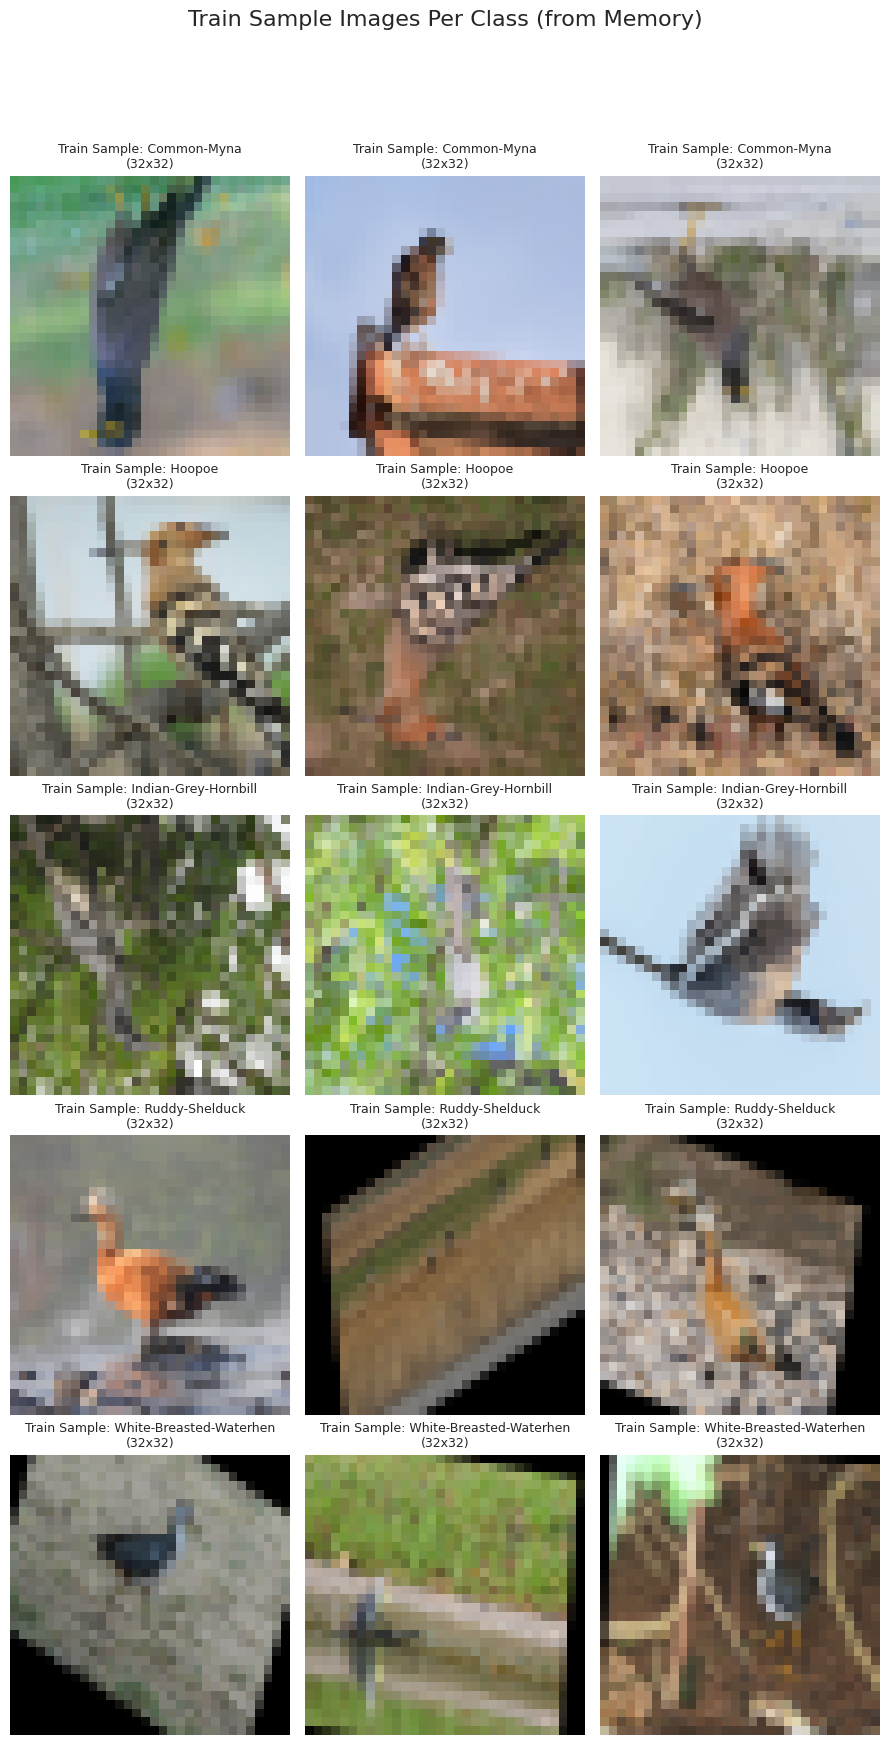

In [64]:

print("\n--- Displaying Sample Loaded Images from Training Set (Memory) ---") #
if 'X_train_images_bgr' in globals() and X_train_images_bgr.shape[0] > 0: # Check if array has content
    display_sample_images_from_memory(X_train_images_bgr, y_train_final, label_mapping, num_classes_to_display=5, title_prefix="Train Sample")
else:
    print("X_train_images_bgr is empty or not defined. Cannot display sample images.")




--- Downscaling Effect Visualization (Using a Sample from Memory) ---


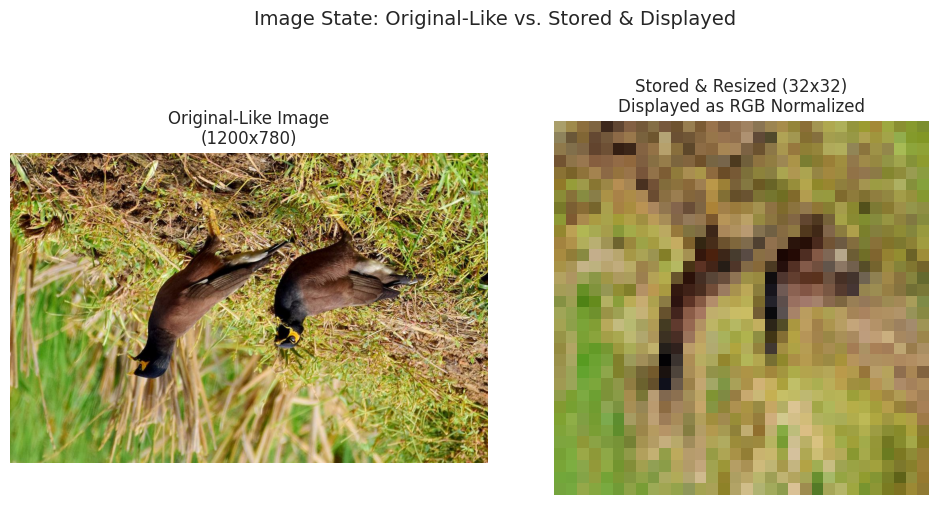

In [65]:


print("\n--- Downscaling Effect Visualization (Using a Sample from Memory) ---") #
# We need an original path for this to show the *true* original. We stored successfully_loaded_paths.
if 'X_train_images_bgr' in globals() and X_train_images_bgr.shape[0] > 0 and \
   'X_train_paths_final' in globals() and X_train_paths_final: # Ensure we have paths for original dimensions
    sample_idx_downscale = random.randint(0, X_train_images_bgr.shape[0] - 1)
    img_bgr_resized_for_downscale_demo = X_train_images_bgr[sample_idx_downscale]
    original_path_for_downscale_demo = X_train_paths_final[sample_idx_downscale] # Use the filtered path
    show_downscaling_effect_from_memory_and_path(img_bgr_resized_for_downscale_demo, original_path_for_downscale_demo, IMG_WIDTH, IMG_HEIGHT) #
else:
    print("Cannot show downscaling effect: Training image data or successfully loaded paths are missing.")




--- Average Images Per Class (from Memory) ---


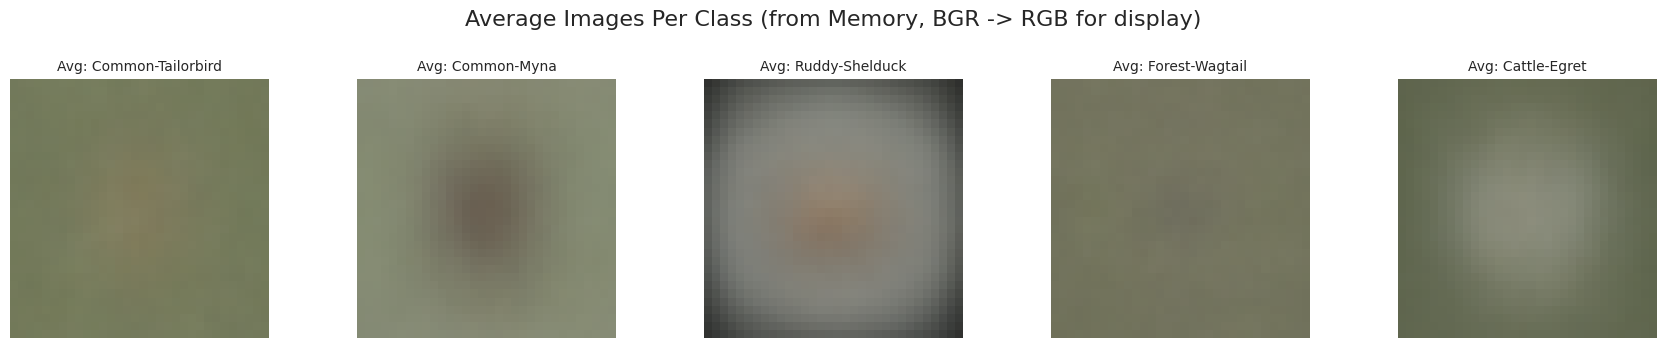

In [66]:
print("\n--- Average Images Per Class (from Memory) ---") #
if 'X_train_images_bgr' in globals() and X_train_images_bgr.shape[0] > 0:
    display_average_images_from_memory(X_train_images_bgr, y_train_final, label_mapping, num_classes_to_display=min(NUM_CLASSES if 'NUM_CLASSES' in globals() and NUM_CLASSES > 0 else 5, 5)) #
else:
    print("X_train_images_bgr is empty. Cannot display average images.")



--- Color Histograms for a Sample Image (from Memory, BGR channels) ---


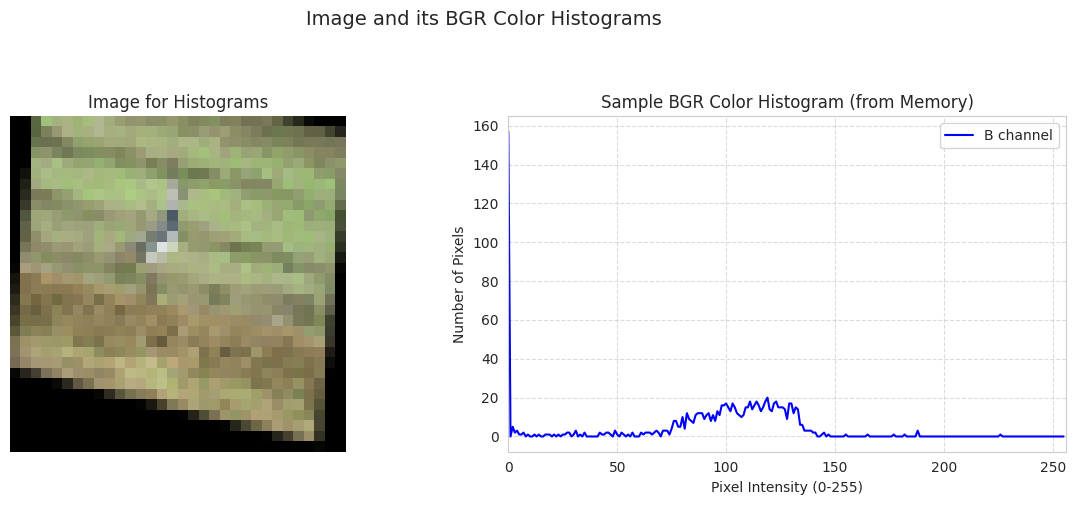

In [67]:

print("\n--- Color Histograms for a Sample Image (from Memory, BGR channels) ---") #
if 'X_train_images_bgr' in globals() and X_train_images_bgr.shape[0] > 0:
    sample_idx_hist = random.randint(0, X_train_images_bgr.shape[0] - 1)
    img_bgr_for_hist_demo = X_train_images_bgr[sample_idx_hist]
    plot_color_histograms_for_bgr_image(img_bgr_for_hist_demo, title="Sample BGR Color Histogram (from Memory)") #
else:
    print("X_train_images_bgr is empty. Cannot display color histograms.")



### Part 0.6: Data Visualizations and Train, Test and Valid Splits

## Part 1: Classification According to Feature Extraction

### Part 1.1: Library Imports

In [68]:
# %% [markdown]
# ## Part 1: Classification According to Feature Extraction (HSV, HoG, Gabor - Parallel with MLP)

# %%
# Önceki importlarınıza ek olarak veya mevcut olanları kontrol ederek:
from skimage.feature import hog
from skimage import color, filters # Gabor için filters modülü
import cv2 # OpenCV zaten import edilmiş olmalı
import numpy as np
from multiprocessing import Pool, cpu_count
import time

# ML Modelleri ve Pipeline için gerekli importlar
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier # Naive Bayes yerine MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score


### Part 1.2: Visualizing Feature Extraction Algorithms

#### Part 1.2.1: Function Definitions


In [69]:

# %%
# Part 0'dan gelen değişkenler varsayılıyor:
# X_train_images_bgr, y_train_final
# X_test_images_bgr, y_test_final
# target_names_part1 (sınıf isimleri listesi)
# IMG_WIDTH, IMG_HEIGHT (örneğin 128, 128)

# --- Özellik Çıkarım Fonksiyonları ---
# (extract_hsv_histogram_single_image, extract_hog_features_single_image, extract_gabor_features_single_image fonksiyonları
# bir önceki yanıttaki gibi burada tanımlı olmalıdır)

def extract_hsv_histogram_single_image(image_bgr, h_bins=8, s_bins=4, v_bins=4):
    """Tek bir BGR resimden HSV renk histogramı özelliklerini çıkarır."""
    if image_bgr is None:
        return None
    try:
        image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([image_hsv], [0, 1, 2], None,
                            [h_bins, s_bins, v_bins],
                            [0, 180, 0, 256, 0, 256]) # Hue için 0-179 aralığı
        cv2.normalize(hist, hist) # Normalizasyon
        return hist.flatten()
    except Exception as e:
        print(f"Error extracting HSV histogram: {e}")
        return None

def extract_hog_features_single_image(image_bgr):
    """Tek bir BGR resimden HoG özelliklerini çıkarır."""
    if image_bgr is None:
        return None
    try:
        image_gray = color.rgb2gray(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
        features = hog(image_gray, pixels_per_cell=(16, 16),
                       cells_per_block=(2, 2), orientations=9,
                       visualize=False, feature_vector=True, block_norm='L2-Hys')
        return features
    except Exception as e:
        print(f"Error extracting HoG features: {e}")
        return None

# def extract_gabor_features_single_image(image_bgr, num_orientations=8, frequencies=(0.05, 0.25, 0.5), sigmas=(1,3)):
#     """Tek bir BGR resimden Gabor filtresi tepkilerinin ortalama ve std. sapmasını çıkarır."""
#     if image_bgr is None:
#         return None
#     try:
#         image_gray = color.rgb2gray(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
#         gabor_features = []
#         for theta_idx in range(num_orientations):
#             theta = theta_idx / float(num_orientations) * np.pi
#             for frequency in frequencies:
#                 for sigma_val in sigmas:
#                     filt_real, filt_imag = filters.gabor(image_gray, frequency=frequency, theta=theta, sigma_x=sigma_val, sigma_y=sigma_val)
#                     magnitude = np.sqrt(filt_real**2 + filt_imag**2)
#                     gabor_features.append(np.mean(magnitude))
#                     gabor_features.append(np.std(magnitude))
#         return np.array(gabor_features)
#     except Exception as e:
#         print(f"Error extracting Gabor features: {e}")
#         return None
def extract_gabor_features_single_image(image_bgr, num_orientations=4, frequencies=(0.1, 0.3), sigmas=(2,)):
    """Hızlandırılmış Gabor feature extraction - daha az parametre"""
    if image_bgr is None:
        return None
    try:
        # Görüntüyü küçült
        small_image = cv2.resize(image_bgr, (64, 64))
        image_gray = color.rgb2gray(cv2.cvtColor(small_image, cv2.COLOR_BGR2RGB))
        
        gabor_features = []
        for theta_idx in range(num_orientations):
            theta = theta_idx / float(num_orientations) * np.pi
            for frequency in frequencies:
                for sigma_val in sigmas:
                    filt_real, filt_imag = filters.gabor(image_gray, frequency=frequency, 
                                                         theta=theta, sigma_x=sigma_val, 
                                                         sigma_y=sigma_val)
                    magnitude = np.sqrt(filt_real**2 + filt_imag**2)
                    gabor_features.append(np.mean(magnitude))
                    gabor_features.append(np.std(magnitude))
        
        return np.array(gabor_features)
    except Exception as e:
        print(f"Error extracting Gabor features: {e}")
        return None
# %%
# --- ML Modellerini Getiren Fonksiyon (NaiveBayes yerine MLP ile GÜNCELLENDİ) ---
def get_ml_models():
    models = {
        "SVM": SVC(kernel='rbf', C=1.0, random_state=42, probability=True, max_iter=1000),
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        "LogisticRegression": LogisticRegression(solver='liblinear', max_iter=200, random_state=42),
        "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42, early_stopping=True) # NaiveBayes yerine
    }
    return models

# %%
# --- Her bir işlem (thread/process) için ana işleyici fonksiyon ---
# process_feature_and_models fonksiyonu bir önceki yanıttaki (Turn 13 veya 14) gibi kalacak.
# Sadece get_ml_models() fonksiyonunun güncellenmiş halini kullanacak.
# Bu fonksiyonu bir önceki yanıttan kopyalayıp buraya veya bir önceki hücreye ekleyebilirsiniz.
# Eğer zaten notebook'unuzda varsa, sadece get_ml_models çağrısının doğru olduğundan emin olun.
# (Örnek: Bir önceki yanıttaki gibi process_feature_and_models fonksiyonu)

def process_feature_and_models(feature_name, feature_extractor_func,
                               X_train_imgs, y_train_labels,
                               X_test_imgs, y_test_labels,
                               ml_models_dict, target_names):
    """
    Belirli bir özellik çıkarıcıyı kullanarak özellikleri çıkarır,
    ardından verilen ML modellerini eğitir ve test eder.
    """
    print(f"--- Starting process for {feature_name} ---")

    # 1. Özellik Çıkarımı
    print(f"Extracting {feature_name} features for training set...")
    start_fe_time = time.time()
    # Özellik çıkarımını doğrudan numpy array üzerinde yapalım
    X_train_features_list = [feature_extractor_func(img) for img in X_train_imgs]

    # Başarısız olanları (None dönenleri) ve karşılık gelen etiketleri filtrele
    successful_train_indices = [i for i, f in enumerate(X_train_features_list) if f is not None]
    if len(successful_train_indices) == 0:
        print(f"ERROR: No training features successfully extracted for {feature_name}. Skipping.")
        return {feature_name: "Feature extraction failed for all training samples."}
    X_train_features = np.array([X_train_features_list[i] for i in successful_train_indices])
    y_train_labels_filtered = y_train_labels[successful_train_indices]

    if X_train_features.size == 0:
        print(f"ERROR: No training features extracted (after filtering None) for {feature_name}. Skipping.")
        return {feature_name: "Feature extraction resulted in empty training set."}

    print(f"Extracting {feature_name} features for test set...")
    X_test_features_list = [feature_extractor_func(img) for img in X_test_imgs]

    successful_test_indices = [i for i, f in enumerate(X_test_features_list) if f is not None]
    if len(successful_test_indices) == 0:
        print(f"ERROR: No test features successfully extracted for {feature_name}. Skipping model evaluations for this feature.")
        return {feature_name: "Feature extraction failed for all test samples."}
    X_test_features = np.array([X_test_features_list[i] for i in successful_test_indices])
    y_test_labels_filtered = y_test_labels[successful_test_indices]

    if X_test_features.size == 0:
        print(f"ERROR: No test features extracted (after filtering None) for {feature_name}. Skipping.")
        return {feature_name: "Feature extraction resulted in empty test set."}

    end_fe_time = time.time()
    print(f"{feature_name} feature extraction completed in {end_fe_time - start_fe_time:.2f} seconds.")
    print(f"Train features shape: {X_train_features.shape}, Test features shape: {X_test_features.shape}")

    results = {}

    # 2. ML Modellerini Eğitme ve Test Etme
    for model_name, model_instance in ml_models_dict.items():
        print(f"\nTraining {model_name} with {feature_name} features...")
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model_instance)
        ])

        start_train_time = time.time()
        try:
            if X_train_features.shape[1] != X_test_features.shape[1]:
                 print(f"ERROR: Feature dimension mismatch for {feature_name} between train ({X_train_features.shape[1]}) and test ({X_test_features.shape[1]}). Skipping {model_name}.")
                 results[f"{feature_name}_{model_name}"] = {"error": "Feature dimension mismatch"}
                 continue

            if X_train_features.shape[0] == 0 or y_train_labels_filtered.shape[0] == 0:
                print(f"ERROR: Empty training features or labels for {feature_name}. Skipping {model_name}.")
                results[f"{feature_name}_{model_name}"] = {"error": "Empty training data"}
                continue

            if len(np.unique(y_train_labels_filtered)) < 2 :
                print(f"ERROR: Training data for {feature_name} has less than 2 classes. Skipping {model_name}.")
                results[f"{feature_name}_{model_name}"] = {"error": "Less than 2 classes in training data"}
                continue


            pipeline.fit(X_train_features, y_train_labels_filtered)
        except ValueError as e:
            print(f"ERROR training {model_name} with {feature_name}: {e}. Skipping this model.")
            results[f"{feature_name}_{model_name}"] = {"error": str(e)}
            continue
        end_train_time = time.time()
        print(f"{model_name} training completed in {end_train_time - start_train_time:.2f} seconds.")

        # Test seti üzerinde değerlendirme
        if X_test_features.shape[0] > 0 and y_test_labels_filtered.shape[0] > 0 :
            if len(np.unique(y_test_labels_filtered)) < 2 and len(np.unique(y_test_labels_filtered)) != len(np.unique(y_train_labels_filtered)):
                 print(f"Warning: Test data for {feature_name} has less than 2 classes or different class set than train. Report might be problematic.")

            y_pred = pipeline.predict(X_test_features)
            accuracy = accuracy_score(y_test_labels_filtered, y_pred)
            try:
                # Sınıflandırma raporu için etiketlerin hem train hem de test setinde olmasını sağlamak gerekebilir
                # Eğer target_names verilmiyorsa, sadece mevcut etiketleri kullanır.
                # Modelin eğitildiği sınıflarla testteki sınıflar aynı olmalı.
                unique_labels_in_test_and_train = sorted(list(set(y_train_labels_filtered) | set(y_test_labels_filtered)))
                current_target_names = [target_names[i] for i in unique_labels_in_test_and_train if i < len(target_names)]

                report = classification_report(y_test_labels_filtered, y_pred, labels=unique_labels_in_test_and_train, target_names=current_target_names, zero_division=0, output_dict=True)
            except ValueError as e:
                print(f"Warning: Could not generate classification report for {model_name} with {feature_name} due to label mismatch or other issues: {e}")
                report = {"error": str(e), "accuracy_manual": accuracy}


            print(f"\n{model_name} with {feature_name} - Test Set:")
            print(f"Accuracy: {accuracy:.4f}")
            if "error" not in report and 'macro avg' in report:
                print(f"Macro Avg F1-score: {report.get('macro avg', {}).get('f1-score', 'N/A'):.4f}")

            results[f"{feature_name}_{model_name}"] = {
                "accuracy": accuracy,
                "classification_report_dict": report
            }
        else:
            print(f"Test features for {feature_name} are empty or labels are missing. Skipping evaluation for {model_name}.")
            results[f"{feature_name}_{model_name}"] = {"error": "Empty test features or labels"}

    print(f"--- Finished process for {feature_name} ---")
    return {feature_name: results}





#### 1.2.2: Feature Extraction Algorithm Graphs

Selected Sample Image Index: 17636
Class: Indian-Pitta


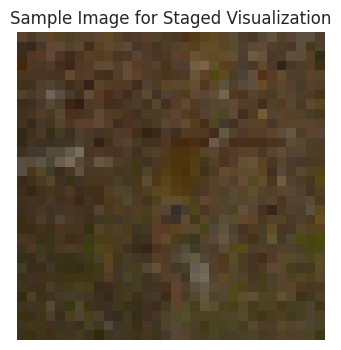


========== 1. HSV Transformation Stages ==========


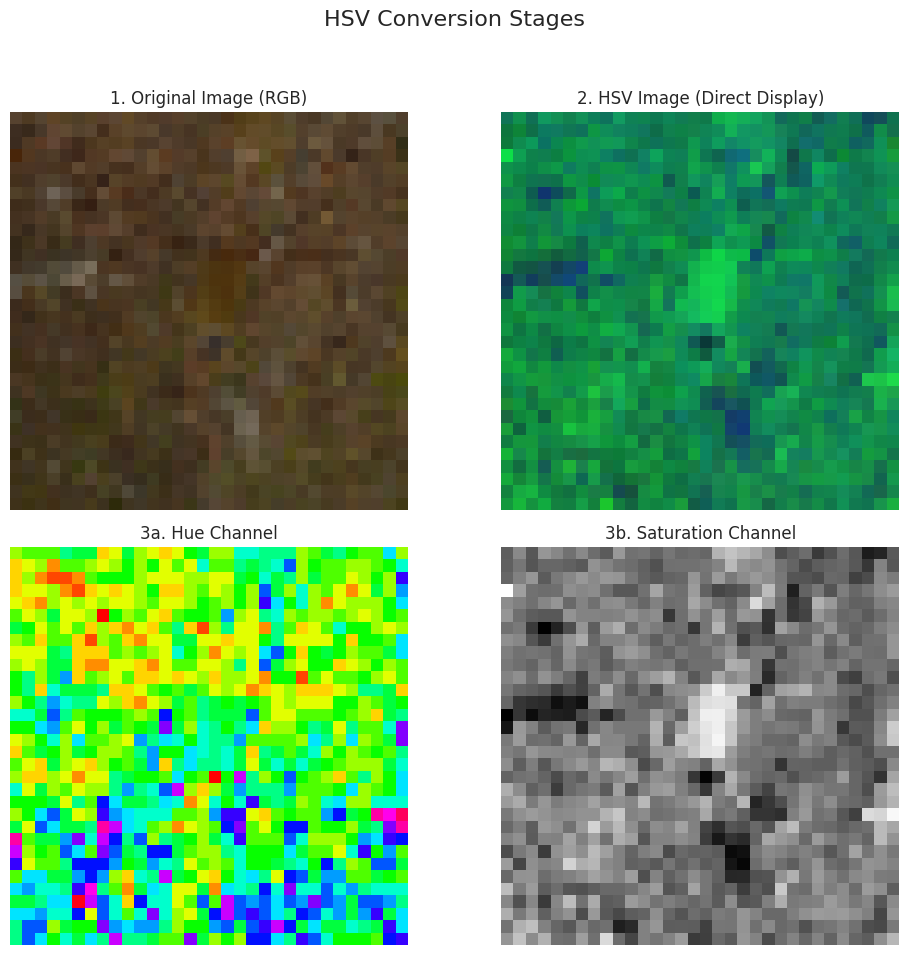

Characteristics of HSV Channels:
  Hue (H) channel value range: 10 - 31
  Saturation (S) channel value range: 53 - 223
  Value (V) channel value range: 45 - 126

Features typically extracted from HSV include:
  - Histograms of the channels (e.g., 1D H, S, V histograms, or a 3D combined histogram)
  - Statistical moments like mean, standard deviation of channels
  - Pixel counts in specific color ranges (after color masking)

========== 2. HoG Feature Extraction Stages ==========


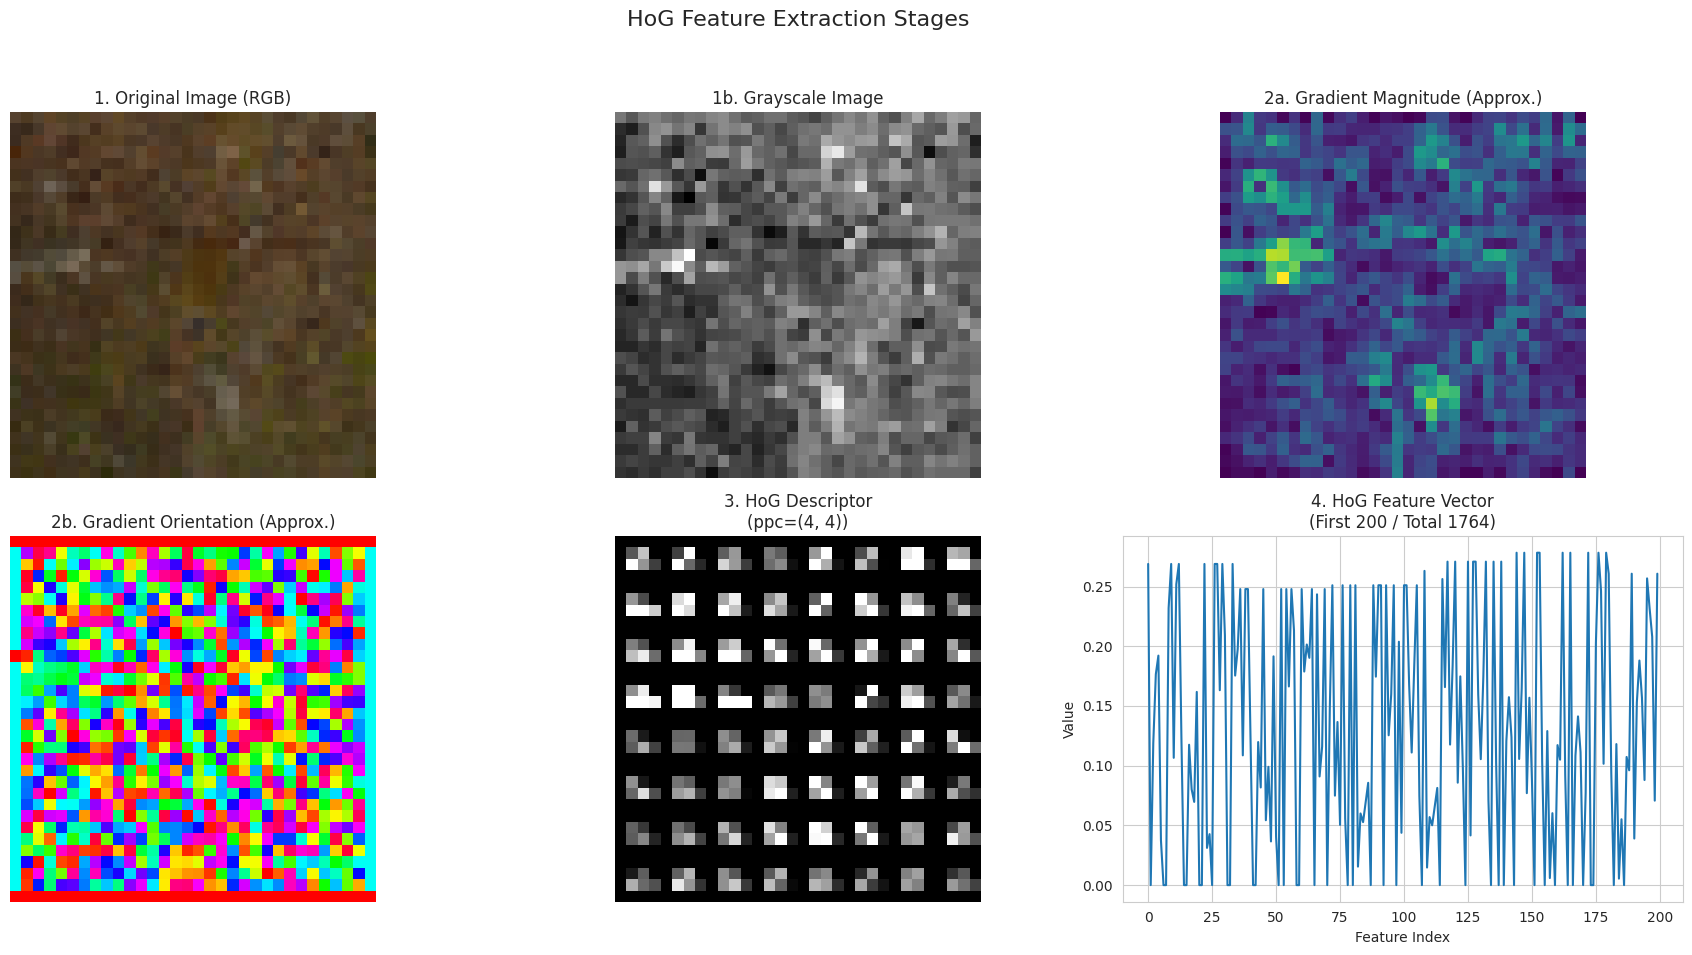


HoG Process Steps:
  1. (Optional) Gamma correction and normalization.
  2. Conversion of the image to grayscale.
  3. Calculation of gradients (magnitude and orientation).
  4. Division of the image into small cells.
  5. Creation of a histogram of gradient orientations for each cell.
  6. Grouping of cells into larger blocks.
  7. Normalization of blocks (to reduce sensitivity to illumination and contrast changes).
  8. Concatenation of histograms from all blocks to form the final feature vector.

========== 3. Gabor Filter Application Stages ==========
Gabor Filter Application (Sigma=2.0):

  Frequency: 0.10

  Frequency: 0.40


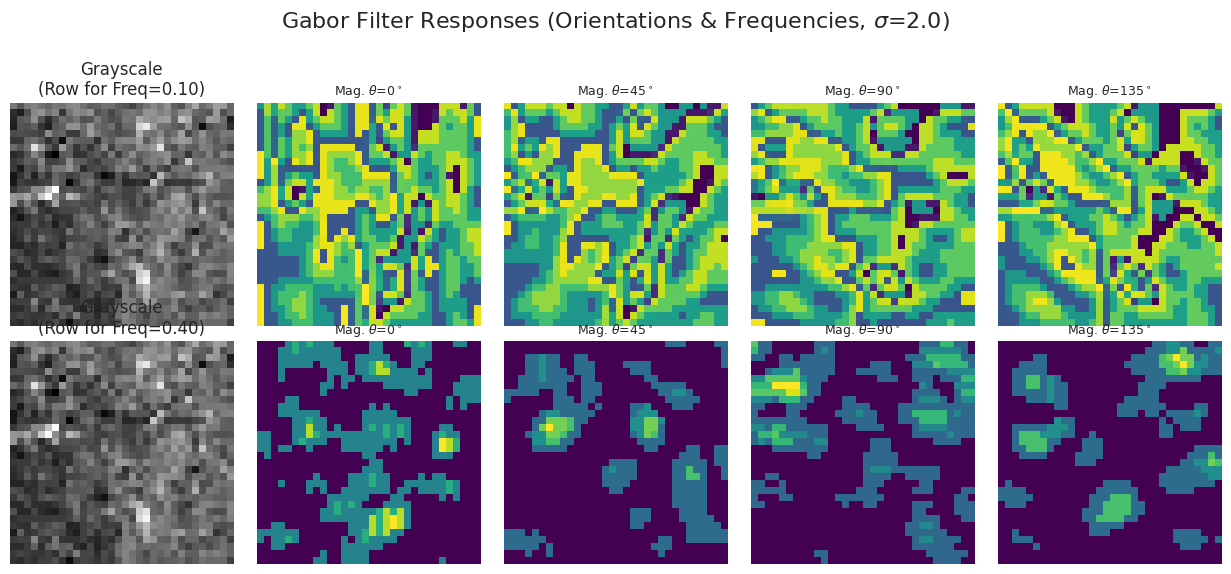


Example Gabor Feature Vector (Mean and Std Dev of Magnitudes):
  Total 16 features (2 per filter: mean, std)
  First 10 features: [9.49   4.047  9.42   3.9    9.52   3.994  9.516  4.23   0.4092 0.5522]

Gabor Filtering Process:
  1. Image is typically converted to grayscale.
  2. A Gabor filter bank is defined with different orientations, frequencies, and scales (sigma).
  3. Each filter is applied to the image (convolution).
  4. Statistical features (e.g., mean, standard deviation, energy) are extracted from each filtered image (usually from the magnitude response).
  5. These features are concatenated to form the final Gabor feature vector.


In [70]:
# %% [markdown]
# ## Visualizing Feature Extraction Processes Step-by-Step

# %%
# Required libraries (ensure these are imported in your notebook)
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import color, exposure, filters # filters for Gabor
import random

# %% [markdown]
# ### 1. HSV Color Space: Staged Visualization Function

# %%
def visualize_hsv_stages(image_bgr):
    """
    Visualizes the stages of converting a BGR image to HSV.
    """
    if image_bgr is None:
        print("Input image cannot be None.")
        return

    # Step 1: Original BGR Image (converted to RGB for Matplotlib)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Step 2: Convert BGR to HSV
    image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

    # Step 3: Split HSV Channels
    h_channel, s_channel, v_channel = cv2.split(image_hsv)

    # Visualization
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    axs[0, 0].imshow(image_rgb)
    axs[0, 0].set_title('1. Original Image (RGB)')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(image_hsv) # Direct display of HSV can look unusual
    axs[0, 1].set_title('2. HSV Image (Direct Display)')
    axs[0, 1].axis('off')

    axs[1, 0].imshow(h_channel, cmap='hsv') # 'hsv' colormap for Hue channel
    axs[1, 0].set_title('3a. Hue Channel')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(s_channel, cmap='gray')
    axs[1, 1].set_title('3b. Saturation Channel')
    axs[1, 1].axis('off')

    # To also display the Value channel, adjust subplot layout (e.g., 2,3 or 1,4)
    # fig_v, ax_v = plt.subplots(1,1, figsize=(5,5))
    # ax_v.imshow(v_channel, cmap='gray')
    # ax_v.set_title('3c. Value Channel')
    # ax_v.axis('off')
    # plt.show()


    plt.suptitle('HSV Conversion Stages', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Make space for suptitle
    plt.show()

    print("Characteristics of HSV Channels:")
    print(f"  Hue (H) channel value range: {np.min(h_channel)} - {np.max(h_channel)}")
    print(f"  Saturation (S) channel value range: {np.min(s_channel)} - {np.max(s_channel)}")
    print(f"  Value (V) channel value range: {np.min(v_channel)} - {np.max(v_channel)}")
    print("\nFeatures typically extracted from HSV include:")
    print("  - Histograms of the channels (e.g., 1D H, S, V histograms, or a 3D combined histogram)")
    print("  - Statistical moments like mean, standard deviation of channels")
    print("  - Pixel counts in specific color ranges (after color masking)")

# %% [markdown]
# ### 2. HoG (Histogram of Oriented Gradients): Staged Visualization Function

# %%
def visualize_hog_stages(image_bgr, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9):
    """
    Visualizes the basic stages of HoG feature extraction from a BGR image.
    """
    if image_bgr is None:
        print("Input image cannot be None.")
        return

    # Step 1: Original Image and Convert to Grayscale
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY) # Or use skimage.color.rgb2gray

    # Step 2: Calculate Gradients (HoG does this internally, showing an example)
    # Sobel filter for x and y gradients
    grad_x = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=3)

    # Gradient magnitude and orientation
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    grad_orientation = np.arctan2(grad_y, grad_x) * (180 / np.pi) % 180 # 0-180 degrees

    # Step 3: Cell-wise Gradient Orientation Histograms (Internal to HoG function)
    # The HoG visualization itself shows this cell structure and orientations.

    # Step 4: HoG Descriptors and Visualization
    hog_features, hog_image = hog(image_gray,
                                  orientations=orientations,
                                  pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block,
                                  visualize=True,
                                  feature_vector=True, # For the final feature vector
                                  block_norm='L2-Hys')

    # Visualization
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    axs[0, 0].imshow(image_rgb)
    axs[0, 0].set_title('1. Original Image (RGB)')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(image_gray, cmap='gray')
    axs[0, 1].set_title('1b. Grayscale Image')
    axs[0, 1].axis('off')

    axs[0, 2].imshow(grad_magnitude, cmap='viridis') # Gradient magnitude
    axs[0, 2].set_title('2a. Gradient Magnitude (Approx.)')
    axs[0, 2].axis('off')

    axs[1, 0].imshow(grad_orientation, cmap='hsv') # Gradient orientation (hsv often good for angles)
    axs[1, 0].set_title('2b. Gradient Orientation (Approx.)')
    axs[1, 0].axis('off')

    if hog_image is not None:
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) # Rescale for better visibility
        axs[1, 1].imshow(hog_image_rescaled, cmap='gray')
        axs[1, 1].set_title(f'3. HoG Descriptor\n(ppc={pixels_per_cell})')
        axs[1, 1].axis('off')
    else:
        axs[1, 1].text(0.5, 0.5, 'HoG Image Not Available', ha='center', va='center')
        axs[1, 1].set_title('3. HoG Descriptor')
        axs[1, 1].axis('off')

    if hog_features is not None:
        axs[1, 2].plot(hog_features[:min(200, len(hog_features))]) # Plot first 200 features
        axs[1, 2].set_title(f'4. HoG Feature Vector\n(First {min(200, len(hog_features))} / Total {len(hog_features)})')
        axs[1, 2].set_xlabel('Feature Index')
        axs[1, 2].set_ylabel('Value')
    else:
        axs[1,2].text(0.5,0.5, "HoG Features\nNot Available", ha='center', va='center')
        axs[1,2].axis('off')


    plt.suptitle('HoG Feature Extraction Stages', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("\nHoG Process Steps:")
    print("  1. (Optional) Gamma correction and normalization.")
    print("  2. Conversion of the image to grayscale.")
    print("  3. Calculation of gradients (magnitude and orientation).")
    print("  4. Division of the image into small cells.")
    print("  5. Creation of a histogram of gradient orientations for each cell.")
    print("  6. Grouping of cells into larger blocks.")
    print("  7. Normalization of blocks (to reduce sensitivity to illumination and contrast changes).")
    print("  8. Concatenation of histograms from all blocks to form the final feature vector.")

# %% [markdown]
# ### 3. Gabor Filters: Staged Visualization Function

# %%
def visualize_gabor_stages(image_bgr, num_orientations=4, frequencies_to_show=(0.1, 0.4), sigma_to_show=1.0):
    """
    Visualizes the application of Gabor filters and their responses on a BGR image.
    Shows filter responses for different orientations at specified frequencies and a sigma.
    """
    if image_bgr is None:
        print("Input image cannot be None.")
        return

    # Step 1: Original Image and Convert to Grayscale
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY) # skimage.color.rgb2gray(image_rgb)
    # Ensure image_gray is 2D
    if len(image_gray.shape) == 3:
        image_gray = color.rgb2gray(image_gray)


    # Step 2: Gabor Filter Bank Creation (Conceptual)
    # In practice, filtering is done directly rather than creating and then convolving kernels for visualization.

    # Step 3: Apply Filters and Get Responses
    num_freqs_to_show = len(frequencies_to_show)
    total_plots_per_freq = num_orientations + 1 # +1 for the original grayscale image

    fig_height_per_freq = 3
    fig, all_axs = plt.subplots(num_freqs_to_show, total_plots_per_freq,
                                figsize=(total_plots_per_freq * 2.5, num_freqs_to_show * fig_height_per_freq),
                                squeeze=False) # Ensure all_axs is always a 2D array

    print(f"Gabor Filter Application (Sigma={sigma_to_show}):")
    all_gabor_features_example = []

    for i, frequency in enumerate(frequencies_to_show):
        axs_row = all_axs[i, :]

        axs_row[0].imshow(image_gray, cmap='gray')
        axs_row[0].set_title(f'Grayscale\n(Row for Freq={frequency:.2f})')
        axs_row[0].axis('off')

        print(f"\n  Frequency: {frequency:.2f}")
        for k_orient in range(num_orientations):
            theta = k_orient / float(num_orientations) * np.pi

            filt_real, filt_imag = filters.gabor(image_gray, frequency=frequency, theta=theta,
                                                 sigma_x=sigma_to_show, sigma_y=sigma_to_show)

            magnitude = np.sqrt(filt_real**2 + filt_imag**2)

            mean_mag = np.mean(magnitude)
            std_mag = np.std(magnitude)
            all_gabor_features_example.extend([mean_mag, std_mag])

            if k_orient < total_plots_per_freq -1 : # Check bounds for axes
                ax_current = axs_row[k_orient + 1]
                ax_current.imshow(magnitude, cmap='viridis') # 'viridis' or 'gray'
                ax_current.set_title(f'Mag. $\\theta$={theta*180/np.pi:.0f}$^\\circ$', fontsize=9)
                ax_current.axis('off')

        # Turn off any extra axes in the row if num_orientations is less than subplot cols-1
        for k_extra in range(num_orientations + 1, total_plots_per_freq):
            if k_extra < len(axs_row):
                axs_row[k_extra].axis('off')

    plt.suptitle(f'Gabor Filter Responses (Orientations & Frequencies, $\\sigma$={sigma_to_show})', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("\nExample Gabor Feature Vector (Mean and Std Dev of Magnitudes):")
    print(f"  Total {len(all_gabor_features_example)} features (2 per filter: mean, std)")
    print(f"  First 10 features: {np.array(all_gabor_features_example)[:10]}")
    print("\nGabor Filtering Process:")
    print("  1. Image is typically converted to grayscale.")
    print("  2. A Gabor filter bank is defined with different orientations, frequencies, and scales (sigma).")
    print("  3. Each filter is applied to the image (convolution).")
    print("  4. Statistical features (e.g., mean, standard deviation, energy) are extracted from each filtered image (usually from the magnitude response).")
    print("  5. These features are concatenated to form the final Gabor feature vector.")

# %% [markdown]
# ### Running the Staged Visualizations

# %%
# --- Example Usage of Staged Visualization Functions ---

# Ensure X_train_images_bgr, y_train_final, label_mapping, IMG_WIDTH, IMG_HEIGHT are defined from Part 0
# (This code is from your `assignment42.ipynb` and assumes those variables are in the global scope)

if 'X_train_images_bgr' in globals() and X_train_images_bgr.any(): # .any() checks if array is not empty
    # Select a random sample image from the training set
    sample_index = random.randint(0, X_train_images_bgr.shape[0] - 1)
    sample_image_bgr_for_viz = X_train_images_bgr[sample_index].copy()

    print(f"Selected Sample Image Index: {sample_index}")
    if 'y_train_final' in globals() and y_train_final.size > sample_index and \
       'label_mapping' in globals() and label_mapping:
        sample_label = y_train_final[sample_index]
        sample_class_name = label_mapping.get(sample_label, f"Label {sample_label}")
        print(f"Class: {sample_class_name}")

    # Display the chosen sample image
    plt.figure(figsize=(4,4)) # Increased size slightly
    plt.imshow(cv2.cvtColor(sample_image_bgr_for_viz, cv2.COLOR_BGR2RGB))
    plt.title("Sample Image for Staged Visualization")
    plt.axis('off')
    plt.show()

    # --- 1. Visualize HSV Stages ---
    print("\n" + "="*10 + " 1. HSV Transformation Stages " + "="*10)
    visualize_hsv_stages(sample_image_bgr_for_viz.copy()) # Pass a copy

    # --- 2. Visualize HoG Stages ---
    print("\n" + "="*10 + " 2. HoG Feature Extraction Stages " + "="*10)
    # Adjust HoG parameters based on your image size (IMG_WIDTH, IMG_HEIGHT from Part 0)
    # These IMG_WIDTH/HEIGHT variables are assumed to be defined from your notebook's Part 0.1.
    if 'IMG_WIDTH' in globals() and IMG_WIDTH >= 128:
        hog_pixels_per_cell_viz = (16, 16)
    elif 'IMG_WIDTH' in globals() and IMG_WIDTH >= 64:
        hog_pixels_per_cell_viz = (8, 8)
    else: # For smaller images like 28x28 or 32x32
        hog_pixels_per_cell_viz = (4, 4)

    visualize_hog_stages(sample_image_bgr_for_viz.copy(),
                         pixels_per_cell=hog_pixels_per_cell_viz,
                         cells_per_block=(2,2),
                         orientations=9)

    # --- 3. Visualize Gabor Filter Stages ---
    print("\n" + "="*10 + " 3. Gabor Filter Application Stages " + "="*10)
    # You can reduce num_orientations or frequencies_to_show if it produces too many plots
    visualize_gabor_stages(sample_image_bgr_for_viz.copy(),
                           num_orientations=4,       # e.g., 4 or 6 orientations for visualization
                           frequencies_to_show=(0.1, 0.4), # Show a couple of frequencies
                           sigma_to_show=2.0)         # A representative sigma

else:
    print("X_train_images_bgr is not defined or is empty.")
    print("Please ensure Part 0 (Data Loading and Preprocessing) has been executed successfully.")

### Part 1.3: Testing Feature Extraction Algorithms with Different Models

In [71]:
# %%
import time
from multiprocessing import Pool, cpu_count
from concurrent.futures import ProcessPoolExecutor, as_completed
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# %%
# --- Helper function for chunked Gabor processing ---
def extract_gabor_features_chunk(args):
    """
    Extract Gabor features for a chunk of images
    Args: (image_chunk, start_idx, chunk_id, feature_extractor_func)
    Returns: (chunk_id, start_idx, features_list)
    """
    image_chunk, start_idx, chunk_id, feature_extractor_func = args
    print(f"Processing Gabor chunk {chunk_id + 1} (images {start_idx} to {start_idx + len(image_chunk) - 1})")

    features_list = []
    for img in image_chunk:
        features = feature_extractor_func(img)
        features_list.append(features)

    print(f"Gabor chunk {chunk_id + 1} completed")
    return chunk_id, start_idx, features_list

# %%
# --- Phase 1: Feature Extraction Functions ---
def extract_features_single_core(feature_name, feature_extractor_func, X_images, dataset_type="train"):
    """
    Extract features using single core (for HSV and HoG)
    """
    print(f"Extracting {feature_name} features for {dataset_type} set (single core)...")
    start_time = time.time()

    features_list = [feature_extractor_func(img) for img in X_images]

    # Filter out failed extractions (None values)
    successful_indices = [i for i, f in enumerate(features_list) if f is not None]

    if len(successful_indices) == 0:
        print(f"ERROR: No {dataset_type} features successfully extracted for {feature_name}")
        return feature_name, dataset_type, None, None

    features_array = np.array([features_list[i] for i in successful_indices])

    end_time = time.time()
    print(f"{feature_name} {dataset_type} feature extraction completed in {end_time - start_time:.2f} seconds.")
    print(f"{dataset_type.capitalize()} features shape: {features_array.shape}")

    return feature_name, dataset_type, features_array, successful_indices

def extract_gabor_features_multicore(X_images, dataset_type="train", num_cores=10):
    """
    Extract Gabor features using multiple cores by splitting the dataset
    """
    print(f"Extracting Gabor features for {dataset_type} set using {num_cores} cores...")
    start_time = time.time()

    # Split images into chunks for parallel processing
    total_images = len(X_images)
    chunk_size = max(1, total_images // num_cores)

    chunks = []
    for i in range(0, total_images, chunk_size):
        end_idx = min(i + chunk_size, total_images)
        image_chunk = X_images[i:end_idx]
        chunks.append((image_chunk, i, len(chunks), extract_gabor_features_single_image))

    print(f"Split {total_images} images into {len(chunks)} chunks of ~{chunk_size} images each")

    # Process chunks in parallel
    try:
        with Pool(processes=num_cores) as pool:
            chunk_results = pool.map(extract_gabor_features_chunk, chunks)

        # Combine results from all chunks
        # Sort by chunk_id to maintain order
        chunk_results.sort(key=lambda x: x[0])

        combined_features_list = []
        for chunk_id, start_idx, features_list in chunk_results:
            combined_features_list.extend(features_list)

        # Filter out failed extractions (None values)
        successful_indices = [i for i, f in enumerate(combined_features_list) if f is not None]

        if len(successful_indices) == 0:
            print(f"ERROR: No {dataset_type} Gabor features successfully extracted")
            return "Gabor", dataset_type, None, None

        features_array = np.array([combined_features_list[i] for i in successful_indices])

        end_time = time.time()
        print(f"Gabor {dataset_type} feature extraction completed in {end_time - start_time:.2f} seconds.")
        print(f"{dataset_type.capitalize()} features shape: {features_array.shape}")

        return "Gabor", dataset_type, features_array, successful_indices

    except Exception as e:
        print(f"Error during Gabor feature extraction: {e}")
        return "Gabor", dataset_type, None, None

# %%
# --- Phase 2: Parallel Model Training and Evaluation ---
def train_and_evaluate_model(args):
    """
    Train and evaluate a single model with given features
    Args: (feature_name, model_name, model_instance, X_train_features, y_train_filtered,
           X_test_features, y_test_filtered, target_names)
    """
    (feature_name, model_name, model_instance, X_train_features, y_train_filtered,
     X_test_features, y_test_filtered, target_names) = args

    print(f"Training {model_name} with {feature_name} features...")

    # Create pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model_instance)
    ])

    start_train_time = time.time()

    try:
        # Validation checks
        if X_train_features.shape[1] != X_test_features.shape[1]:
            return (feature_name, model_name, {"error": "Feature dimension mismatch"})

        if X_train_features.shape[0] == 0 or y_train_filtered.shape[0] == 0:
            return (feature_name, model_name, {"error": "Empty training data"})

        if len(np.unique(y_train_filtered)) < 2:
            return (feature_name, model_name, {"error": "Less than 2 classes in training data"})

        # Train the model
        pipeline.fit(X_train_features, y_train_filtered)

        end_train_time = time.time()
        print(f"{model_name} with {feature_name} training completed in {end_train_time - start_train_time:.2f} seconds.")

        # Evaluate on test set
        if X_test_features.shape[0] > 0 and y_test_filtered.shape[0] > 0:
            y_pred = pipeline.predict(X_test_features)
            accuracy = accuracy_score(y_test_filtered, y_pred)

            try:
                # Generate classification report
                unique_labels = sorted(list(set(y_train_filtered) | set(y_test_filtered)))
                current_target_names = [target_names[i] for i in unique_labels if i < len(target_names)]

                report = classification_report(
                    y_test_filtered, y_pred,
                    labels=unique_labels,
                    target_names=current_target_names,
                    zero_division=0,
                    output_dict=True
                )

                print(f"{model_name} with {feature_name} - Accuracy: {accuracy:.4f}")
                if 'macro avg' in report:
                    print(f"{model_name} with {feature_name} - Macro F1: {report['macro avg']['f1-score']:.4f}")

                return (feature_name, model_name, {
                    "accuracy": accuracy,
                    "classification_report_dict": report
                })

            except ValueError as e:
                print(f"Warning: Could not generate classification report for {model_name} with {feature_name}: {e}")
                return (feature_name, model_name, {
                    "accuracy": accuracy,
                    "classification_report_dict": {"error": str(e), "accuracy_manual": accuracy}
                })
        else:
            return (feature_name, model_name, {"error": "Empty test features or labels"})

    except Exception as e:
        print(f"ERROR training {model_name} with {feature_name}: {e}")
        return (feature_name, model_name, {"error": str(e)})

# %%
# --- Main Execution Code ---
# Feature extractors and ML models
feature_extractors_to_test = {
    "HSV_Hist": extract_hsv_histogram_single_image,
    "HoG": extract_hog_features_single_image,
    "Gabor": extract_gabor_features_single_image
}

ml_models = get_ml_models()  # MLP included

# Check if data is available
if not all(hasattr(arr, 'size') and arr.size > 0 for arr in [X_train_images_bgr, y_train_final, X_test_images_bgr, y_test_final]):
    print("One or more data arrays are empty or not initialized. Skipping Part 1.")
    part1_results = {}
else:
    print(f"Starting optimized parallel processing with {cpu_count()} cores available...")
    print("Core allocation: HSV (1 core), HoG (1 core), Gabor (10 cores)")

    # ===== PHASE 1: PARALLEL FEATURE EXTRACTION =====
    print("\n=== PHASE 1: FEATURE EXTRACTION ===")

    extracted_features = {}
    successful_indices = {}

    try:
        # Start HSV and HoG feature extraction in parallel (2 cores total)
        with ProcessPoolExecutor(max_workers=2) as executor:
            # Submit HSV tasks
            hsv_train_future = executor.submit(
                extract_features_single_core, "HSV_Hist",
                extract_hsv_histogram_single_image, X_train_images_bgr, "train"
            )
            hsv_test_future = executor.submit(
                extract_features_single_core, "HSV_Hist",
                extract_hsv_histogram_single_image, X_test_images_bgr, "test"
            )

            # Submit HoG tasks
            hog_train_future = executor.submit(
                extract_features_single_core, "HoG",
                extract_hog_features_single_image, X_train_images_bgr, "train"
            )
            hog_test_future = executor.submit(
                extract_features_single_core, "HoG",
                extract_hog_features_single_image, X_test_images_bgr, "test"
            )

            # Process HSV and HoG results
            hsv_hog_futures = [hsv_train_future, hsv_test_future, hog_train_future, hog_test_future]

            for future in as_completed(hsv_hog_futures):
                feat_name, dataset_type, features_array, indices = future.result()
                if features_array is not None:
                    extracted_features[f"{feat_name}_{dataset_type}"] = features_array
                    successful_indices[f"{feat_name}_{dataset_type}"] = indices
                else:
                    print(f"Failed to extract {feat_name} features for {dataset_type} set")

        # Extract Gabor features using 10 cores
        print("\nStarting Gabor feature extraction with 10 cores...")

        # Extract Gabor train features
        gabor_train_result = extract_gabor_features_multicore(X_train_images_bgr, "train", num_cores=10)
        feat_name, dataset_type, features_array, indices = gabor_train_result
        if features_array is not None:
            extracted_features[f"{feat_name}_{dataset_type}"] = features_array
            successful_indices[f"{feat_name}_{dataset_type}"] = indices
        else:
            print(f"Failed to extract {feat_name} features for {dataset_type} set")

        # Extract Gabor test features
        gabor_test_result = extract_gabor_features_multicore(X_test_images_bgr, "test", num_cores=10)
        feat_name, dataset_type, features_array, indices = gabor_test_result
        if features_array is not None:
            extracted_features[f"{feat_name}_{dataset_type}"] = features_array
            successful_indices[f"{feat_name}_{dataset_type}"] = indices
        else:
            print(f"Failed to extract {feat_name} features for {dataset_type} set")

    except Exception as e:
        print(f"Error during feature extraction: {e}")
        extracted_features = {}

    print(f"\nFeature extraction completed. Extracted features for: {list(extracted_features.keys())}")

    # ===== PHASE 2: PARALLEL MODEL TRAINING (12 cores) =====
    print("\n=== PHASE 2: MODEL TRAINING AND EVALUATION ===")

    if extracted_features:
        # Prepare training tasks (3 features × 4 models = 12 tasks)
        training_tasks = []

        feature_name_mapping = {
            "HSV_Hist": "HSV_Hist",
            "HoG": "HoG",
            "Gabor": "Gabor"
        }

        for original_feat_name, mapped_feat_name in feature_name_mapping.items():
            train_key = f"{mapped_feat_name}_train"
            test_key = f"{mapped_feat_name}_test"

            if train_key in extracted_features and test_key in extracted_features:
                # Get filtered labels based on successful feature extractions
                y_train_filtered = y_train_final[successful_indices[train_key]]
                y_test_filtered = y_test_final[successful_indices[test_key]]

                # Create training tasks for all models with this feature
                for model_name, model_instance in ml_models.items():
                    task = (
                        mapped_feat_name, model_name, model_instance,
                        extracted_features[train_key], y_train_filtered,
                        extracted_features[test_key], y_test_filtered,
                        target_names_part1
                    )
                    training_tasks.append(task)

        print(f"Created {len(training_tasks)} training tasks")

        # Execute all training tasks in parallel using all 12 cores
        part1_results = {}

        if training_tasks:
            try:
                with Pool(processes=12) as pool:  # Use all 12 cores for model training
                    training_results = pool.map(train_and_evaluate_model, training_tasks)

                # Organize results
                for feat_name, model_name, result in training_results:
                    key = f"{feat_name}_{model_name}"
                    part1_results[key] = result

            except Exception as e:
                print(f"Error during model training: {e}")
                part1_results = {}
        else:
            print("No training tasks to execute")
            part1_results = {}
    else:
        print("No features extracted successfully. Skipping model training.")
        part1_results = {}

print("\n=== PART 1: ALL PARALLEL PROCESSES COMPLETED ===")

# %%
# --- Results Summary ---
if part1_results:
    print("\n=== RESULTS SUMMARY ===")

    # Sort results by accuracy for better readability
    sorted_results = []
    for key, result in part1_results.items():
        if isinstance(result, dict) and "accuracy" in result:
            sorted_results.append((key, result["accuracy"], result))
        else:
            print(f"{key}: {result}")

    # Sort by accuracy (descending)
    sorted_results.sort(key=lambda x: x[1], reverse=True)

    print("\nTop performing combinations:")
    for key, accuracy, result in sorted_results[:10]:  # Show top 10
        feature_name, model_name = key.split('_', 1)
        print(f"{feature_name} + {model_name}: {accuracy:.4f}")

        if "classification_report_dict" in result and "macro avg" in result["classification_report_dict"]:
            macro_f1 = result["classification_report_dict"]["macro avg"]["f1-score"]
            print(f"  Macro F1-Score: {macro_f1:.4f}")
        print()

    # Find best overall combination
    if sorted_results:
        best_combo, best_accuracy, best_result = sorted_results[0]
        best_feature, best_model = best_combo.split('_', 1)
        print(f"🏆 BEST COMBINATION: {best_feature} + {best_model}")
        print(f"   Accuracy: {best_accuracy:.4f}")

        if "classification_report_dict" in best_result and "macro avg" in best_result["classification_report_dict"]:
            best_macro_f1 = best_result["classification_report_dict"]["macro avg"]["f1-score"]
            print(f"   Macro F1-Score: {best_macro_f1:.4f}")
else:
    print("No results to display.")

print("\nProcessing completed!")

Starting optimized parallel processing with 12 cores available...
Core allocation: HSV (1 core), HoG (1 core), Gabor (10 cores)

=== PHASE 1: FEATURE EXTRACTION ===
Extracting HSV_Hist features for train set (single core)...
Extracting HSV_Hist features for test set (single core)...
HSV_Hist test feature extraction completed in 0.06 seconds.
Test features shape: (3750, 128)
Extracting HoG features for train set (single core)...
HSV_Hist train feature extraction completed in 0.43 seconds.
Train features shape: (30000, 128)
Extracting HoG features for test set (single core)...
HoG test feature extraction completed in 0.76 seconds.
Test features shape: (3750, 36)
HoG train feature extraction completed in 5.98 seconds.
Train features shape: (30000, 36)

Starting Gabor feature extraction with 10 cores...
Extracting Gabor features for train set using 10 cores...
Split 30000 images into 10 chunks of ~3000 images each
Processing Gabor chunk 1 (images 0 to 2999)
Processing Gabor chunk 2 (images

/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/ensemble/_base.py:168: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


RandomForest with HSV_Hist - Accuracy: 0.7821
RandomForest with HSV_Hist - Macro F1: 0.7824
RandomForest with Gabor training completed in 10.27 seconds.


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/ensemble/_base.py:168: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


RandomForest with Gabor - Accuracy: 0.3539
RandomForest with Gabor - Macro F1: 0.3509
LogisticRegression with HoG training completed in 13.78 seconds.
LogisticRegression with HoG - Accuracy: 0.1283
LogisticRegression with HoG - Macro F1: 0.1144
RandomForest with HoG training completed in 14.29 seconds.


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/ensemble/_base.py:168: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


RandomForest with HoG - Accuracy: 0.2147
RandomForest with HoG - Macro F1: 0.2121
LogisticRegression with Gabor training completed in 14.00 seconds.
LogisticRegression with Gabor - Accuracy: 0.2160
LogisticRegression with Gabor - Macro F1: 0.1941
MLP with Gabor training completed in 22.29 seconds.
MLP with Gabor - Accuracy: 0.2347
MLP with Gabor - Macro F1: 0.2269
MLP with HoG training completed in 25.22 seconds.
MLP with HoG - Accuracy: 0.1837
MLP with HoG - Macro F1: 0.1757
LogisticRegression with HSV_Hist training completed in 103.48 seconds.
LogisticRegression with HSV_Hist - Accuracy: 0.2861
LogisticRegression with HSV_Hist - Macro F1: 0.2838
MLP with HSV_Hist training completed in 114.64 seconds.
MLP with HSV_Hist - Accuracy: 0.5237
MLP with HSV_Hist - Macro F1: 0.5233


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM with Gabor training completed in 204.29 seconds.
SVM with Gabor - Accuracy: 0.2373
SVM with Gabor - Macro F1: 0.2274


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM with HoG training completed in 258.92 seconds.
SVM with HoG - Accuracy: 0.2051
SVM with HoG - Macro F1: 0.2043


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM with HSV_Hist training completed in 302.65 seconds.
SVM with HSV_Hist - Accuracy: 0.4016
SVM with HSV_Hist - Macro F1: 0.4053

=== PART 1: ALL PARALLEL PROCESSES COMPLETED ===

=== RESULTS SUMMARY ===

Top performing combinations:
HSV + Hist_RandomForest: 0.7821
  Macro F1-Score: 0.7824

HSV + Hist_MLP: 0.5237
  Macro F1-Score: 0.5233

HSV + Hist_SVM: 0.4016
  Macro F1-Score: 0.4053

Gabor + RandomForest: 0.3539
  Macro F1-Score: 0.3509

HSV + Hist_LogisticRegression: 0.2861
  Macro F1-Score: 0.2838

Gabor + SVM: 0.2373
  Macro F1-Score: 0.2274

Gabor + MLP: 0.2347
  Macro F1-Score: 0.2269

Gabor + LogisticRegression: 0.2160
  Macro F1-Score: 0.1941

HoG + RandomForest: 0.2147
  Macro F1-Score: 0.2121

HoG + SVM: 0.2051
  Macro F1-Score: 0.2043

🏆 BEST COMBINATION: HSV + Hist_RandomForest
   Accuracy: 0.7821
   Macro F1-Score: 0.7824

Processing completed!


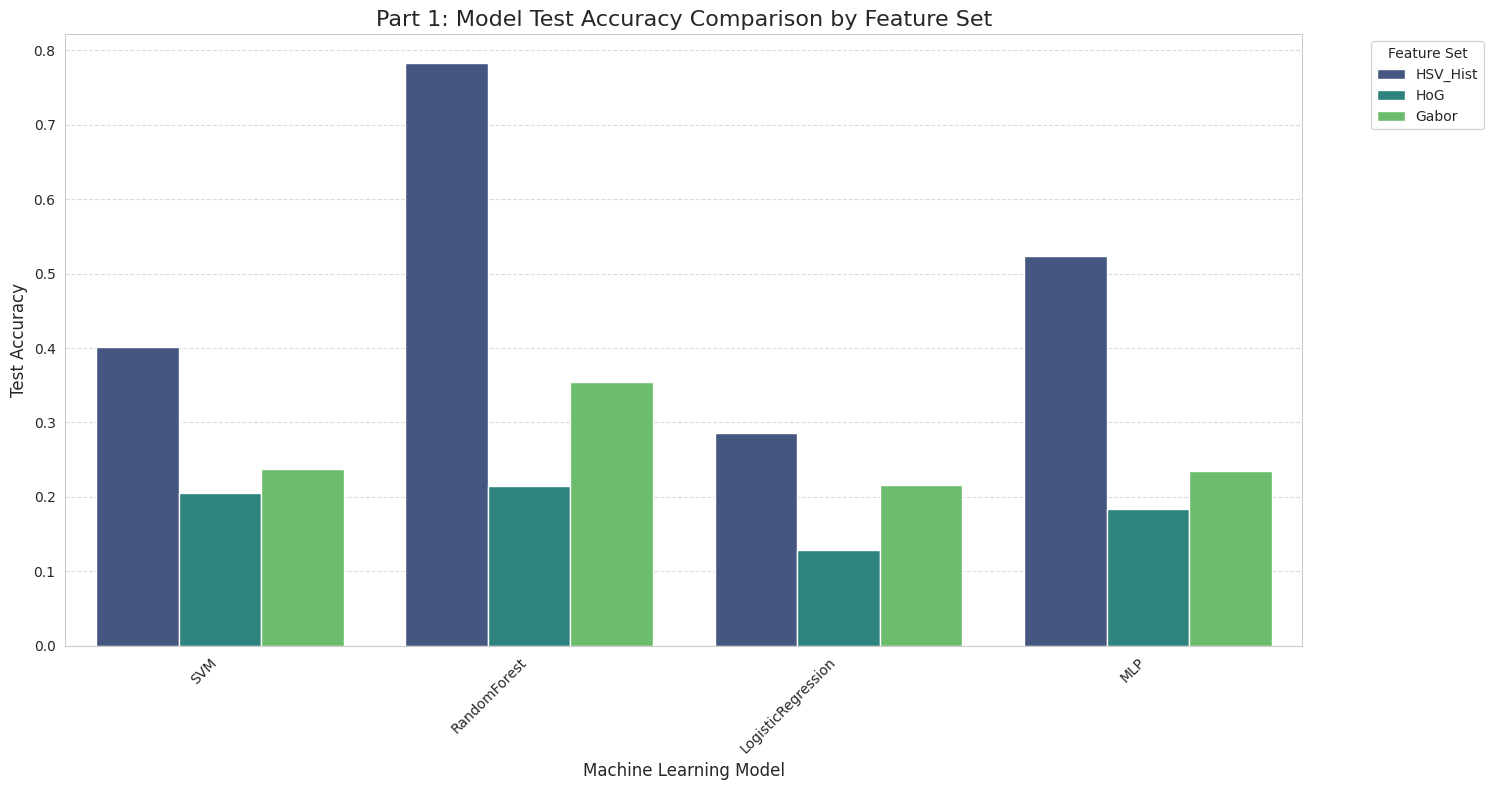

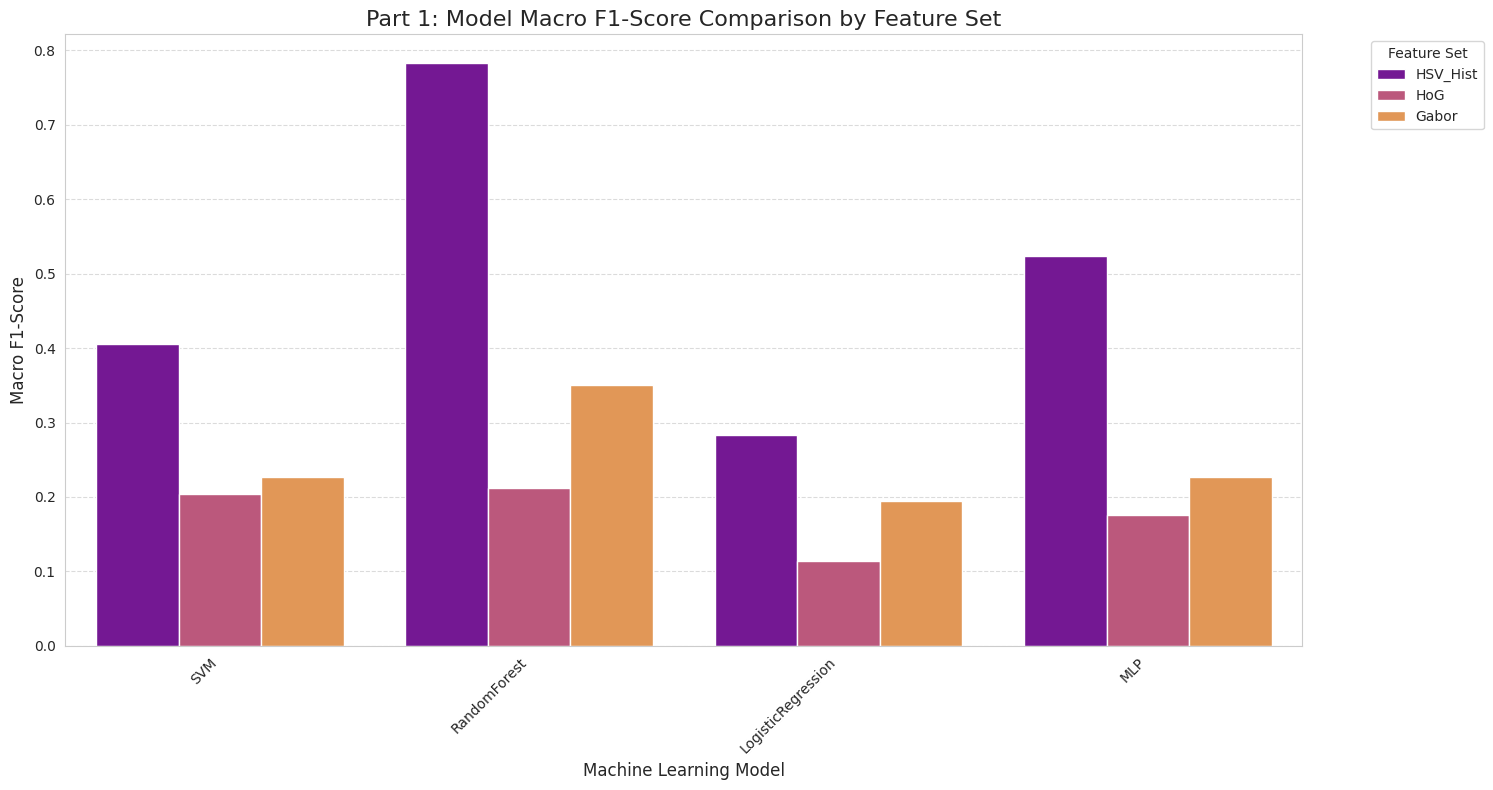

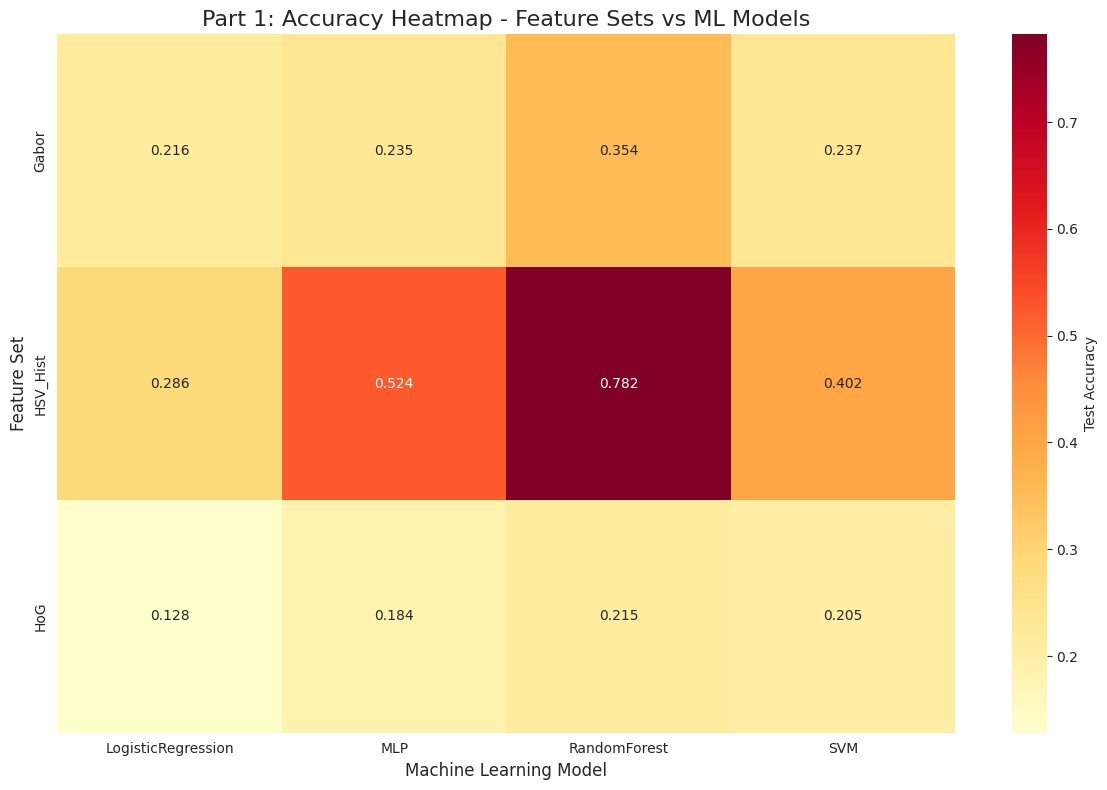


=== RESULTS DATAFRAME ===
   Feature Set            ML Model  Test Accuracy  Macro F1-Score
1     HSV_Hist        RandomForest       0.782133        0.782412
3     HSV_Hist                 MLP       0.523733        0.523301
0     HSV_Hist                 SVM       0.401600        0.405305
9        Gabor        RandomForest       0.353867        0.350872
2     HSV_Hist  LogisticRegression       0.286133        0.283848
8        Gabor                 SVM       0.237333        0.227376
11       Gabor                 MLP       0.234667        0.226939
10       Gabor  LogisticRegression       0.216000        0.194051
5          HoG        RandomForest       0.214667        0.212093
4          HoG                 SVM       0.205067        0.204267
7          HoG                 MLP       0.183733        0.175714
6          HoG  LogisticRegression       0.128267        0.114370


In [72]:
# --- Visualization of Results ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

if part1_results:
    # Create DataFrame from results for visualization
    data_for_plot = []

    for key, result in part1_results.items():
        if isinstance(result, dict) and "accuracy" in result:
            # Split the key to get feature name and model name
            parts = key.split('_')
            if len(parts) >= 2:
                # Handle cases where feature name might have underscores (like HSV_Hist)
                if parts[0] == 'HSV' and len(parts) > 2:
                    feature_name = 'HSV_Hist'
                    model_name = '_'.join(parts[2:])
                else:
                    feature_name = parts[0]
                    model_name = '_'.join(parts[1:])

                accuracy = result["accuracy"]

                # Get macro F1 if available
                macro_f1 = None
                if ("classification_report_dict" in result and
                    isinstance(result["classification_report_dict"], dict) and
                    "macro avg" in result["classification_report_dict"]):
                    macro_f1 = result["classification_report_dict"]["macro avg"]["f1-score"]

                data_for_plot.append({
                    'Feature Set': feature_name,
                    'ML Model': model_name,
                    'Test Accuracy': accuracy,
                    'Macro F1-Score': macro_f1 if macro_f1 is not None else 0
                })

    if data_for_plot:
        # Create DataFrame
        df_results_part1 = pd.DataFrame(data_for_plot)

        # Create the accuracy comparison chart
        plt.figure(figsize=(15, 8))
        sns.barplot(x="ML Model", y="Test Accuracy", hue="Feature Set",
                   data=df_results_part1, palette="viridis")
        plt.title("Part 1: Model Test Accuracy Comparison by Feature Set", fontsize=16)
        plt.ylabel("Test Accuracy", fontsize=12)
        plt.xlabel("Machine Learning Model", fontsize=12)
        plt.xticks(rotation=45, ha="right")
        plt.legend(title="Feature Set", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Create a second chart for F1-Score comparison
        plt.figure(figsize=(15, 8))
        sns.barplot(x="ML Model", y="Macro F1-Score", hue="Feature Set",
                   data=df_results_part1, palette="plasma")
        plt.title("Part 1: Model Macro F1-Score Comparison by Feature Set", fontsize=16)
        plt.ylabel("Macro F1-Score", fontsize=12)
        plt.xlabel("Machine Learning Model", fontsize=12)
        plt.xticks(rotation=45, ha="right")
        plt.legend(title="Feature Set", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Create a heatmap for better comparison
        plt.figure(figsize=(12, 8))

        # Pivot the data for heatmap
        heatmap_data = df_results_part1.pivot(index="Feature Set",
                                             columns="ML Model",
                                             values="Test Accuracy")

        sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.3f',
                   cbar_kws={'label': 'Test Accuracy'})
        plt.title("Part 1: Accuracy Heatmap - Feature Sets vs ML Models", fontsize=16)
        plt.xlabel("Machine Learning Model", fontsize=12)
        plt.ylabel("Feature Set", fontsize=12)
        plt.tight_layout()
        plt.show()

        # Print the DataFrame for reference
        print("\n=== RESULTS DATAFRAME ===")
        print(df_results_part1.sort_values('Test Accuracy', ascending=False))

    else:
        print("No valid results found for visualization.")

else:
    print("part1_results dictionary not found or is empty. Cannot generate comparison charts.")

## Part 2: Principal Component Analysis (PCA) and Feature Selection


### Part 2.1: Library Imports and Global Variables

In [73]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc
from multiprocessing import Pool


### Part 2.2: Feature Extraction Functions

In [74]:
# Basit feature extraction
def extract_features_simple(images, feature_func, feature_name):
    print(f"Extracting {feature_name} features...")
    start_time = time.time()
    
    features = []
    for img in images:
        features.append(feature_func(img))
    
    features_array = np.array(features)
    print(f"{feature_name} extraction completed in {time.time() - start_time:.2f} seconds")
    return features_array

# Helper function for parallel feature extraction
def extract_features_batch(args):
    images_batch, feature_func, batch_id, feature_name = args
    features = []
    for img in images_batch:
        feat = feature_func(img)
        features.append(feat)
    return batch_id, features

# Function to extract features in parallel
def extract_features_parallel(images, feature_func, feature_name, n_cores=12):
    n_images = len(images)
    batch_size = max(1, n_images // n_cores)
    batches = []
    
    for i in range(0, n_images, batch_size):
        batch = images[i:min(i + batch_size, n_images)]
        batches.append((batch, feature_func, len(batches), feature_name))
    
    print(f"Extracting {feature_name} features using {n_cores} cores...")
    start_time = time.time()
    
    with Pool(processes=n_cores) as pool:
        results = pool.map(extract_features_batch, batches)
    
    # Sort by batch_id and combine
    results.sort(key=lambda x: x[0])
    all_features = []
    for _, features in results:
        all_features.extend(features)
    
    features_array = np.array(all_features)
    print(f"{feature_name} extraction completed in {time.time() - start_time:.2f} seconds")
    return features_array

### Part 2.3: Feature Extraction and Displaying Plots

#### Part 2.3.1: Feature Extraction Process

In [75]:
# Extract all features in parallel
print("\n=== EXTRACTING ALL FEATURES (PARALLEL) ===")

# Use cores per feature type
hsv_train = extract_features_parallel(X_train_images_bgr, extract_hsv_histogram_single_image, "HSV_train", 1)
hsv_test = extract_features_parallel(X_test_images_bgr, extract_hsv_histogram_single_image, "HSV_test", 1)
hog_train = extract_features_parallel(X_train_images_bgr, extract_hog_features_single_image, "HoG_train", 1)
hog_test = extract_features_parallel(X_test_images_bgr, extract_hog_features_single_image, "HoG_test", 1)
gabor_train = extract_features_parallel(X_train_images_bgr, extract_gabor_features_single_image, "Gabor_train", 6)
gabor_test = extract_features_parallel(X_test_images_bgr, extract_gabor_features_single_image, "Gabor_test", 2)

# Combine features
print("\nCombining all features...")
X_train_all_features = np.hstack([hsv_train, hog_train, gabor_train])
X_test_all_features = np.hstack([hsv_test, hog_test, gabor_test])

print(f"\nCombined features shape - Train: {X_train_all_features.shape}, Test: {X_test_all_features.shape}")


=== EXTRACTING ALL FEATURES (PARALLEL) ===
Extracting HSV_train features using 1 cores...
HSV_train extraction completed in 1.02 seconds
Extracting HSV_test features using 1 cores...
HSV_test extraction completed in 0.25 seconds
Extracting HoG_train features using 1 cores...
HoG_train extraction completed in 6.53 seconds
Extracting HoG_test features using 1 cores...
HoG_test extraction completed in 0.93 seconds
Extracting Gabor_train features using 6 cores...
Gabor_train extraction completed in 58.38 seconds
Extracting Gabor_test features using 2 cores...
Gabor_test extraction completed in 19.86 seconds

Combining all features...

Combined features shape - Train: (30000, 180), Test: (3750, 180)


#### Part 2.3.2: Displaying Graphs

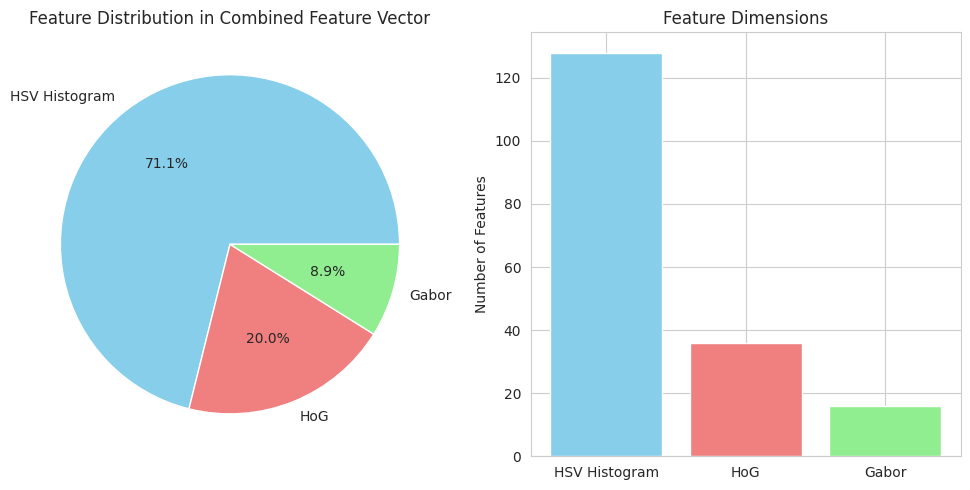

In [76]:
# Feature boyutlarını görselleştir
plt.figure(figsize=(10, 5))
feature_sizes = [hsv_train.shape[1], hog_train.shape[1], gabor_train.shape[1]]
feature_names = ['HSV Histogram', 'HoG', 'Gabor']
colors = ['skyblue', 'lightcoral', 'lightgreen']

plt.subplot(1, 2, 1)
plt.pie(feature_sizes, labels=feature_names, colors=colors, autopct='%1.1f%%')
plt.title('Feature Distribution in Combined Feature Vector')

plt.subplot(1, 2, 2)
plt.bar(feature_names, feature_sizes, color=colors)
plt.ylabel('Number of Features')
plt.title('Feature Dimensions')
plt.tight_layout()
plt.show()

### Part 2.4: PCA Analysis and Training

In [77]:
# Get models
ml_models_part2 = get_ml_models()

# Dictionary to store results
part2_results = {}
pca_results_for_comparison = {}
fs_results_for_comparison = {}

print("\n=== PHASE 1: APPLYING PCA ===")
# PCA with different variance ratios
scaler = StandardScaler()
pca_variances = [0.95, 0.90, 0.85]

for idx, variance in enumerate(pca_variances):
    print(f"\n--- PCA with {variance*100:.0f}% variance ---")
    
    # Apply PCA
    pca = PCA(n_components=variance, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train_all_features)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(scaler.transform(X_test_all_features))
    
    print(f"Original features: {X_train_all_features.shape[1]} -> PCA components: {pca.n_components_}")
    print(f"Actual variance retained: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")
    
    # Train models for this PCA configuration
    variance_results = {}
    for model_name, model in ml_models_part2.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
        
        start_time = time.time()
        pipeline.fit(X_train_pca, y_train_final)
        train_time = time.time() - start_time
        
        y_pred = pipeline.predict(X_test_pca)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test_final, y_pred)
        precision = precision_score(y_test_final, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test_final, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test_final, y_pred, average='macro', zero_division=0)
        
        result_key = f"PCA_{int(variance*100)}_{model_name}"
        result = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'train_time': train_time
        }
        part2_results[result_key] = result
        variance_results[model_name] = accuracy
        
        print(f"{model_name}: Accuracy = {accuracy:.4f}")
    
    pca_results_for_comparison[f'PCA_{int(variance*100)}'] = variance_results


=== PHASE 1: APPLYING PCA ===

--- PCA with 95% variance ---
Original features: 180 -> PCA components: 135
Actual variance retained: 95.13%


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM: Accuracy = 0.4659
RandomForest: Accuracy = 0.5880
LogisticRegression: Accuracy = 0.3448
MLP: Accuracy = 0.4651

--- PCA with 90% variance ---
Original features: 180 -> PCA components: 113
Actual variance retained: 90.22%


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM: Accuracy = 0.4696
RandomForest: Accuracy = 0.5891
LogisticRegression: Accuracy = 0.3360
MLP: Accuracy = 0.4736

--- PCA with 85% variance ---
Original features: 180 -> PCA components: 95
Actual variance retained: 85.01%


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM: Accuracy = 0.4643
RandomForest: Accuracy = 0.5912
LogisticRegression: Accuracy = 0.3280
MLP: Accuracy = 0.4685


### Part 2.5: PCA Variance Visualization and PCA Results Comparison Graph

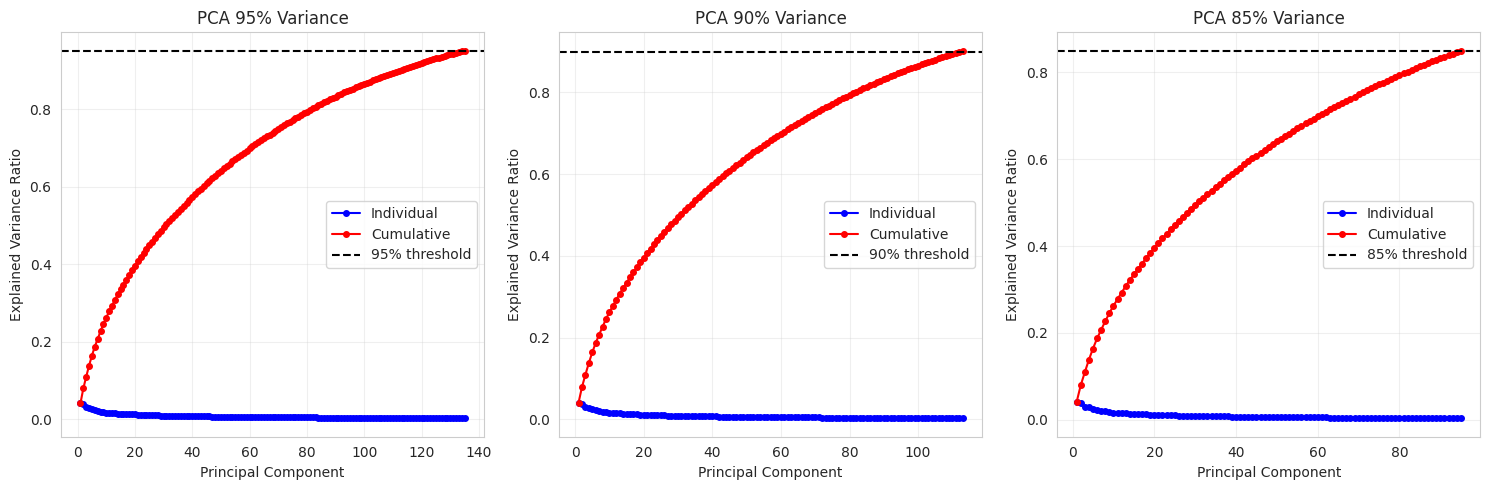

In [78]:
# PCA Variance Explanation Visualization
plt.figure(figsize=(15, 5))

for idx, variance in enumerate(pca_variances):
    # Re-apply PCA for visualization
    pca = PCA(n_components=variance, random_state=42)
    pca.fit(scaler.fit_transform(X_train_all_features))
    
    # Variance plot
    plt.subplot(1, 3, idx+1)
    cumsum_var = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
            pca.explained_variance_ratio_, 'bo-', label='Individual', markersize=4)
    plt.plot(range(1, len(cumsum_var) + 1),
            cumsum_var, 'ro-', label='Cumulative', markersize=4)
    plt.axhline(y=variance, color='k', linestyle='--', label=f'{variance*100:.0f}% threshold')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title(f'PCA {variance*100:.0f}% Variance')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



<Figure size 1200x600 with 0 Axes>

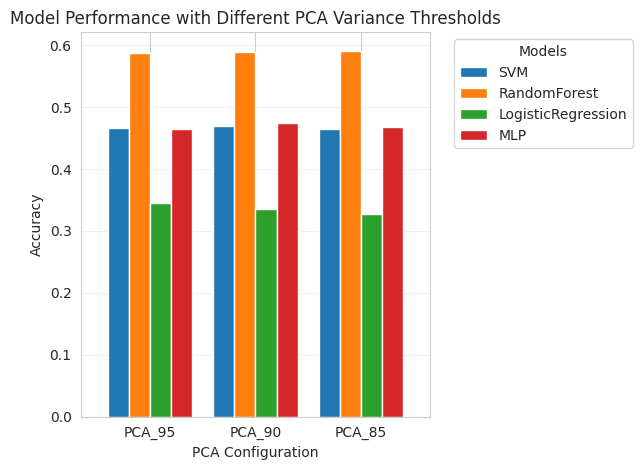

In [79]:
# PCA Results Comparison
plt.figure(figsize=(12, 6))
pca_df = pd.DataFrame(pca_results_for_comparison)
pca_df = pca_df.T
pca_df.plot(kind='bar', width=0.8)
plt.xlabel('PCA Configuration')
plt.ylabel('Accuracy')
plt.title('Model Performance with Different PCA Variance Thresholds')
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Part 2.7: Feature Selection - Mutual Information

In [80]:
print("\n=== PHASE 2: APPLYING FEATURE SELECTION ===")

# Feature selection methods
feature_percentages = [0.75, 0.50, 0.25]

# Mutual Information Feature Selection
print("\n--- Feature Selection using mutual_info ---")

for percentage in feature_percentages:
    k = int(X_train_all_features.shape[1] * percentage)
    print(f"\nSelecting {percentage*100:.0f}% features ({k} features)...")
    
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_all_features, y_train_final)
    X_test_selected = selector.transform(X_test_all_features)
    
    # Train models
    mi_results = {}
    for model_name, model in ml_models_part2.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
        
        start_time = time.time()
        pipeline.fit(X_train_selected, y_train_final)
        train_time = time.time() - start_time
        
        y_pred = pipeline.predict(X_test_selected)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test_final, y_pred)
        precision = precision_score(y_test_final, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test_final, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test_final, y_pred, average='macro', zero_division=0)
        
        result_key = f"mutual_info_{int(percentage*100)}_{model_name}"
        part2_results[result_key] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'train_time': train_time
        }
        mi_results[model_name] = accuracy
        
        print(f"{model_name}: Accuracy = {accuracy:.4f}")
    
    fs_results_for_comparison[f'MI_{int(percentage*100)}'] = mi_results


=== PHASE 2: APPLYING FEATURE SELECTION ===

--- Feature Selection using mutual_info ---

Selecting 75% features (135 features)...


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM: Accuracy = 0.5035
RandomForest: Accuracy = 0.7000
LogisticRegression: Accuracy = 0.3597
MLP: Accuracy = 0.4904

Selecting 50% features (90 features)...


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM: Accuracy = 0.4955
RandomForest: Accuracy = 0.7208
LogisticRegression: Accuracy = 0.3416
MLP: Accuracy = 0.4901

Selecting 25% features (45 features)...


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM: Accuracy = 0.4277
RandomForest: Accuracy = 0.6829
LogisticRegression: Accuracy = 0.3019
MLP: Accuracy = 0.4533


#### Part 2.7.2 Feature Selection - F-test

In [81]:
# F-test Feature Selection
print("\n--- Feature Selection using f_classif ---")

for percentage in feature_percentages:
    k = int(X_train_all_features.shape[1] * percentage)
    print(f"\nSelecting {percentage*100:.0f}% features ({k} features)...")
    
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_all_features, y_train_final)
    X_test_selected = selector.transform(X_test_all_features)
    
    # Train models
    f_results = {}
    for model_name, model in ml_models_part2.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
        
        start_time = time.time()
        pipeline.fit(X_train_selected, y_train_final)
        train_time = time.time() - start_time
        
        y_pred = pipeline.predict(X_test_selected)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test_final, y_pred)
        precision = precision_score(y_test_final, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test_final, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test_final, y_pred, average='macro', zero_division=0)
        
        result_key = f"f_classif_{int(percentage*100)}_{model_name}"
        part2_results[result_key] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'train_time': train_time
        }
        f_results[model_name] = accuracy
        
        print(f"{model_name}: Accuracy = {accuracy:.4f}")
    
    fs_results_for_comparison[f'F-test_{int(percentage*100)}'] = f_results


--- Feature Selection using f_classif ---

Selecting 75% features (135 features)...


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM: Accuracy = 0.4997
RandomForest: Accuracy = 0.6963
LogisticRegression: Accuracy = 0.3619
MLP: Accuracy = 0.4893

Selecting 50% features (90 features)...


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM: Accuracy = 0.4717
RandomForest: Accuracy = 0.6760
LogisticRegression: Accuracy = 0.3469
MLP: Accuracy = 0.4797

Selecting 25% features (45 features)...


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM: Accuracy = 0.3621
RandomForest: Accuracy = 0.5427
LogisticRegression: Accuracy = 0.2920
MLP: Accuracy = 0.3776


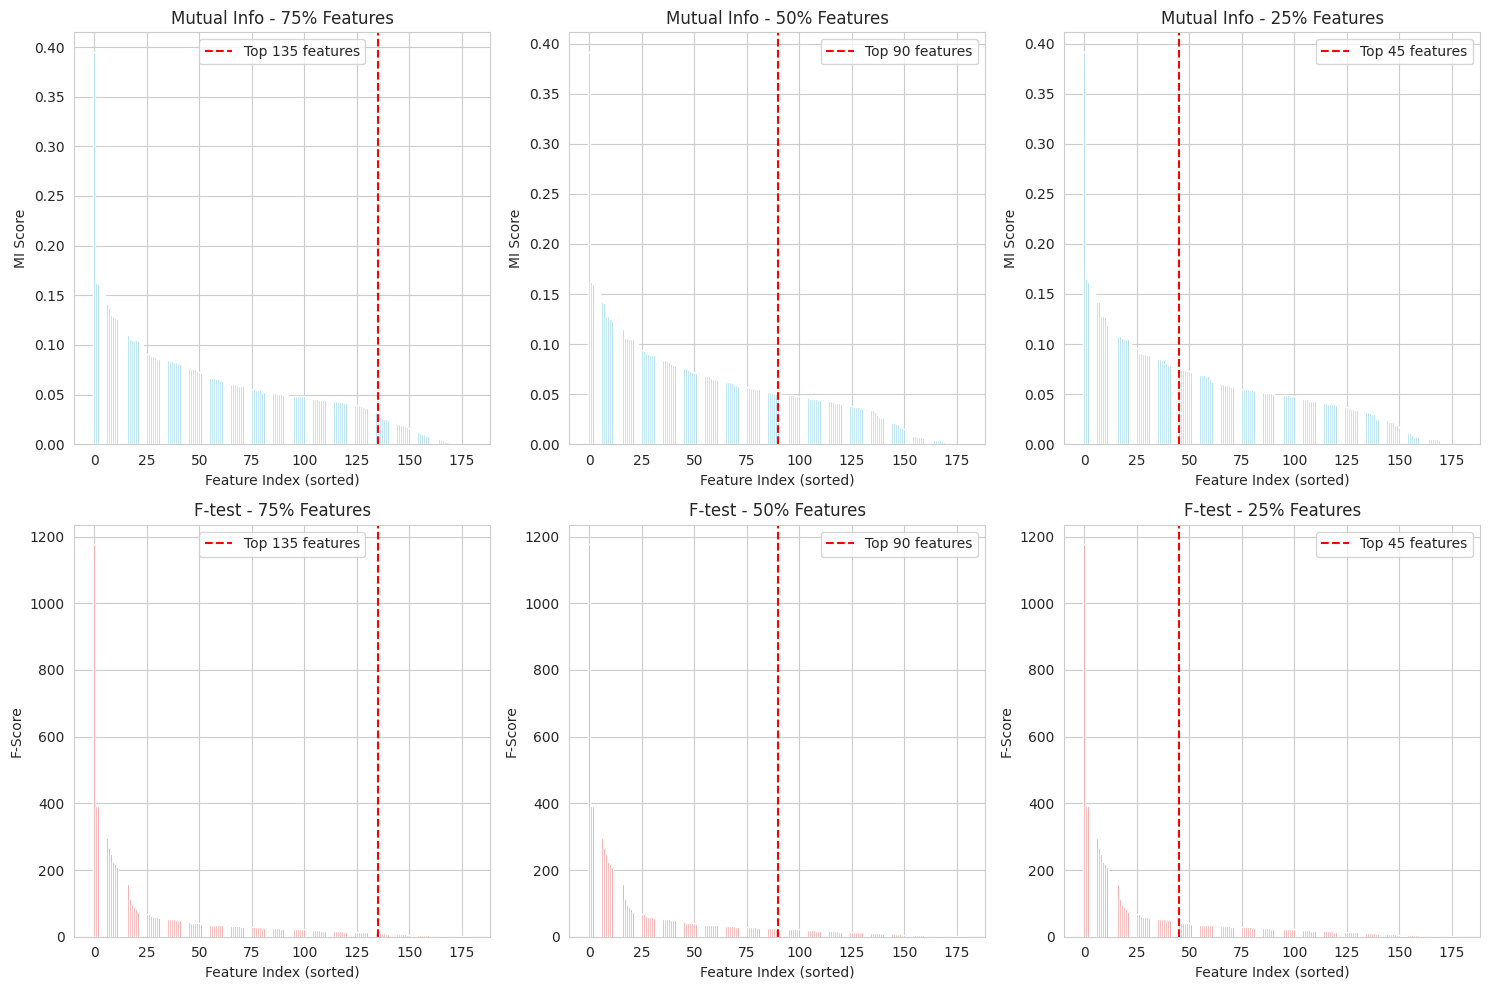

In [82]:
# Feature Selection Score Visualization
plt.figure(figsize=(15, 10))
plot_idx = 1

# Mutual Information scores
for percentage in feature_percentages:
    k = int(X_train_all_features.shape[1] * percentage)
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    selector.fit(X_train_all_features, y_train_final)
    
    plt.subplot(2, 3, plot_idx)
    scores = selector.scores_
    indices = np.argsort(scores)[::-1]
    plt.bar(range(len(scores)), scores[indices], color='skyblue')
    plt.axvline(x=k, color='red', linestyle='--', label=f'Top {k} features')
    plt.xlabel('Feature Index (sorted)')
    plt.ylabel('MI Score')
    plt.title(f'Mutual Info - {percentage*100:.0f}% Features')
    plt.legend()
    plot_idx += 1

# F-test scores
for percentage in feature_percentages:
    k = int(X_train_all_features.shape[1] * percentage)
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_train_all_features, y_train_final)
    
    plt.subplot(2, 3, plot_idx)
    scores = selector.scores_
    indices = np.argsort(scores)[::-1]
    plt.bar(range(len(scores)), scores[indices], color='lightcoral')
    plt.axvline(x=k, color='red', linestyle='--', label=f'Top {k} features')
    plt.xlabel('Feature Index (sorted)')
    plt.ylabel('F-Score')
    plt.title(f'F-test - {percentage*100:.0f}% Features')
    plt.legend()
    plot_idx += 1

plt.tight_layout()
plt.show()


=== COMPREHENSIVE RESULTS COMPARISON ===


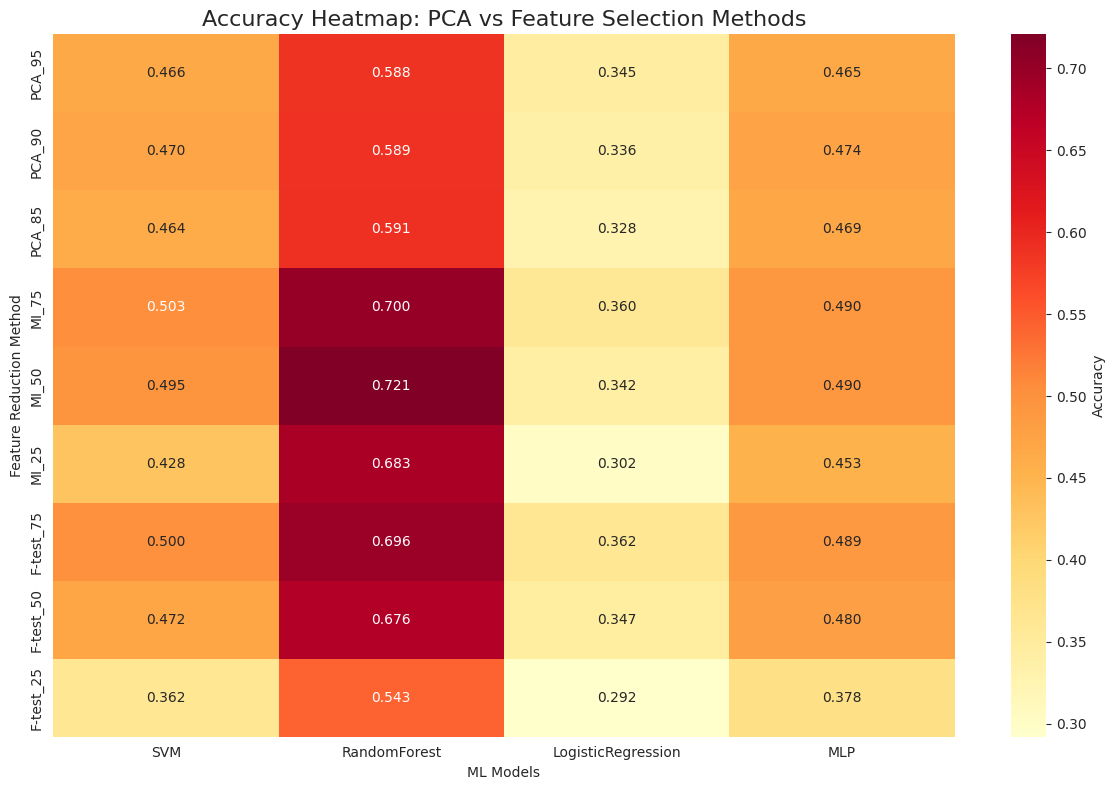

In [83]:
print("\n=== COMPREHENSIVE RESULTS COMPARISON ===")

# Create comprehensive comparison DataFrame
all_methods_results = {}
all_methods_results.update(pca_results_for_comparison)
all_methods_results.update(fs_results_for_comparison)

comparison_df = pd.DataFrame(all_methods_results).T

# Heatmap of all results
plt.figure(figsize=(12, 8))
sns.heatmap(comparison_df, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Accuracy'})
plt.title('Accuracy Heatmap: PCA vs Feature Selection Methods', fontsize=16)
plt.xlabel('ML Models')
plt.ylabel('Feature Reduction Method')
plt.tight_layout()
plt.show()

### Part : Comparisons

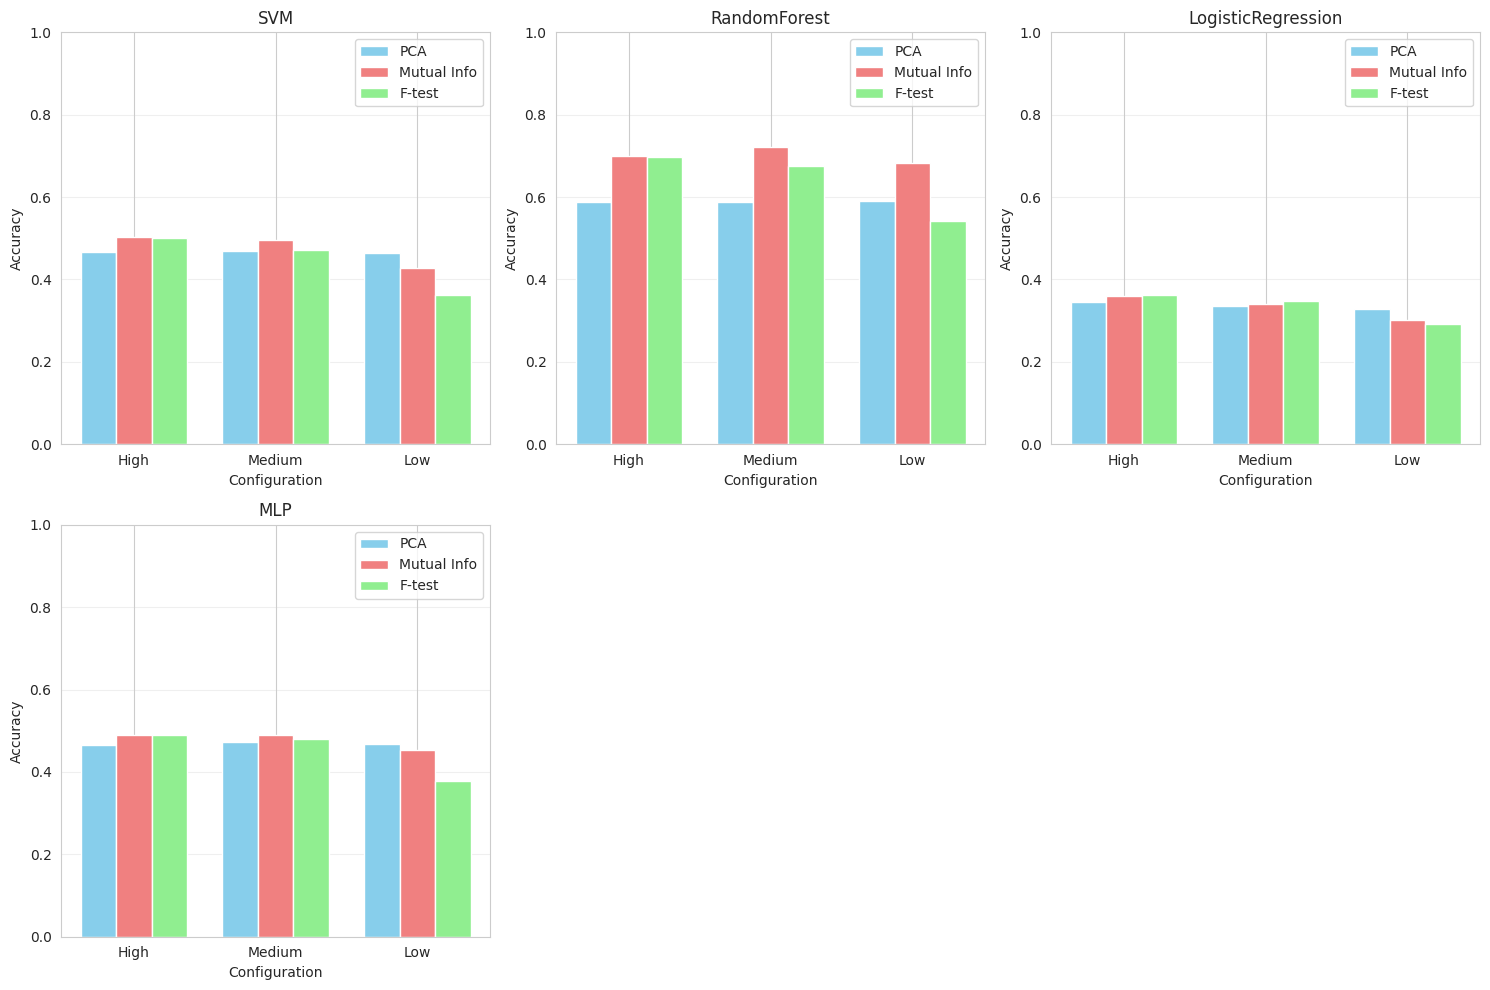

In [84]:
# Method comparison by model
plt.figure(figsize=(15, 10))

models = list(ml_models_part2.keys())
for i, model_name in enumerate(models):
    plt.subplot(2, 3, i+1)
    
    # Extract results for this model
    pca_results = [comparison_df.loc[f'PCA_{v}', model_name] for v in [95, 90, 85]]
    mi_results = [comparison_df.loc[f'MI_{v}', model_name] for v in [75, 50, 25]]
    f_results = [comparison_df.loc[f'F-test_{v}', model_name] for v in [75, 50, 25]]
    
    x = np.arange(3)
    width = 0.25
    
    plt.bar(x - width, pca_results, width, label='PCA', color='skyblue')
    plt.bar(x, mi_results, width, label='Mutual Info', color='lightcoral')
    plt.bar(x + width, f_results, width, label='F-test', color='lightgreen')
    
    plt.xlabel('Configuration')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name}')
    plt.xticks(x, ['High', 'Medium', 'Low'])
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [85]:
# Create detailed results DataFrame
detailed_results = []
for key, result in part2_results.items():
    parts = key.split('_')
    if 'PCA' in key:
        method = 'PCA'
        param = parts[1]
        model = '_'.join(parts[2:])
    elif 'mutual' in key:
        method = 'Mutual Info'
        param = parts[2]
        model = '_'.join(parts[3:])
    else:
        method = 'F-test'
        param = parts[2]
        model = '_'.join(parts[3:])
    
    detailed_results.append({
        'Method': method,
        'Parameter': param,
        'Model': model,
        'Accuracy': result['accuracy'],
        'Precision': result['precision'],
        'Recall': result['recall'],
        'F1-Score': result['f1_score']
    })

detailed_df = pd.DataFrame(detailed_results)

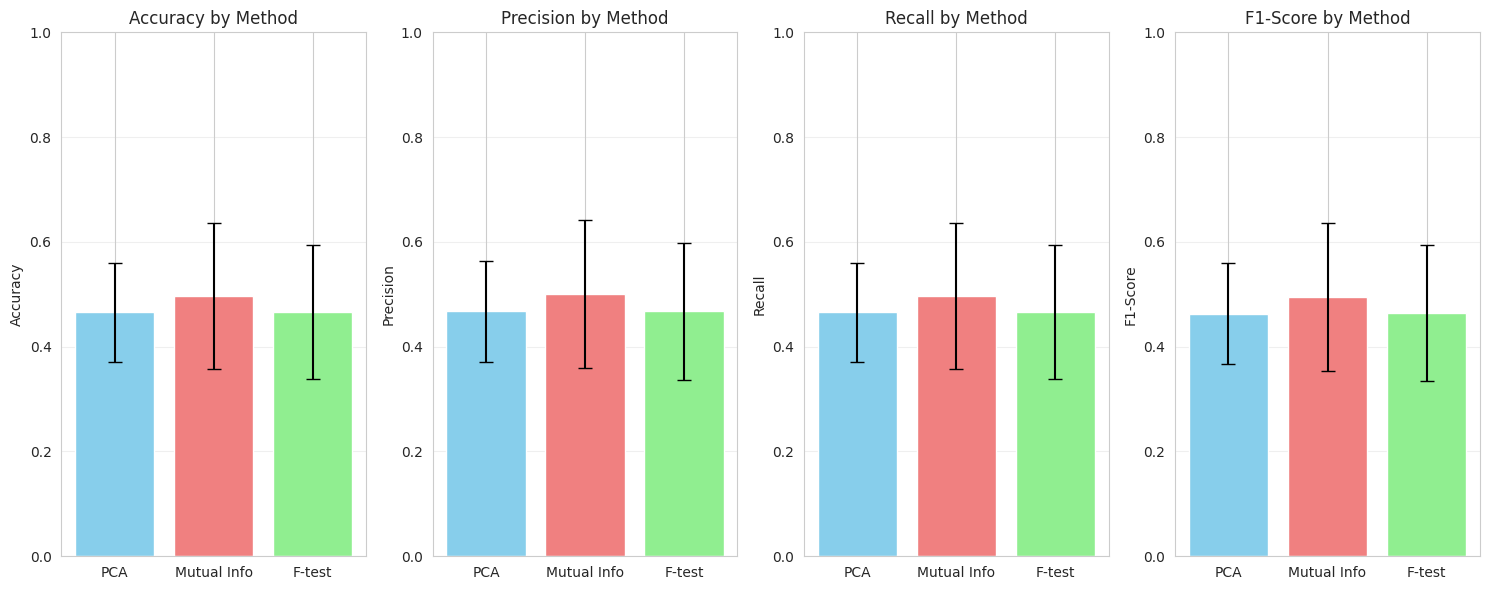

In [86]:
# Metrics comparison plot
plt.figure(figsize=(15, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
method_types = ['PCA', 'Mutual Info', 'F-test']

for i, metric in enumerate(metrics):
    plt.subplot(1, 4, i+1)
    
    method_means = []
    method_stds = []
    
    for method in method_types:
        method_data = detailed_df[detailed_df['Method'] == method][metric]
        method_means.append(method_data.mean())
        method_stds.append(method_data.std())
    
    plt.bar(method_types, method_means, yerr=method_stds, capsize=5,
            color=['skyblue', 'lightcoral', 'lightgreen'])
    plt.ylabel(metric)
    plt.title(f'{metric} by Method')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [87]:
print("\n=== BEST CONFIGURATIONS ANALYSIS ===")

# Find best result for each method
best_by_method = detailed_df.loc[detailed_df.groupby('Method')['Accuracy'].idxmax()]
print("\nBest configuration for each method:")
print(best_by_method[['Method', 'Parameter', 'Model', 'Accuracy']])

# Overall best result
best_overall = detailed_df.loc[detailed_df['Accuracy'].idxmax()]
print(f"\n🏆 Best Overall Configuration:")
print(f"   Method: {best_overall['Method']}")
print(f"   Parameter: {best_overall['Parameter']}%")
print(f"   Model: {best_overall['Model']}")
print(f"   Accuracy: {best_overall['Accuracy']:.4f}")
print(f"   Precision: {best_overall['Precision']:.4f}")
print(f"   Recall: {best_overall['Recall']:.4f}")
print(f"   F1-Score: {best_overall['F1-Score']:.4f}")


=== BEST CONFIGURATIONS ANALYSIS ===

Best configuration for each method:
         Method Parameter         Model  Accuracy
25       F-test        75  RandomForest  0.696267
17  Mutual Info        50  RandomForest  0.720800
9           PCA        85  RandomForest  0.591200

🏆 Best Overall Configuration:
   Method: Mutual Info
   Parameter: 50%
   Model: RandomForest
   Accuracy: 0.7208
   Precision: 0.7242
   Recall: 0.7208
   F1-Score: 0.7206


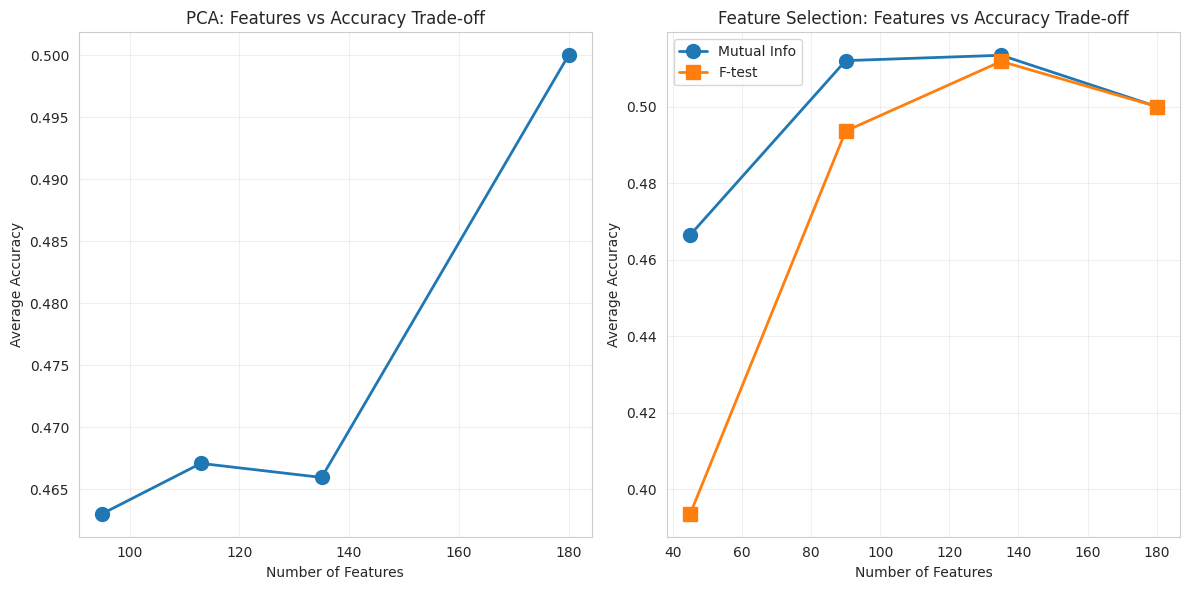

In [88]:
# Dimensionality reduction effect visualization
plt.figure(figsize=(12, 6))

# PCA dimensionality reduction
plt.subplot(1, 2, 1)
original_dim = X_train_all_features.shape[1]
pca_dims = []
pca_accuracies = []

for v in [95, 90, 85]:
    pca_temp = PCA(n_components=v/100, random_state=42)
    pca_temp.fit(scaler.fit_transform(X_train_all_features))
    pca_dims.append(pca_temp.n_components_)
    # Get average accuracy for this PCA configuration
    pca_acc = detailed_df[(detailed_df['Method'] == 'PCA') & 
                         (detailed_df['Parameter'] == str(v))]['Accuracy'].mean()
    pca_accuracies.append(pca_acc)

plt.plot([original_dim] + pca_dims, [0.5] + pca_accuracies, 'o-', markersize=10, linewidth=2)
plt.xlabel('Number of Features')
plt.ylabel('Average Accuracy')
plt.title('PCA: Features vs Accuracy Trade-off')
plt.grid(True, alpha=0.3)

# Feature Selection dimensionality reduction
plt.subplot(1, 2, 2)
fs_dims = [int(original_dim * p / 100) for p in [75, 50, 25]]
mi_accuracies = []
f_accuracies = []

for p in [75, 50, 25]:
    mi_acc = detailed_df[(detailed_df['Method'] == 'Mutual Info') & 
                        (detailed_df['Parameter'] == str(p))]['Accuracy'].mean()
    mi_accuracies.append(mi_acc)
    
    f_acc = detailed_df[(detailed_df['Method'] == 'F-test') & 
                       (detailed_df['Parameter'] == str(p))]['Accuracy'].mean()
    f_accuracies.append(f_acc)

plt.plot([original_dim] + fs_dims, [0.5] + mi_accuracies, 'o-', 
         markersize=10, linewidth=2, label='Mutual Info')
plt.plot([original_dim] + fs_dims, [0.5] + f_accuracies, 's-', 
         markersize=10, linewidth=2, label='F-test')
plt.xlabel('Number of Features')
plt.ylabel('Average Accuracy')
plt.title('Feature Selection: Features vs Accuracy Trade-off')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

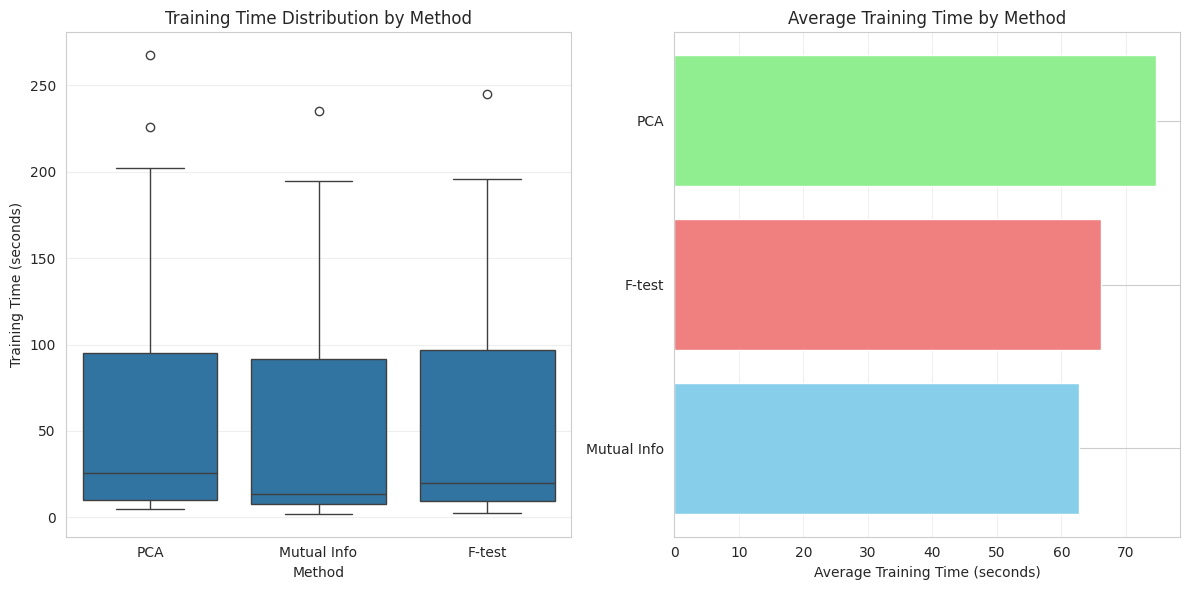

In [89]:
# Training time analysis
plt.figure(figsize=(12, 6))

# Extract training times
time_data = []
for key, result in part2_results.items():
    parts = key.split('_')
    if 'PCA' in key:
        method = 'PCA'
    elif 'mutual' in key:
        method = 'Mutual Info'
    else:
        method = 'F-test'
    
    time_data.append({
        'Method': method,
        'Time': result['train_time']
    })

time_df = pd.DataFrame(time_data)

plt.subplot(1, 2, 1)
sns.boxplot(x='Method', y='Time', data=time_df)
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Distribution by Method')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
method_time_means = time_df.groupby('Method')['Time'].mean().sort_values()
plt.barh(method_time_means.index, method_time_means.values, 
         color=['skyblue', 'lightcoral', 'lightgreen'])
plt.xlabel('Average Training Time (seconds)')
plt.title('Average Training Time by Method')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


=== COMPARISON WITH PART 1 ===


/tmp/ipykernel_20406/724028308.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['Part 1', 'Part 2'])


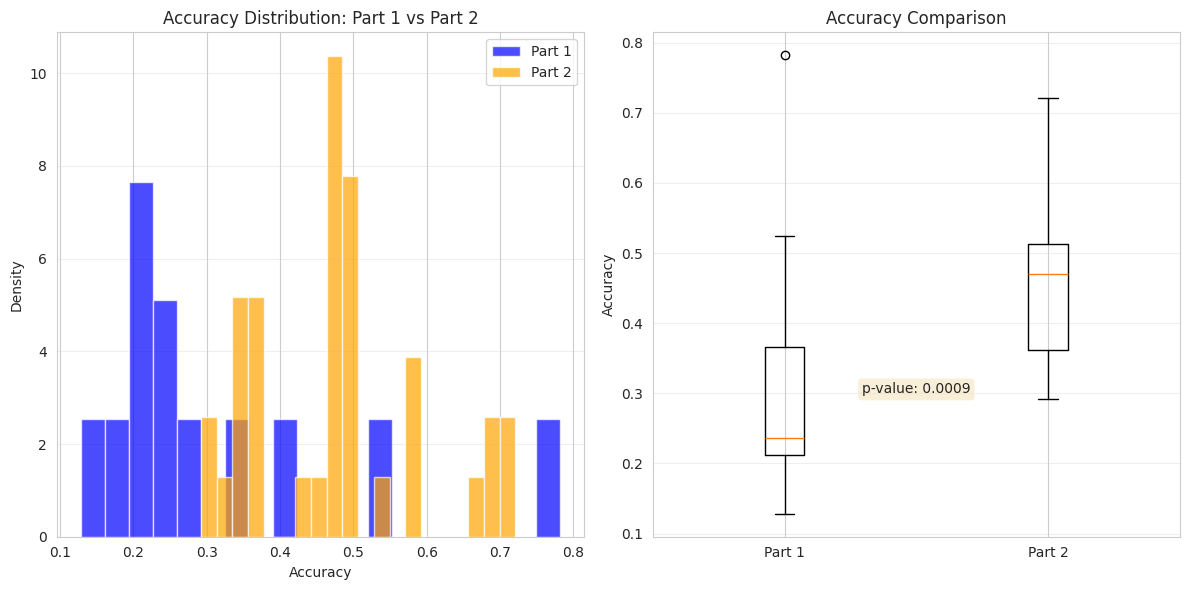


Part 1 - Mean Accuracy: 0.3139 ± 0.1752
Part 2 - Mean Accuracy: 0.4763 ± 0.1175
✅ Significant difference between Part 1 and Part 2 (p-value: 0.0009)


In [90]:
# Compare with Part 1 if available
if 'part1_results' in globals() and part1_results:
    print("\n=== COMPARISON WITH PART 1 ===")
    
    # Get Part 1 accuracies
    part1_accs = []
    for key, result in part1_results.items():
        if isinstance(result, dict) and 'accuracy' in result:
            part1_accs.append(result['accuracy'])
    
    # Get Part 2 accuracies
    part2_accs = detailed_df['Accuracy'].values
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(part1_accs, bins=20, alpha=0.7, label='Part 1', color='blue', density=True)
    plt.hist(part2_accs, bins=20, alpha=0.7, label='Part 2', color='orange', density=True)
    plt.xlabel('Accuracy')
    plt.ylabel('Density')
    plt.title('Accuracy Distribution: Part 1 vs Part 2')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    plt.subplot(1, 2, 2)
    data_to_plot = [part1_accs, part2_accs]
    plt.boxplot(data_to_plot, labels=['Part 1', 'Part 2'])
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')
    plt.grid(axis='y', alpha=0.3)
    
    # Add statistical comparison
    from scipy import stats
    t_stat, p_value = stats.ttest_ind(part1_accs, part2_accs)
    plt.text(1.5, 0.3, f'p-value: {p_value:.4f}', ha='center', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPart 1 - Mean Accuracy: {np.mean(part1_accs):.4f} ± {np.std(part1_accs):.4f}")
    print(f"Part 2 - Mean Accuracy: {np.mean(part2_accs):.4f} ± {np.std(part2_accs):.4f}")
    
    if p_value < 0.05:
        print(f"✅ Significant difference between Part 1 and Part 2 (p-value: {p_value:.4f})")
    else:
        print(f"❌ No significant difference between Part 1 and Part 2 (p-value: {p_value:.4f})")


=== FINAL SUMMARY TABLE ===
     Method Parameter        Model  Accuracy  Precision   Recall  F1-Score
Mutual Info        50 RandomForest  0.720800   0.724235 0.720800  0.720615
Mutual Info        75 RandomForest  0.700000   0.703239 0.700000  0.699627
     F-test        75 RandomForest  0.696267   0.701413 0.696267  0.695786
Mutual Info        25 RandomForest  0.682933   0.687127 0.682933  0.682491
     F-test        50 RandomForest  0.676000   0.677935 0.676000  0.674985
        PCA        85 RandomForest  0.591200   0.594026 0.591200  0.590483
        PCA        90 RandomForest  0.589067   0.595355 0.589067  0.588437
        PCA        95 RandomForest  0.588000   0.593692 0.588000  0.588296
     F-test        25 RandomForest  0.542667   0.547028 0.542667  0.541197
Mutual Info        75          SVM  0.503467   0.511349 0.503467  0.504372


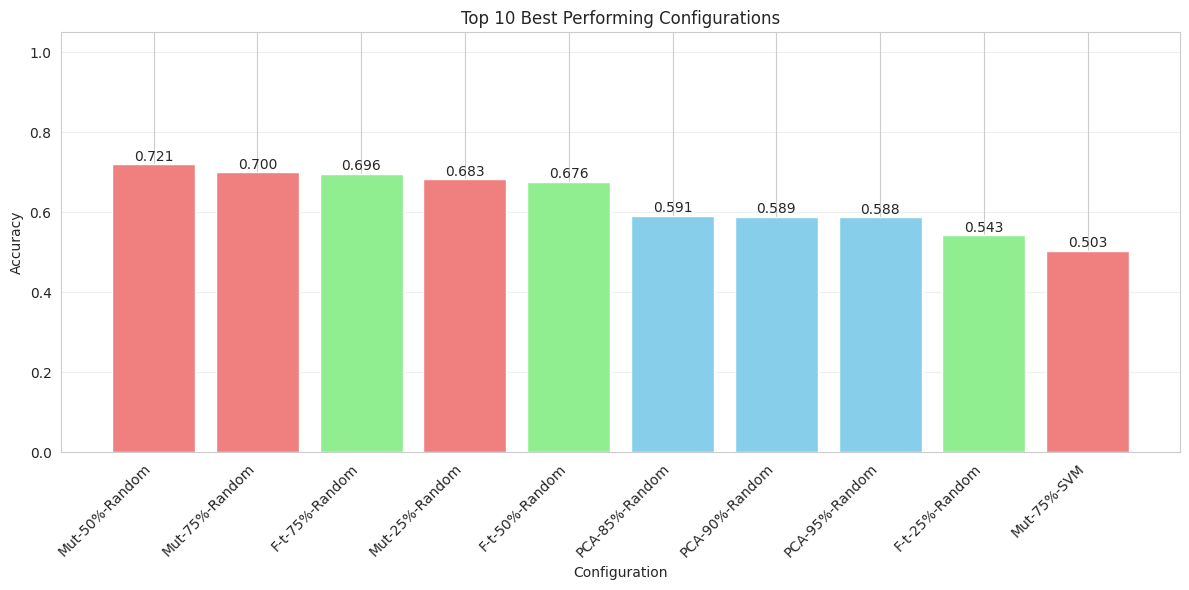


PART 2 COMPLETED
Total experiments conducted: 36
Best accuracy achieved: 0.7208


In [91]:
# Final Summary Visualization
print("\n=== FINAL SUMMARY TABLE ===")
summary_table = detailed_df.sort_values('Accuracy', ascending=False).head(10)
print(summary_table.to_string(index=False))

# Simple bar plot for top 10 results
plt.figure(figsize=(12, 6))

# Create short labels and colors
labels = [f"{row['Method'][:3]}-{row['Parameter']}%-{row['Model'][:6]}" 
          for _, row in summary_table.iterrows()]
colors = ['skyblue' if 'PCA' in m else 'lightcoral' if 'Mutual' in m else 'lightgreen' 
          for m in summary_table['Method']]

# Bar plot
bars = plt.bar(range(10), summary_table['Accuracy'], color=colors)

# Add values on bars
for bar, acc in zip(bars, summary_table['Accuracy']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{acc:.3f}', ha='center', va='bottom')

plt.xlabel('Configuration')
plt.ylabel('Accuracy')
plt.title('Top 10 Best Performing Configurations')
plt.xticks(range(10), labels, rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Save results
results_summary = {
    'detailed_results': detailed_df,
    'best_overall': best_overall.to_dict(),
    'method_comparison': comparison_df
}

print("\n" + "="*80)
print("PART 2 COMPLETED")
print(f"Total experiments conducted: {len(part2_results)}")
print(f"Best accuracy achieved: {best_overall['Accuracy']:.4f}")
print("="*80)

## Part 5:


X_train_cnn shape: (30000, 32, 32, 3)
y_train_cnn shape: (30000, 25)
X_val_cnn shape: (3750, 32, 32, 3)
y_val_cnn shape: (3750, 25)
X_test_cnn shape: (3750, 32, 32, 3)
y_test_cnn shape: (3750, 25)
Image dimensions: 32x32x3
Number of classes: 25


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 547,929 (2.09 MB)

 Trainable params: 547,481 (2.09 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
460/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1674 - loss: 3.0495

2025-05-30 23:38:24.246477: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.6 = (f32[48,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[48,3,32,32]{3,2,1,0} %bitcast.5601, f32[32,3,3,3]{3,2,1,0} %bitcast.5608, f32[32]{0} %bitcast.6421), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_2_1/convolution" source_file="/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-30 23:38:24.275227: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] O

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1687 - loss: 3.0413

2025-05-30 23:38:27.175477: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.6 = (f32[38,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[38,3,32,32]{3,2,1,0} %bitcast.632, f32[32,3,3,3]{3,2,1,0} %bitcast.639, f32[32]{0} %bitcast.641), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_2_1/convolution" source_file="/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-30 23:38:27.202620: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omit


Epoch 1: val_accuracy improved from -inf to 0.14107, saving model to best_custom_cnn_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.1689 - loss: 3.0404 - val_accuracy: 0.1411 - val_loss: 3.1285
Epoch 2/50
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4055 - loss: 1.9203
Epoch 2: val_accuracy improved from 0.14107 to 0.34933, saving model to best_custom_cnn_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4058 - loss: 1.9190 - val_accuracy: 0.3493 - val_loss: 2.2398
Epoch 3/50
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5066 - loss: 1.5954
Epoch 3: val_accuracy improved from 0.34933 to 0.52960, saving model to best_custom_cnn_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5067 - loss: 1.5950 - val_accuracy: 0.5296 - val_loss: 1.5403
Epoch 4/50
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5693 - loss: 1.3865
Epoch 4: val_accuracy improved from 0.52960 to 0.53387, saving model to best_custom_cnn_mod

2025-05-30 23:39:15.382792: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.6 = (f32[6,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,3,32,32]{3,2,1,0} %bitcast.632, f32[32,3,3,3]{3,2,1,0} %bitcast.639, f32[32]{0} %bitcast.641), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_2_1/convolution" source_file="/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-30 23:39:15.447900: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitte


Custom CNN Test Accuracy (Best Model): 60.80%
Custom CNN Test Loss (Best Model): 1.5386
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report for Custom CNN (Best Model):
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.60      0.68      0.64       150
      Brown-Headed-Barbet       0.43      0.43      0.43       150
             Cattle-Egret       0.77      0.67      0.72       150
        Common-Kingfisher       0.81      0.63      0.71       150
              Common-Myna       0.73      0.59      0.65       150
         Common-Rosefinch       0.52      0.41      0.46       150
        Common-Tailorbird       0.35      0.48      0.40       150
       Coppersmith-Barbet       0.49      0.56      0.52       150
           Forest-Wagtail       0.64      0.59      0.61       150
             Gray-Wagtail       0.51      0.67      0.58       150
                   Hoopoe       0.78      0.58      0.66       150
             

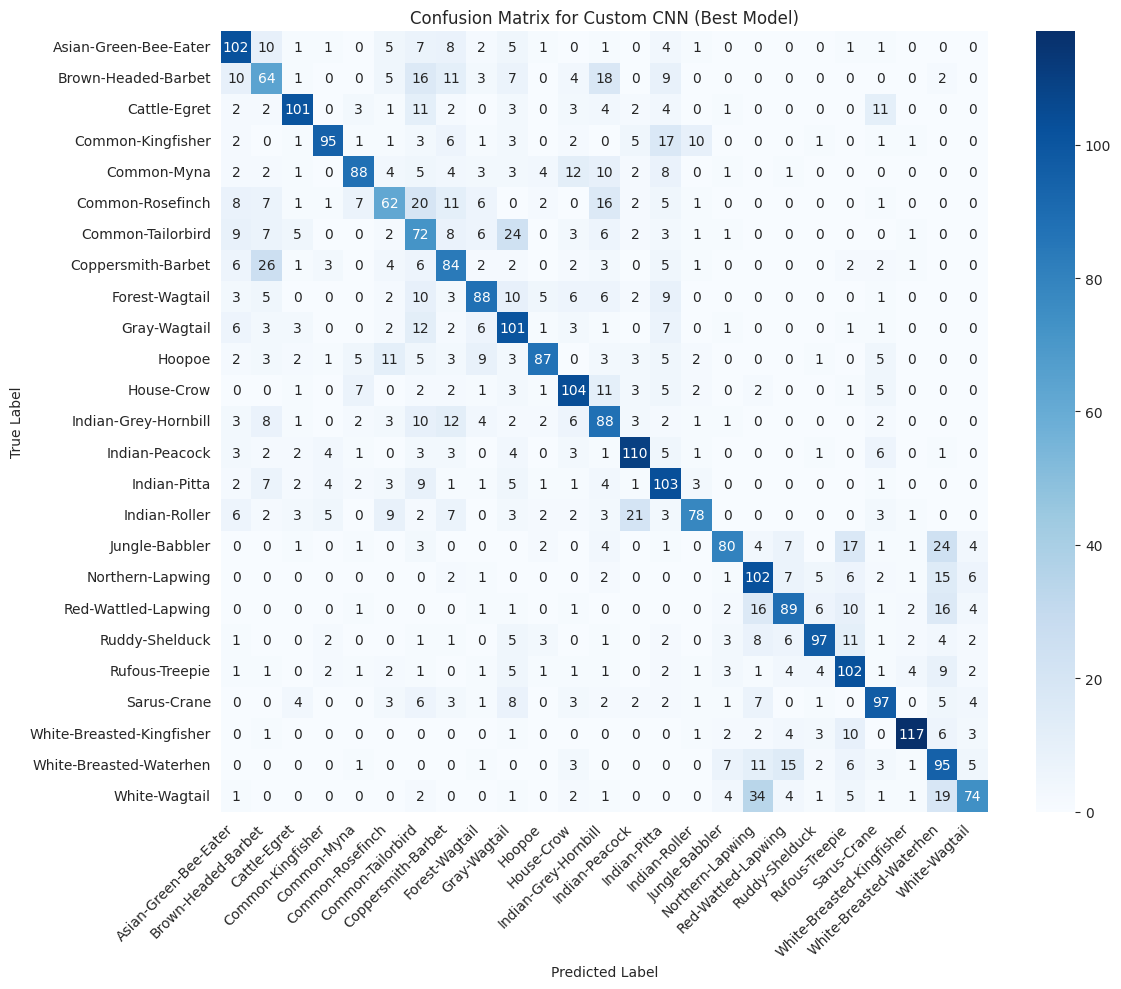

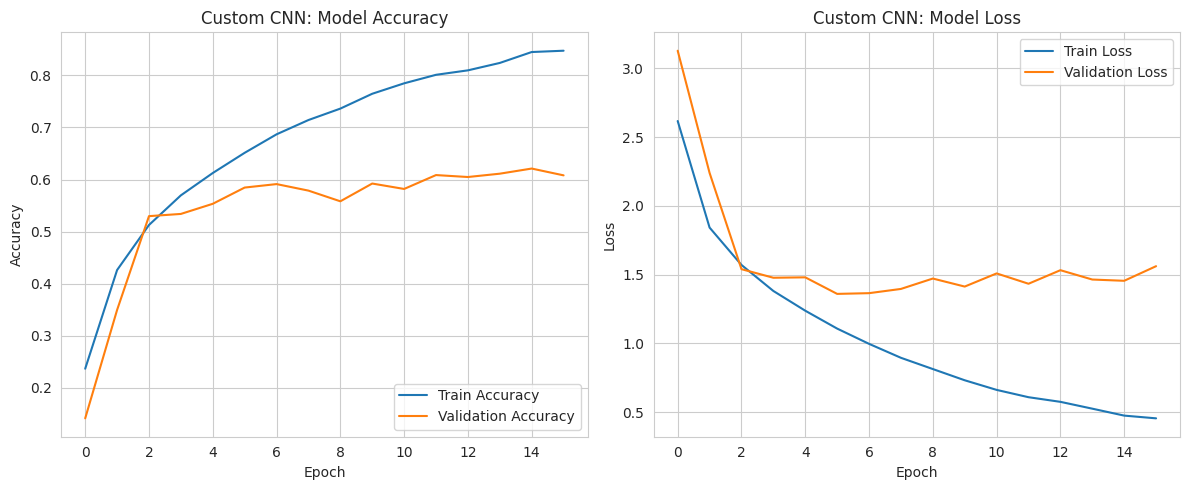

In [92]:
# %% [markdown]
# ## Part 5: Implementing and Training Your Own CNN Model from Scratch

# %% [markdown]
# ### Part 5.1: Imports for CNN
# Ensure TensorFlow is installed.
# !pip install tensorflow scikit-learn seaborn matplotlib

# %%
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# %% [markdown]
# ### Part 5.2: Data Preprocessing for CNN
# The images from Part 0 (`X_train_images_bgr`, `X_val_images_bgr`, `X_test_images_bgr`) are in BGR format with pixel values in [0, 255].
# For the CNN, we should:
# 1. Normalize pixel values to the [0, 1] range.
# 2. One-hot encode the labels (`y_train_final`, `y_val_final`, `y_test_final`).

# It's assumed that X_train_images_bgr, y_train_final, etc. are loaded from Part 0.
# Also NUM_CLASSES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, target_names_part1 are available from Part 0.

# %%
# Normalize pixel values to [0, 1]
# Ensure the data types are float32 for division
X_train_cnn = X_train_images_bgr.astype('float32') / 255.0
X_val_cnn = X_val_images_bgr.astype('float32') / 255.0
X_test_cnn = X_test_images_bgr.astype('float32') / 255.0

# One-hot encode labels
# y_train_final, y_val_final, y_test_final are from Part 0.4
# NUM_CLASSES is also defined/updated in Part 0.4
y_train_cnn = to_categorical(y_train_final, num_classes=NUM_CLASSES)
y_val_cnn = to_categorical(y_val_final, num_classes=NUM_CLASSES)
y_test_cnn = to_categorical(y_test_final, num_classes=NUM_CLASSES)

print(f"X_train_cnn shape: {X_train_cnn.shape if X_train_cnn.size > 0 else 'Empty'}")
print(f"y_train_cnn shape: {y_train_cnn.shape if y_train_cnn.size > 0 else 'Empty'}")
print(f"X_val_cnn shape: {X_val_cnn.shape if X_val_cnn.size > 0 else 'Empty'}")
print(f"y_val_cnn shape: {y_val_cnn.shape if y_val_cnn.size > 0 else 'Empty'}")
print(f"X_test_cnn shape: {X_test_cnn.shape if X_test_cnn.size > 0 else 'Empty'}")
print(f"y_test_cnn shape: {y_test_cnn.shape if y_test_cnn.size > 0 else 'Empty'}")
print(f"Image dimensions: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}") #
print(f"Number of classes: {NUM_CLASSES}") #

# %% [markdown]
# ### Part 5.3: Building the Custom CNN Model
# This is an "efficient" model for 28x28 images. It's not too deep to prevent overfitting
# and uses common layers like Conv2D, MaxPooling2D, BatchNormalization, and Dropout.
#
# **Experimentation Guidance (as per assignment):**
# You should try several architectures. For 28x28 images, consider:
# - **Number of Conv Blocks:** Try 2 to 3 Conv-BN-ReLU-Pool blocks.
# - **Filters:** Start with 32 filters, maybe go up to 64 or 128 in later blocks. More filters capture more complex features but increase parameters.
# - **Kernel Size:** (3,3) is common. (5,5) can be tried for initial layers.
# - **Dense Layers:** One or two dense layers after flattening. 128 or 256 units.
# - **Dropout Rate:** Experiment with values like 0.25, 0.3, 0.5.
# - **Batch Normalization:** Generally helpful. Try with and without, or at different positions (before/after activation).

# %%
def create_efficient_cnn_model(input_shape, num_classes):
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        # Dropout(0.25), # Optional dropout after pooling

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        # Dropout(0.25),

        # Block 3 (Optional, can be added for slightly deeper model if 28x28 still underfits)
        # Conv2D(128, (3, 3), activation='relu', padding='same'),
        # BatchNormalization(),
        # MaxPooling2D((2, 2)),
        # Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'), # A dense layer with 128 units
        BatchNormalization(),
        Dropout(0.5), # Dropout for regularization
        Dense(num_classes, activation='softmax') # Output layer
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# %%
# Define input shape based on image dimensions from Part 0
input_shape_cnn = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
custom_cnn_model = create_efficient_cnn_model(input_shape_cnn, NUM_CLASSES)
custom_cnn_model.summary()

# %% [markdown]
# ### Part 5.4: Training the Custom CNN Model
# - `batch_size`: Common values are 32, 64, 128. Larger batch sizes can speed up training but might lead to poorer generalization.
# - `epochs`: Number of times to iterate over the entire training dataset. `EarlyStopping` will help prevent overfitting.
# - `callbacks`:
#     - `EarlyStopping`: Stops training if the validation loss doesn't improve for a set number of epochs (`patience`).
#     - `ModelCheckpoint`: Saves the best model (based on `val_accuracy` or `val_loss`) during training.

# %%
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
# Define a path to save your best model. This is crucial for using the best version later.
model_checkpoint = ModelCheckpoint('best_custom_cnn_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)


# Training parameters
BATCH_SIZE = 64
EPOCHS = 50 # Early stopping will likely stop it sooner if it overfits or converges.

# Check if data is available before training
if X_train_cnn.size == 0 or y_train_cnn.size == 0 or X_val_cnn.size == 0 or y_val_cnn.size == 0:
    print("ERROR: Training or validation data is empty. Skipping model training.")
    history_custom_cnn = None # Set to None if training is skipped
else:
    history_custom_cnn = custom_cnn_model.fit(
        X_train_cnn, y_train_cnn,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val_cnn, y_val_cnn),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

# %% [markdown]
# ### Part 5.5: Evaluating the Custom CNN Model
# - Load the best saved model from `ModelCheckpoint` for a fair evaluation.
# - Evaluate on the test set.
# - Report Accuracy, Precision, Recall, F1-Score (using `classification_report`).
# - Show a confusion matrix.
# - Discuss misclassified examples (this requires manual inspection of predictions).

# %%
# Load the best model saved by ModelCheckpoint for evaluation
if history_custom_cnn is not None: # Proceed only if training happened
    try:
        best_model = tf.keras.models.load_model('best_custom_cnn_model.keras')
        print("\nEvaluating the best model saved by ModelCheckpoint on the test set:")

        # Check if test data is available
        if X_test_cnn.size == 0 or y_test_cnn.size == 0:
            print("ERROR: Test data is empty. Skipping model evaluation.")
        else:
            test_loss_custom, test_accuracy_custom = best_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
            print(f"\nCustom CNN Test Accuracy (Best Model): {test_accuracy_custom*100:.2f}%")
            print(f"Custom CNN Test Loss (Best Model): {test_loss_custom:.4f}")

            # Get predictions for the test set
            y_pred_proba_custom = best_model.predict(X_test_cnn)
            y_pred_classes_custom = np.argmax(y_pred_proba_custom, axis=1)
            y_true_classes_custom = np.argmax(y_test_cnn, axis=1) # Convert one-hot encoded true labels back

            # Classification Report
            # target_names_part1 should be available from Part 0.4
            if 'target_names_part1' in globals() and len(target_names_part1) == NUM_CLASSES:
                class_labels_report = target_names_part1
            else: # Fallback if target_names_part1 is not perfectly aligned or NUM_CLASSES changed
                class_labels_report = [f"Class {i}" for i in range(NUM_CLASSES if NUM_CLASSES > 0 else max(y_true_classes_custom.max(), y_pred_classes_custom.max()) + 1 )]
                if NUM_CLASSES == 0 : print("Warning: NUM_CLASSES was 0, deriving class names from data.")

            print("\nClassification Report for Custom CNN (Best Model):")
            print(classification_report(y_true_classes_custom, y_pred_classes_custom, target_names=class_labels_report, zero_division=0))

            # Confusion Matrix
            conf_matrix_custom = confusion_matrix(y_true_classes_custom, y_pred_classes_custom)
            plt.figure(figsize=(12, 10))
            sns.heatmap(conf_matrix_custom, annot=True, fmt='d', cmap='Blues',
                        xticklabels=class_labels_report, yticklabels=class_labels_report)
            plt.title('Confusion Matrix for Custom CNN (Best Model)')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Error loading the best model or evaluating: {e}")
        print("Ensure 'best_custom_cnn_model.keras' was saved correctly during training.")
else:
    print("Training was skipped due to empty data. Model evaluation cannot proceed.")
# %% [markdown]
# ### Part 5.6: Plotting Training History (Loss and Accuracy Curves)
# This visualizes the model's learning process. Required by the assignment.
# %%
if history_custom_cnn and hasattr(history_custom_cnn, 'history'): # Check if training history exists
    plt.figure(figsize=(12, 5))

    # Plot Training & Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_custom_cnn.history['accuracy'], label='Train Accuracy')
    plt.plot(history_custom_cnn.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Custom CNN: Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_custom_cnn.history['loss'], label='Train Loss')
    plt.plot(history_custom_cnn.history['val_loss'], label='Validation Loss')
    plt.title('Custom CNN: Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("No training history to plot (training might have been skipped or failed).")

# %% [markdown]
# ### Part 5.7: Discussion of Results and Experimentation
#
# **Your Report Should Include (as per assignment instructions):**
#
# 1.  **Architecture Choices & Trials:**
#     * Explain your final CNN architecture (layers, filters, kernel sizes, activations, pooling, dropout, batch normalization).
#     * **Crucially, document "all your considerable trials"**:
#         * What different architectures did you try? (e.g., more/fewer convolutional blocks, more/fewer filters, different dense layer sizes).
#         * How did these changes affect performance (accuracy, loss, training time)?
#         * Why did you settle on your final architecture? Justify your choices.
#
# 2.  **Training Process:**
#     * Discuss batch size, epochs, and optimizer choices.
#     * How did you decide when to stop training? Refer to your loss/accuracy plots and the `EarlyStopping` callback.
#     * Present the training/validation loss and accuracy graphs.
#
# 3.  **Evaluation Metrics:**
#     * Analyze the overall test accuracy, precision, recall, and F1-score for each class (from the classification report).
#     * Use the confusion matrix to discuss which classes your model performs well on and which it struggles with.
#
# 4.  **Misclassified Examples:**
#     * Manually (or programmatically) find some images from the test set that your model misclassified.
#     * Display these images along with their true label and the label predicted by your model.
#     * Discuss potential reasons for these misclassifications (e.g., image quality, subtle differences between species, insufficient features learned by the 28x28 images, model complexity).
#
# 5.  **Comparison with Parts 3 and 4:**
#     * After completing Part 3 (Fine-tuning Pretrained CNNs) and Part 4 (Randomly Weighted CNNs), compare the performance of your custom CNN (Part 5) with those models. Discuss efficiency, accuracy, and complexity.
#
# 6.  **Efficiency and Image Size:**
#     * The current model uses 28x28 images. Comment on how this significant downscaling might impact performance. For a "most efficient" model in terms of performance, a larger image size (e.g., 64x64, 128x128, if resources allow) would likely yield better results by retaining more information, although it would be less computationally efficient. Your trials could include experimenting with this.
#     * Discuss "efficiency" in terms of model parameters vs. performance achieved.
#
# 7.  **Data Augmentation (Optional but a good "Extra" to discuss for efficiency):**
#     * To improve generalization and potentially get better results with the same amount of raw data (making your data use more "efficient"), you could explore data augmentation (random rotations, shifts, flips, zooms) on your training data using `tensorflow.keras.preprocessing.image.ImageDataGenerator` or Keras's preprocessing layers. This would be a valuable experiment to mention or conduct.
#
# **Remember to comment your code thoroughly and provide detailed interpretations in your report.**